# Analysis of Conv512 against Dense

In this notebook, we analyzed the impact of a convolutionnal layer against a fully-connected layer in the initial layer *Layer0* for a mrw, woth parameters $H = 0.8$ and $\lambda^2 = 0.03$.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import os
import datetime
import numpy as np
from time import time, strftime
import pandas as pd
import statsmodels.api as sm

from plot_result import Analysis_sf, Analysis_m, comparison_Analysis
from fbm import fbm
from mrw import mrw

from training import Trainer

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
latent_dim = 2**12
ts_dim = 2**12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10000
n = 3
batch_size = 128

In [3]:
def complet_training(n, savepath, namepath, latent_dim, ts_dim, epochs, device):
    generators = []
    discriminators = []
    trainers = []
    synthetic_datas = []
    plot_result_sf = []
    plot_result_m = []
    
    # Create Scorepath
    scorepath = os.path.join(r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output',savepath)
    if not os.path.exists(scorepath):
        os.makedirs(scorepath)
    
    # Init parameters
    lr_a = 1e-4
    lr_b = 1e-4
    
    # Exportation true data
    true_data = torch.tensor(pd.read_csv('data_train' + namepath).to_numpy().astype('float32')).to(device)
    
    for i in range (n):
        
        print('.....')
        print('New Training')
        print('.....')
        
        data_train = true_data[np.random.randint(low = 0, high = true_data.cpu().shape[0], size = 10000)]
        
        generator = Generator().to(device)
        discriminator = Discriminator(ts_dim = ts_dim).to(device)
        
        # Init optimizers
        G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
        D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

        # Training
        path = os.path.join(scorepath, 'Training n° ' + str(i+1)) 
        if not os.path.exists(path):
            os.makedirs(path)
        train = Trainer(generator, discriminator, G_opt, D_opt, batch_size, latent_dim, ts_dim, data_train, device, path)
        train.train(epochs=epochs)
        
        # Save models
        noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim)).to(device)
        synthetic_data = generator(noise).cpu()
        with torch.no_grad():
            x = synthetic_data[np.random.randint(low = 0, high = 10000)]
            plt.plot(x, linewidth = 0.5)
            plt.title('Sample of synthetic data GAN n°' + str(i+1))
            plt.show()
            sm.graphics.tsa.plot_acf(x.detach().numpy(), lags=100, zero = False)
            plt.show()
 
        plot_analysis_m = Analysis_m(data_train, synthetic_data, path)
        plot_analysis_sf = Analysis_sf(data_train, synthetic_data, path)
        plot_analysis_m.dataFrame()
        plot_analysis_m.boxplot()
        plot_analysis_sf.plot()
        df_data, df_synthetic = plot_analysis_sf.dataFrame()
        
        generators.append(generator.cpu())
        discriminators.append(discriminator.cpu())
        trainers.append(train)
        synthetic_datas.append(synthetic_data.cpu())
        plot_result_sf.append(plot_analysis_sf)
        plot_result_m.append(plot_analysis_m)
        
    return generators, discriminators, trainers, synthetic_datas, plot_result_sf, plot_result_m

In [4]:
from torch.nn.parameter import Parameter
class btanha(nn.Module):
    
    def __init__(self, alpha = None, beta = None, initialisation = 0.5):
        super(btanha,self).__init__()
        
        self.tanh = nn.Tanh()
        
        if alpha == None :
            self.alpha = Parameter(torch.tensor(initialisation))
        else :
            self.alpha = Parameter(torch.tensor(alpha))
        self.alpha.requiresGrad = True
        
        if beta == None :
            self.beta = Parameter(torch.tensor(initialisation))
        else :
            self.beta = Parameter(torch.tensor(alpha))
        self.beta.requiresGrad = True
        
    def forward(self,x): 
        return self.beta* self.tanh(self.alpha * x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.ts_dim = ts_dim
        self.conv1 = nn.Conv1d(1, 32, kernel_size = 7, padding = 'same')
        self.conv2 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same')
        self.conv3 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same') 
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear(self.ts_dim*8, 50) 
        self.dense2 = nn.Linear(50, 15)
        self.dense3 = nn.Linear(15, 1)    
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.max_pool1d(x,1)
        x = self.flatten(x)
        x = F.leaky_relu(self.dense1(x), 0.2)
        x = F.leaky_relu(self.dense2(x), 0.2)
        return F.leaky_relu(self.dense3(x), 0.2)

In [36]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.Layer0 = nn.Conv1d(1, 1, kernel_size = 512, padding = 'same')
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        self.f = btanha()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.Layer0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], 8, x.shape[2]//8)

        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch3(self.conv3(x))
        x = x.squeeze()
        return self.f(x)

.....
New Training
.....


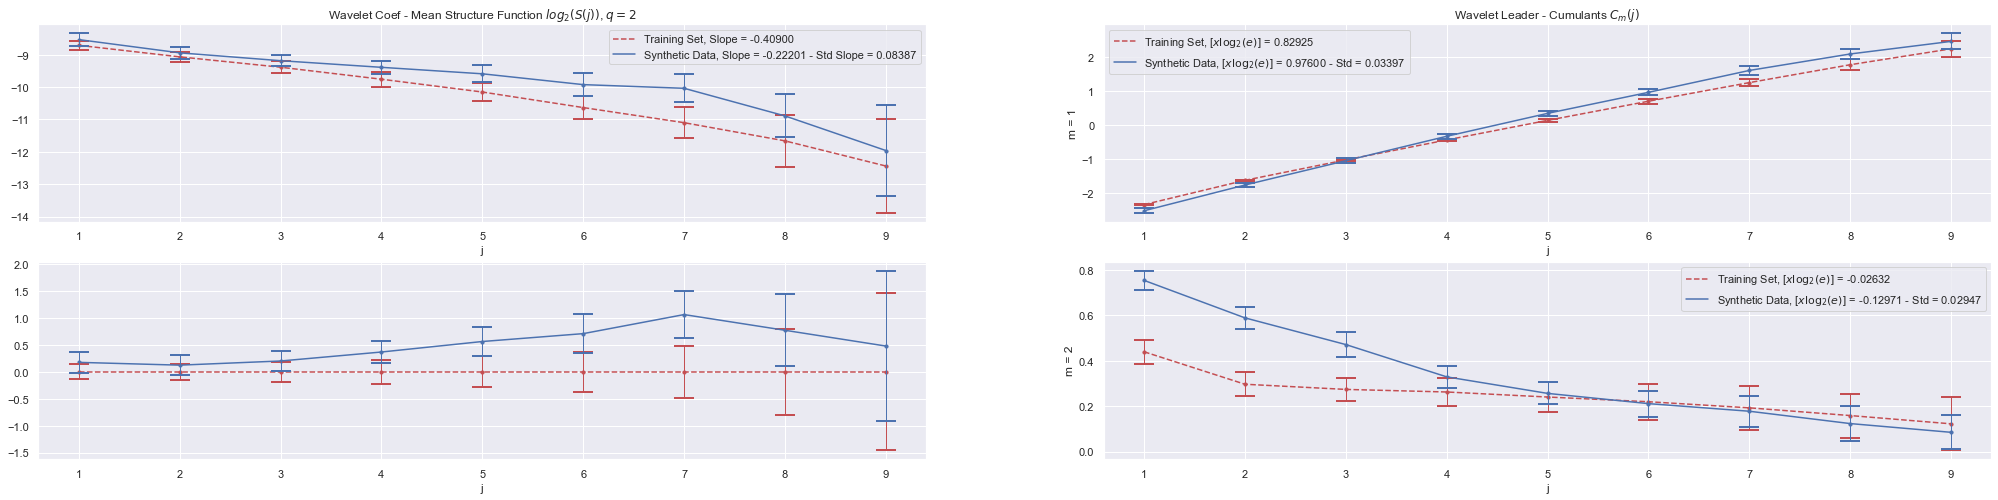

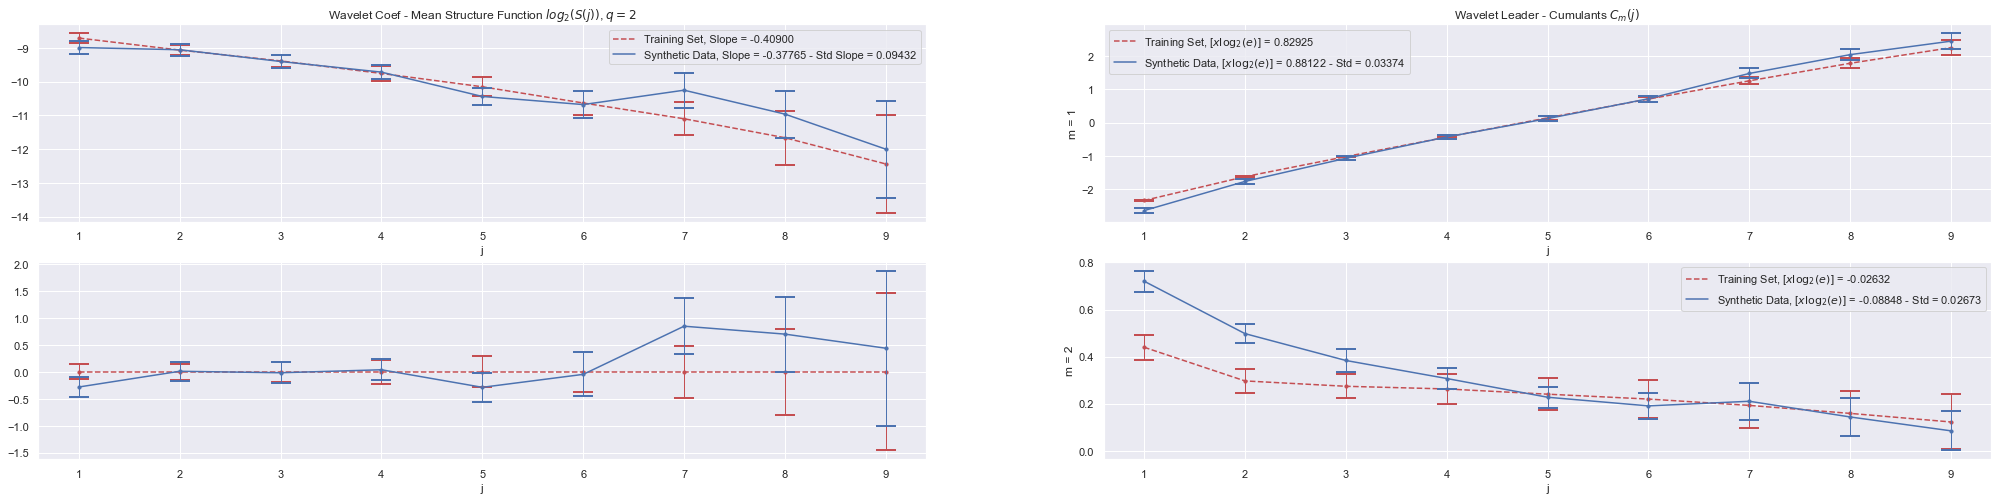

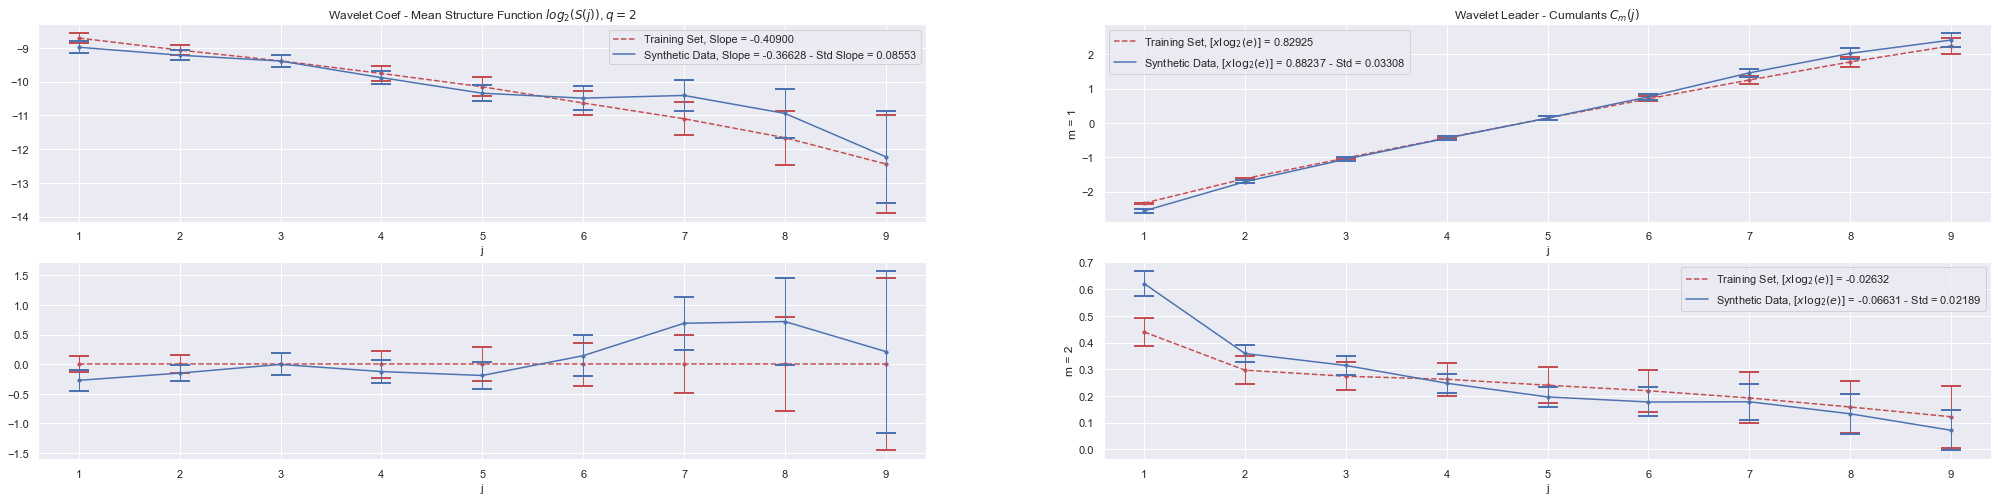

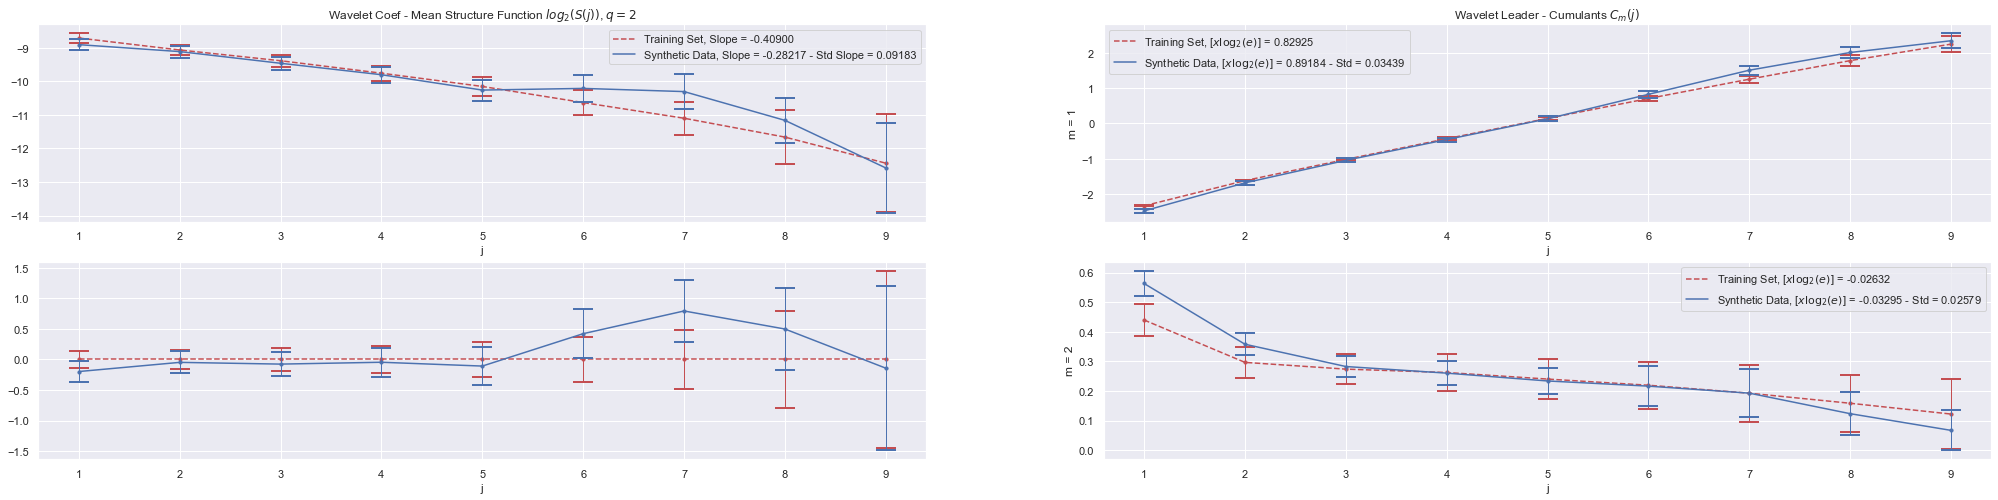

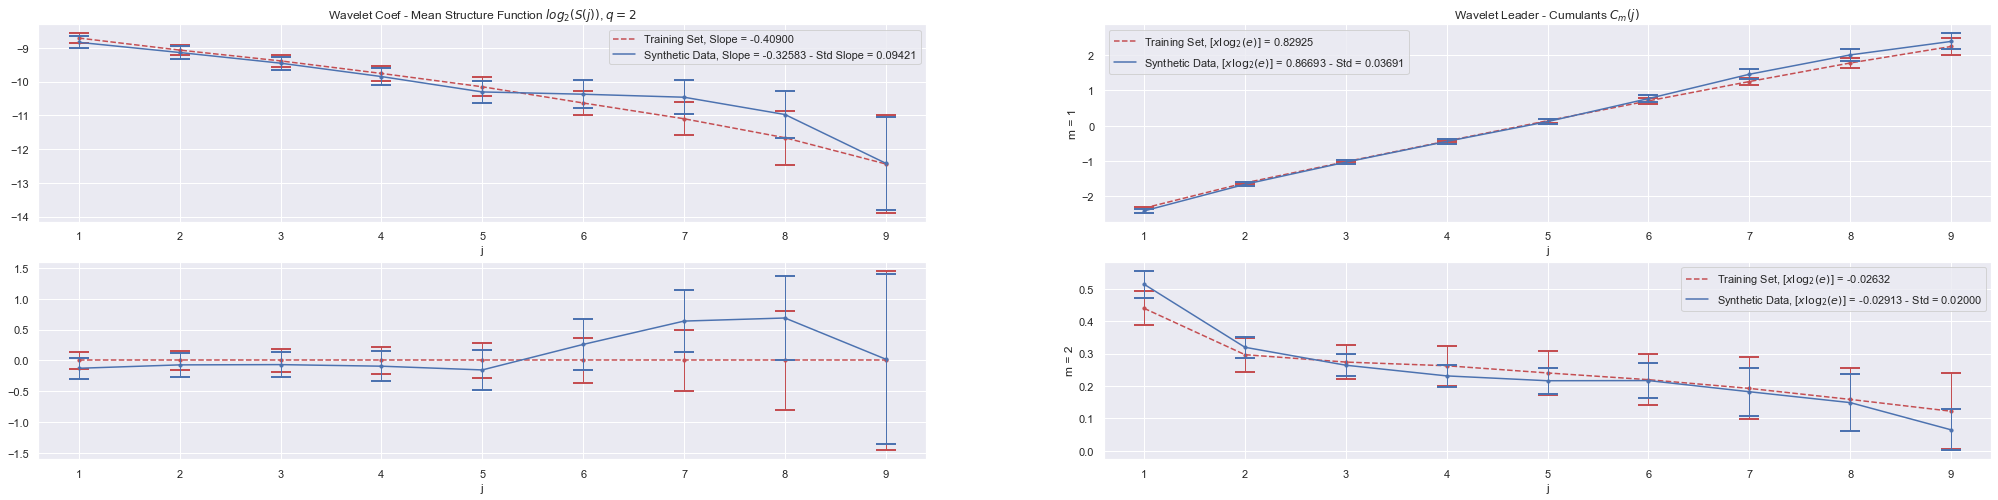

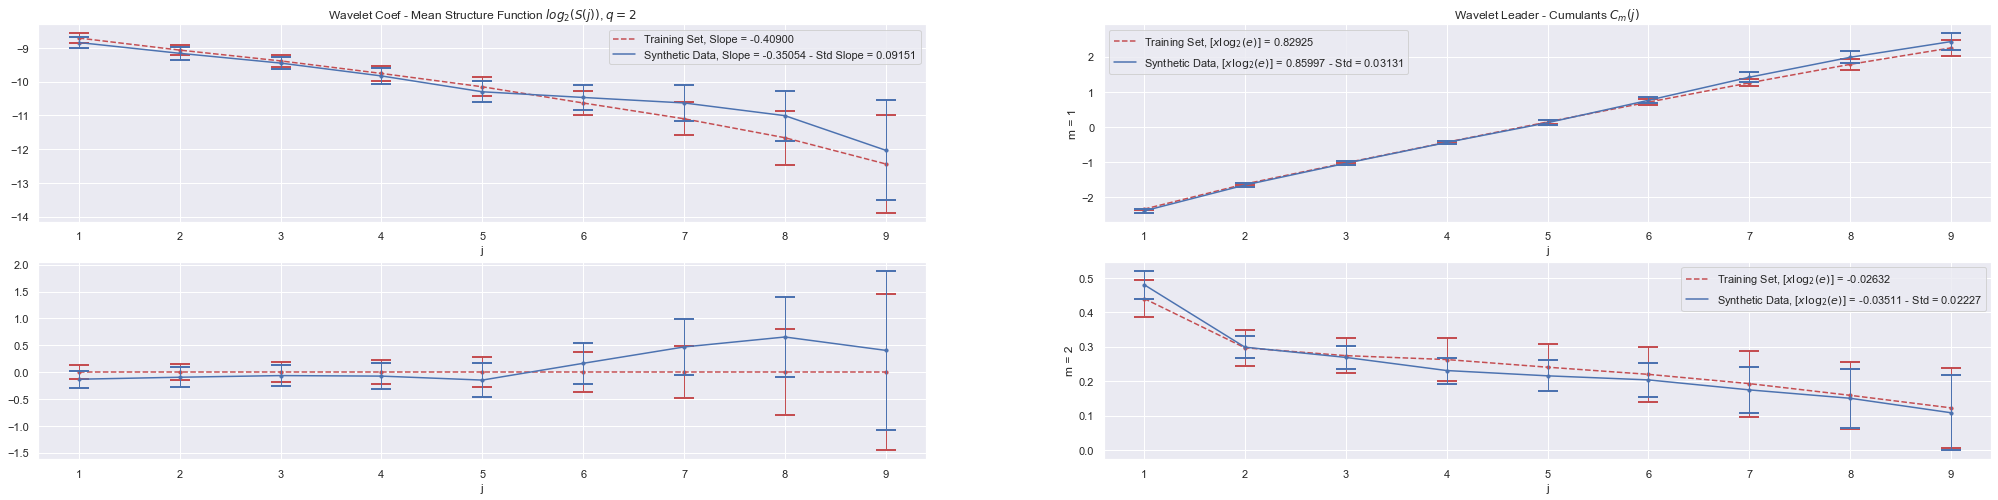

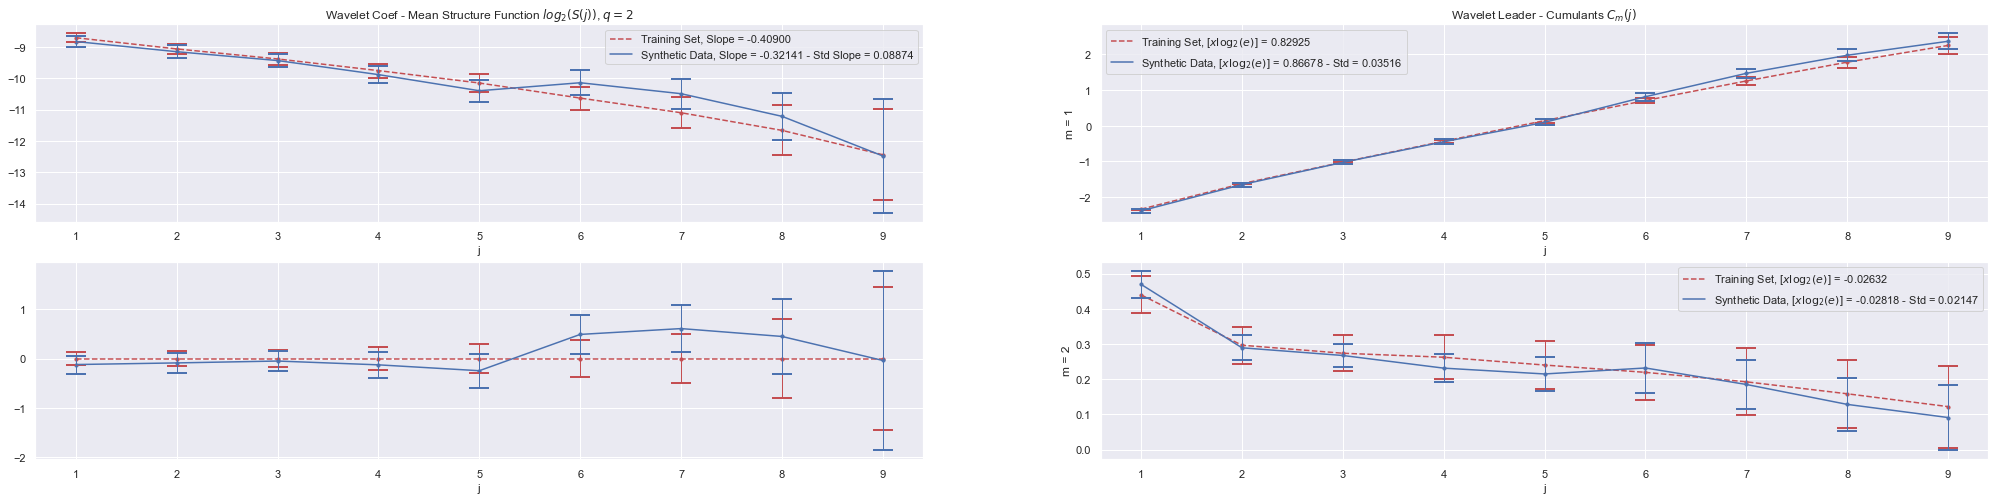

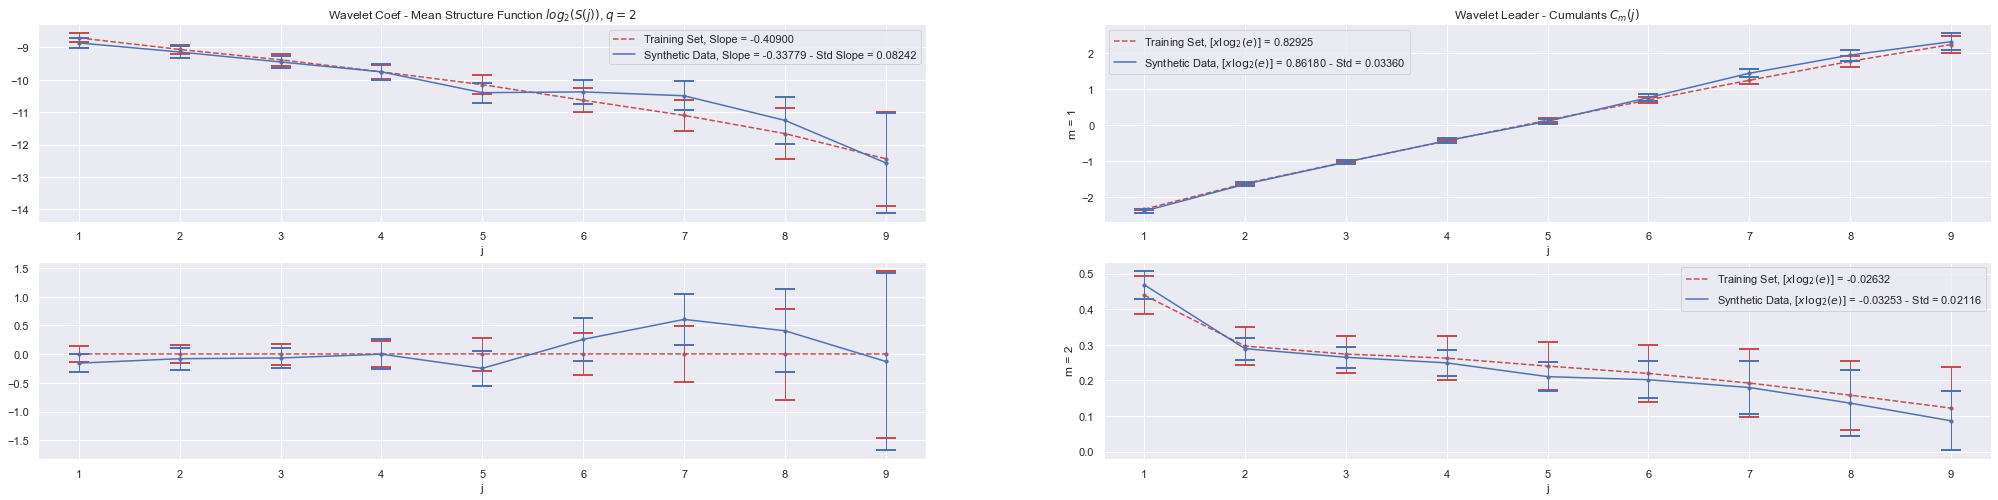

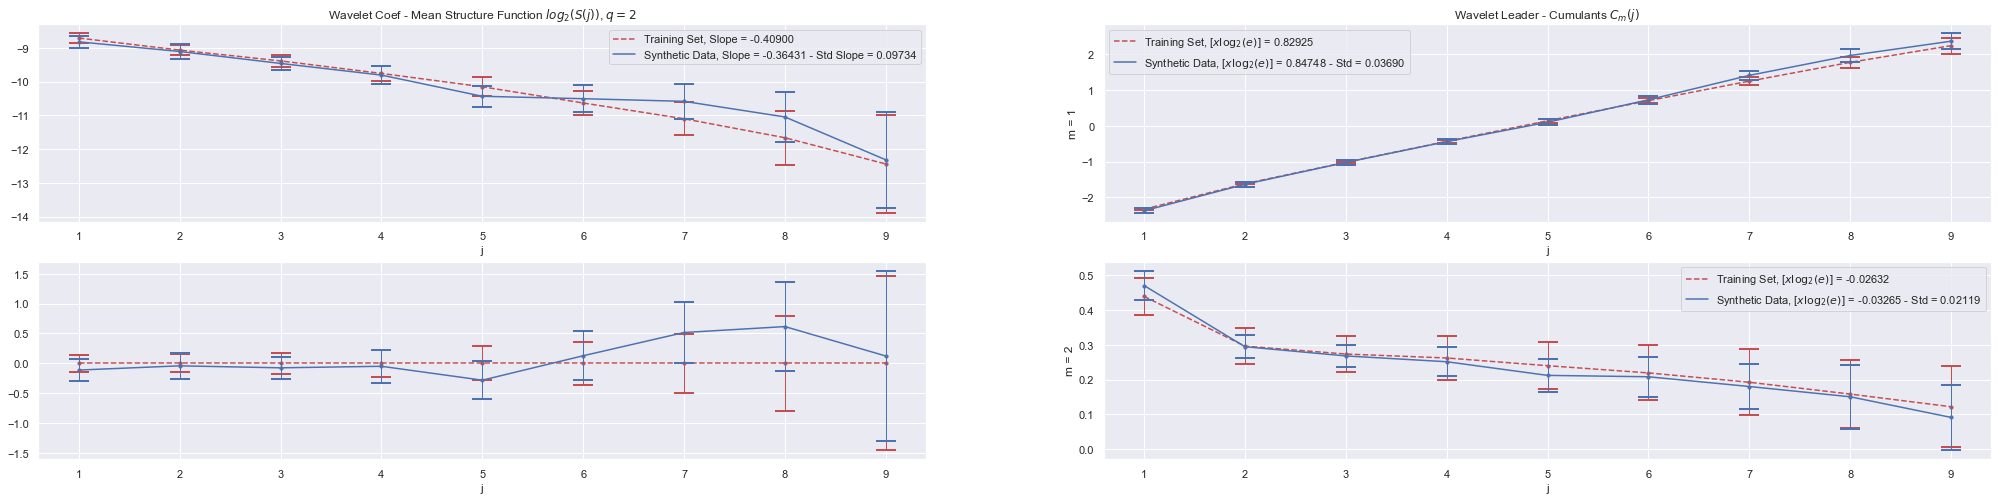

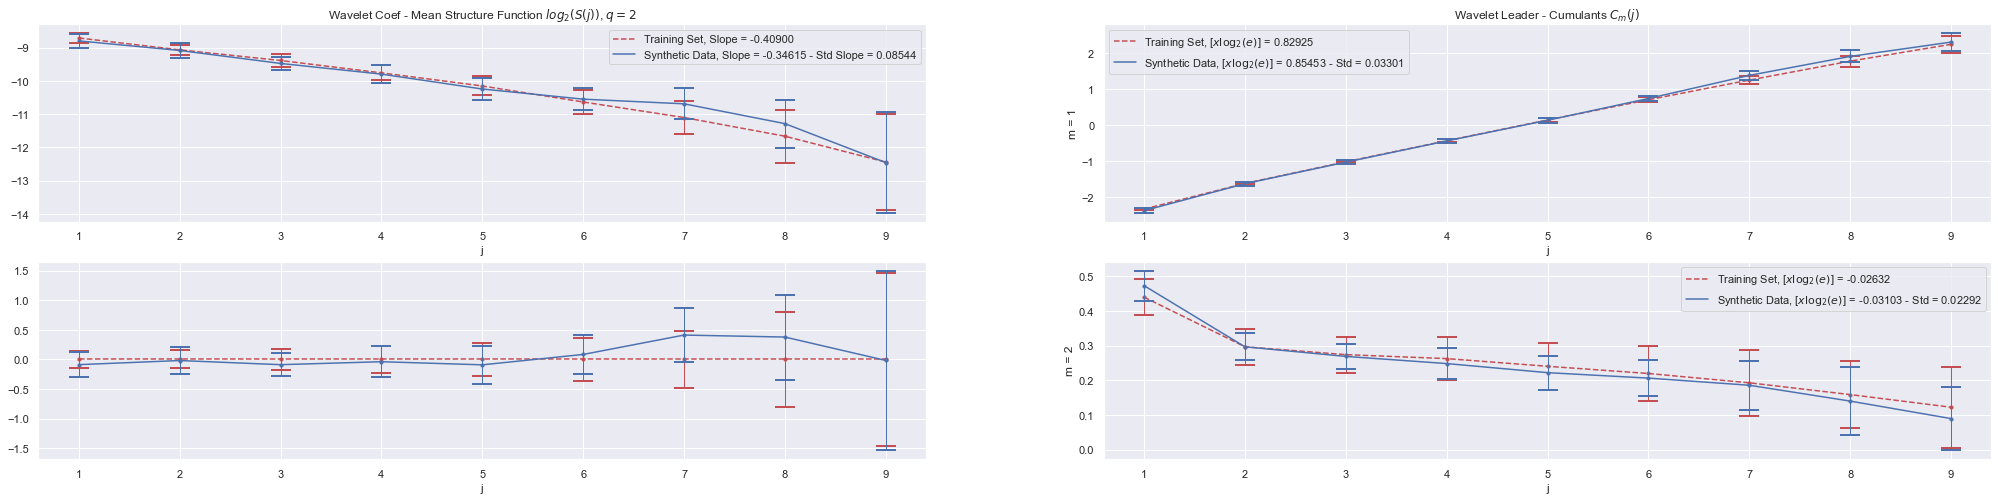

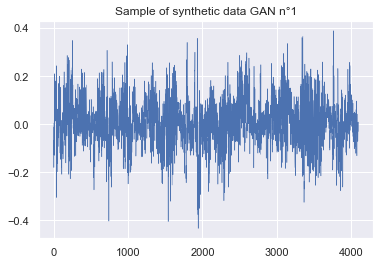

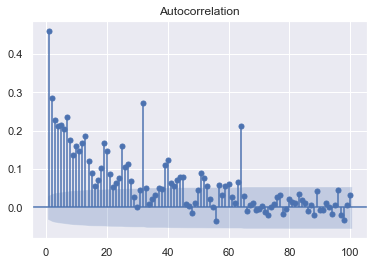

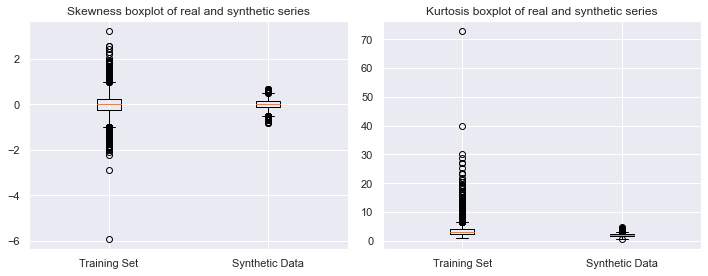

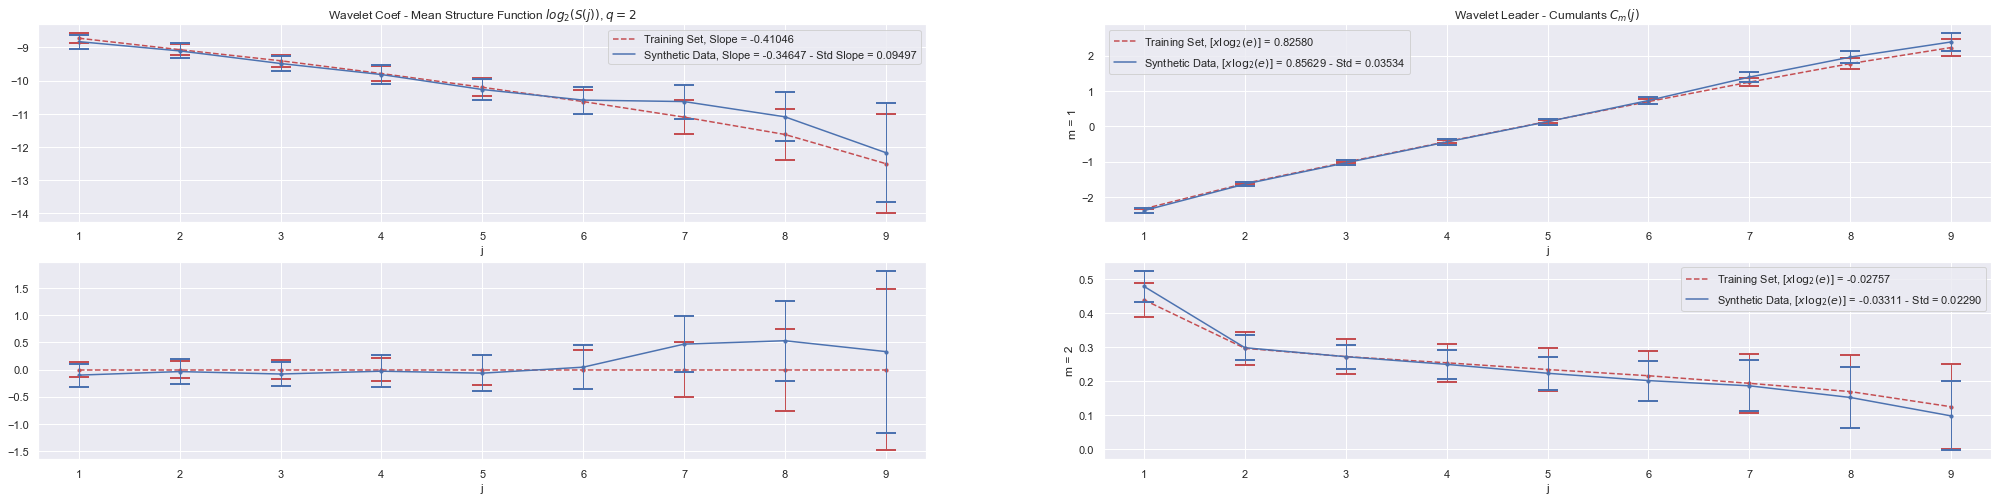

.....
New Training
.....


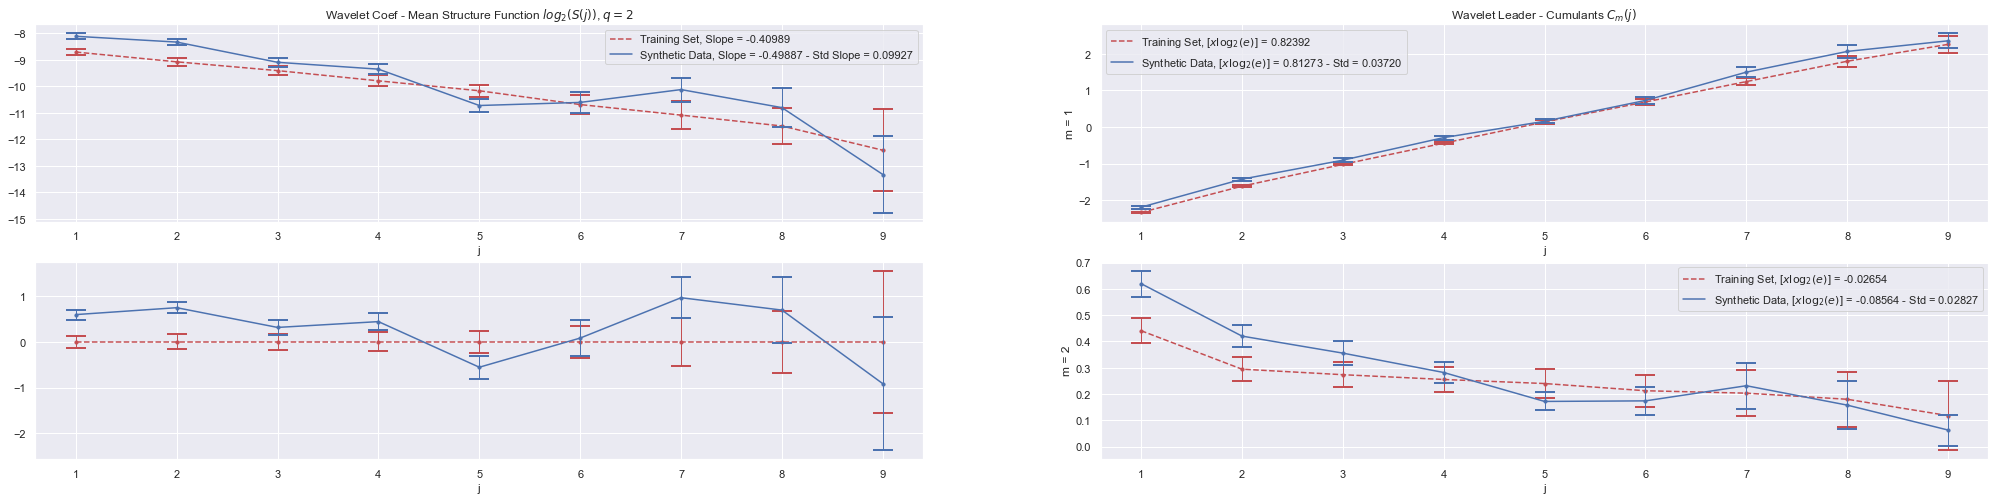

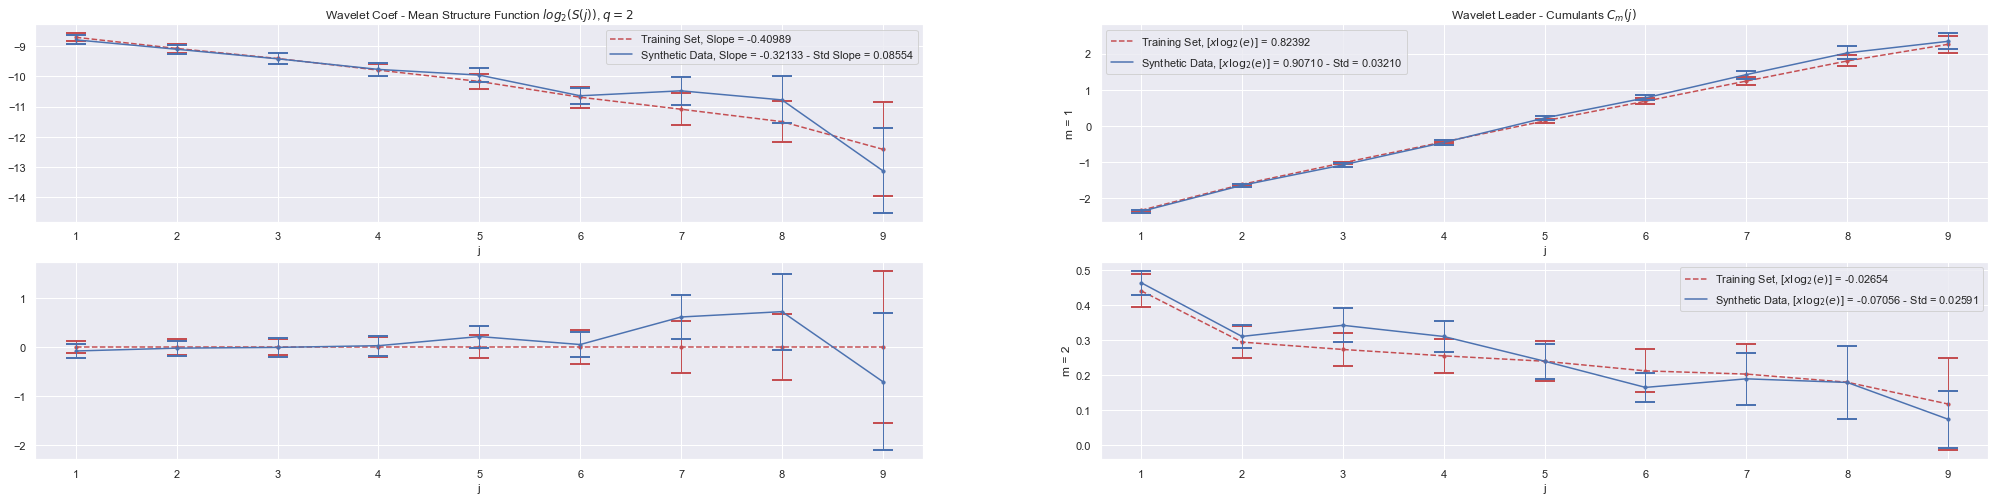

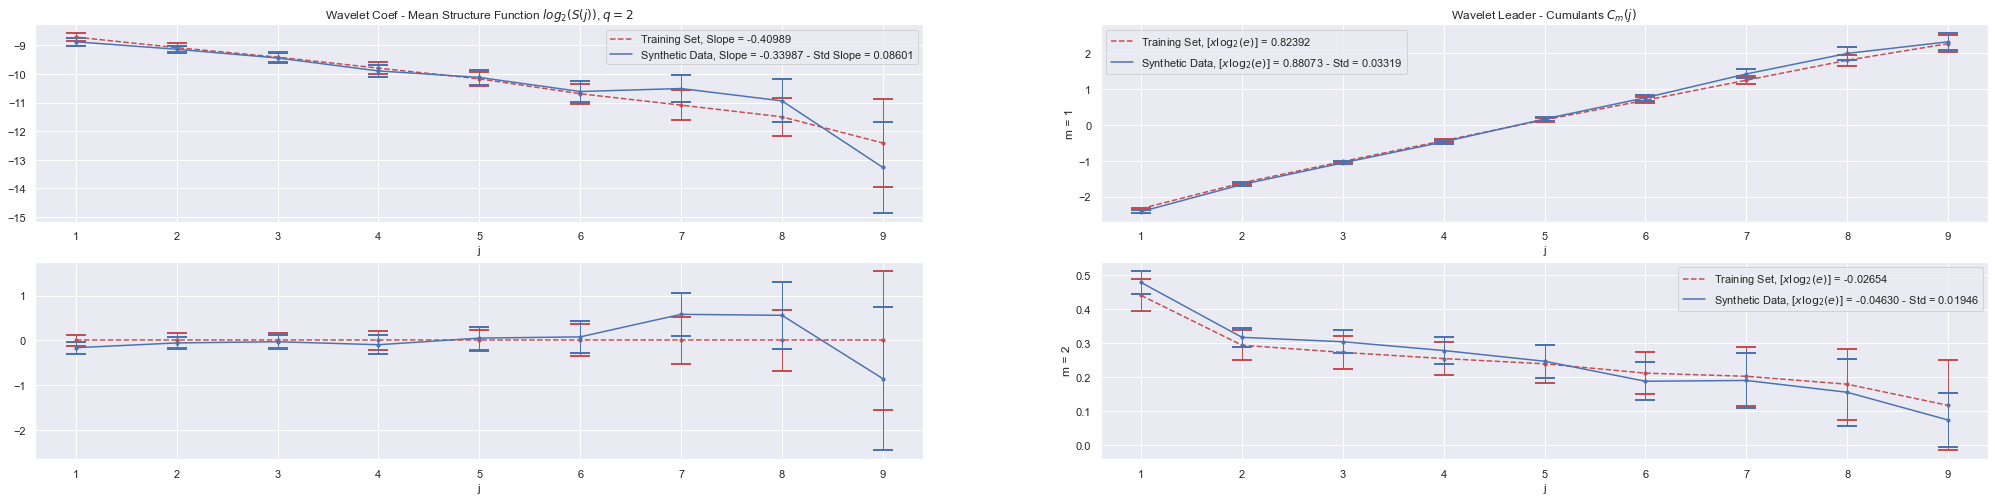

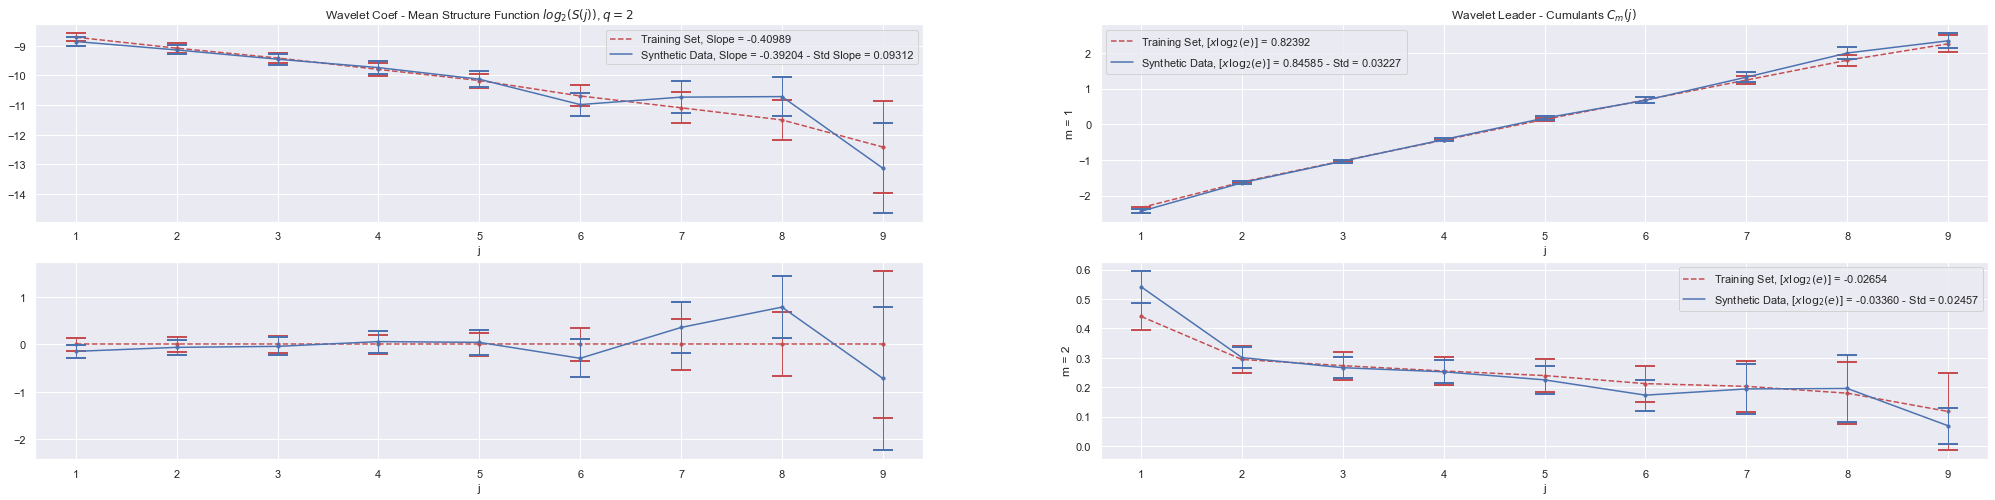

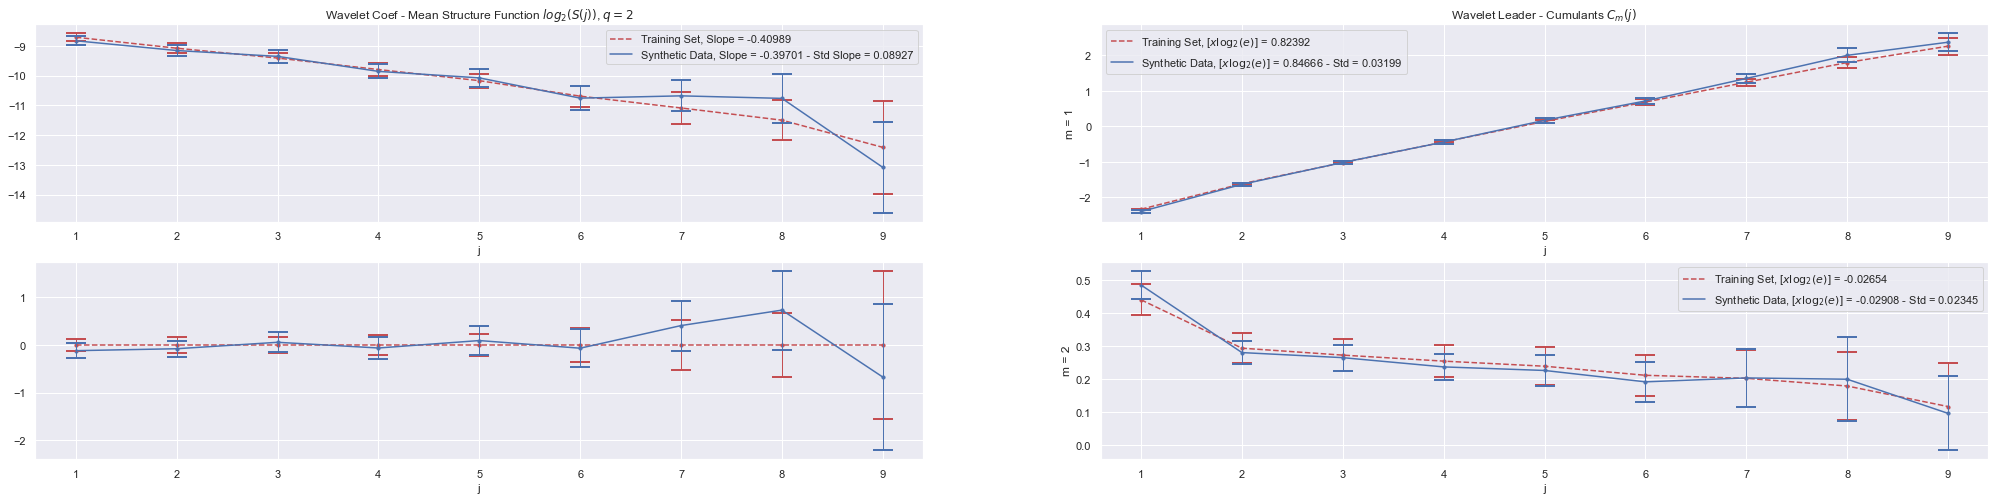

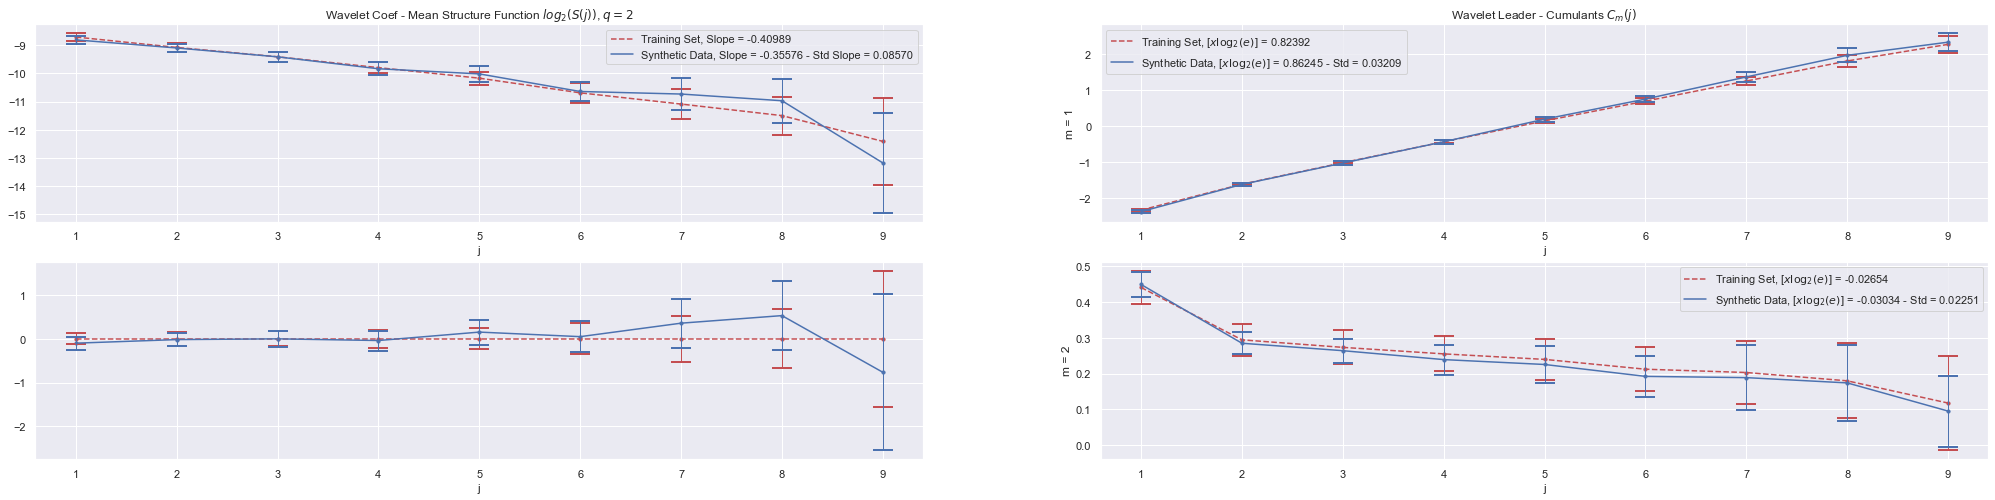

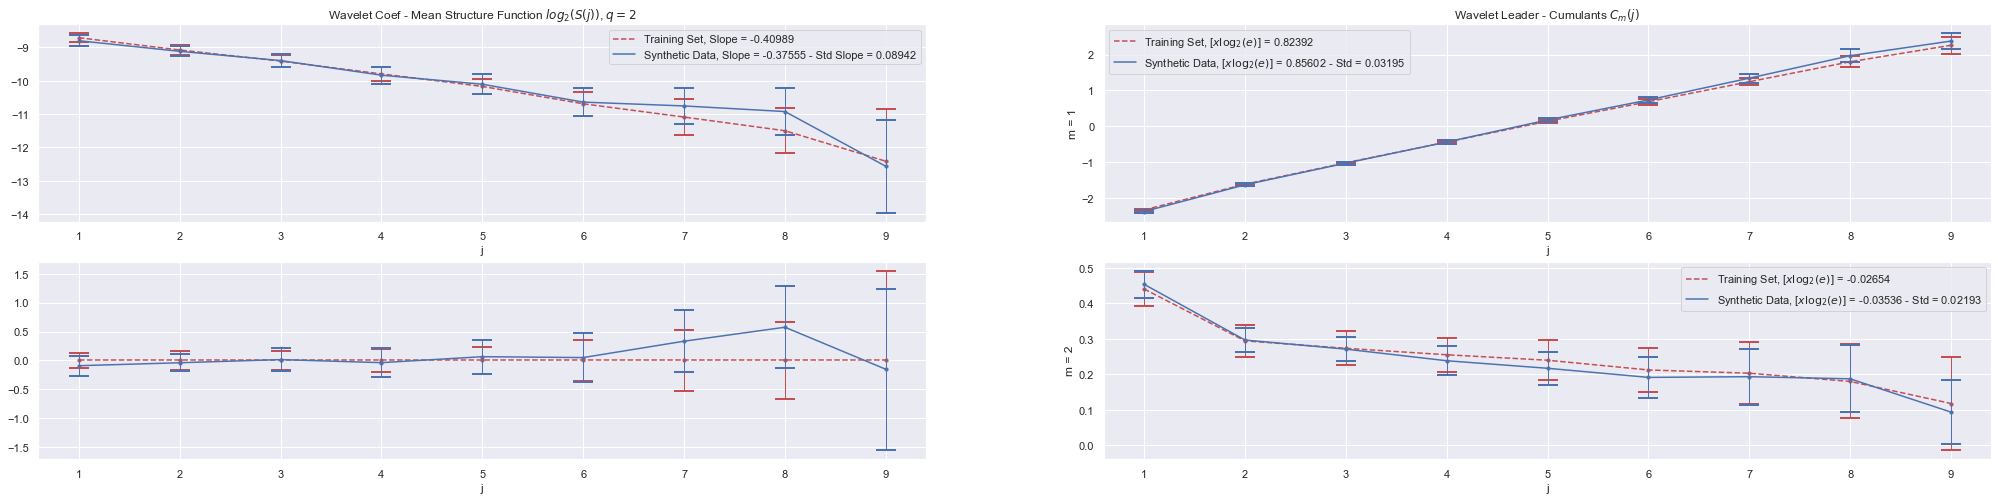

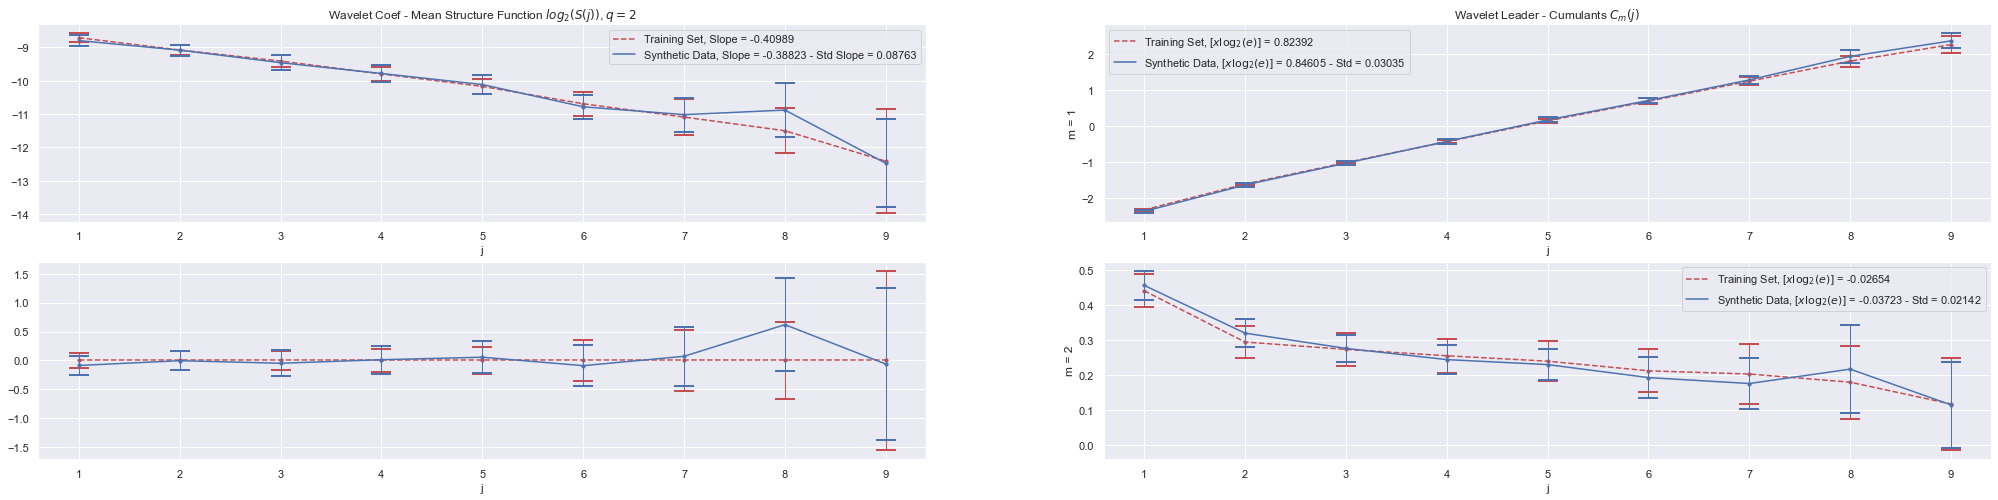

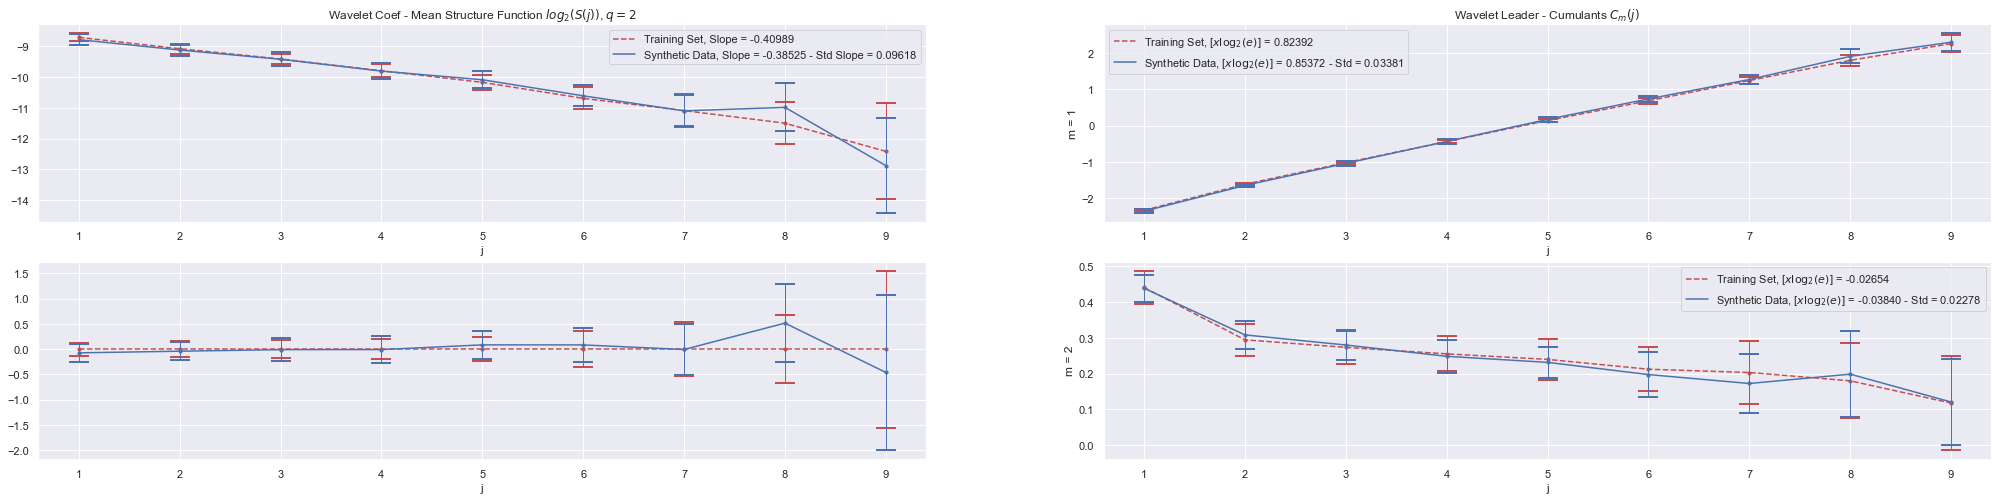

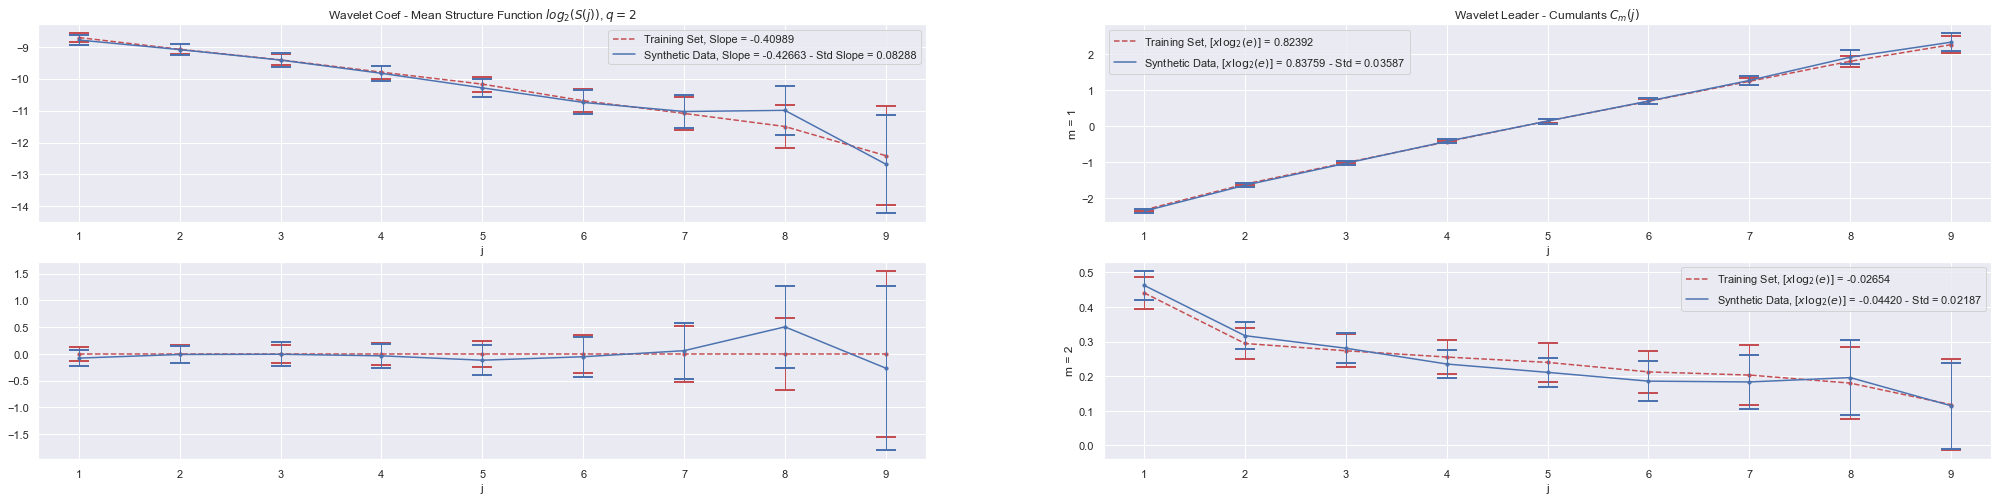

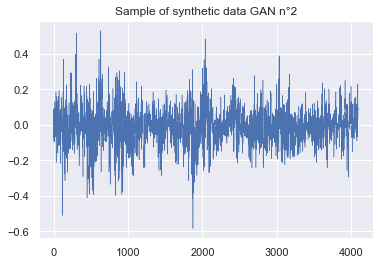

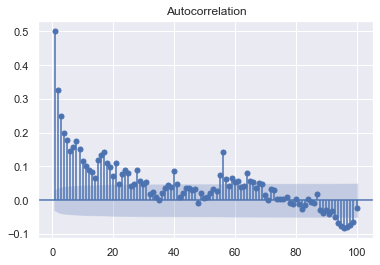

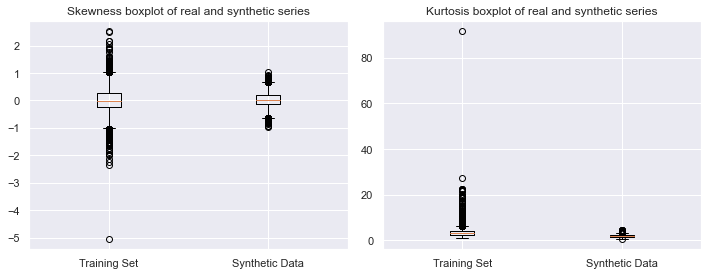

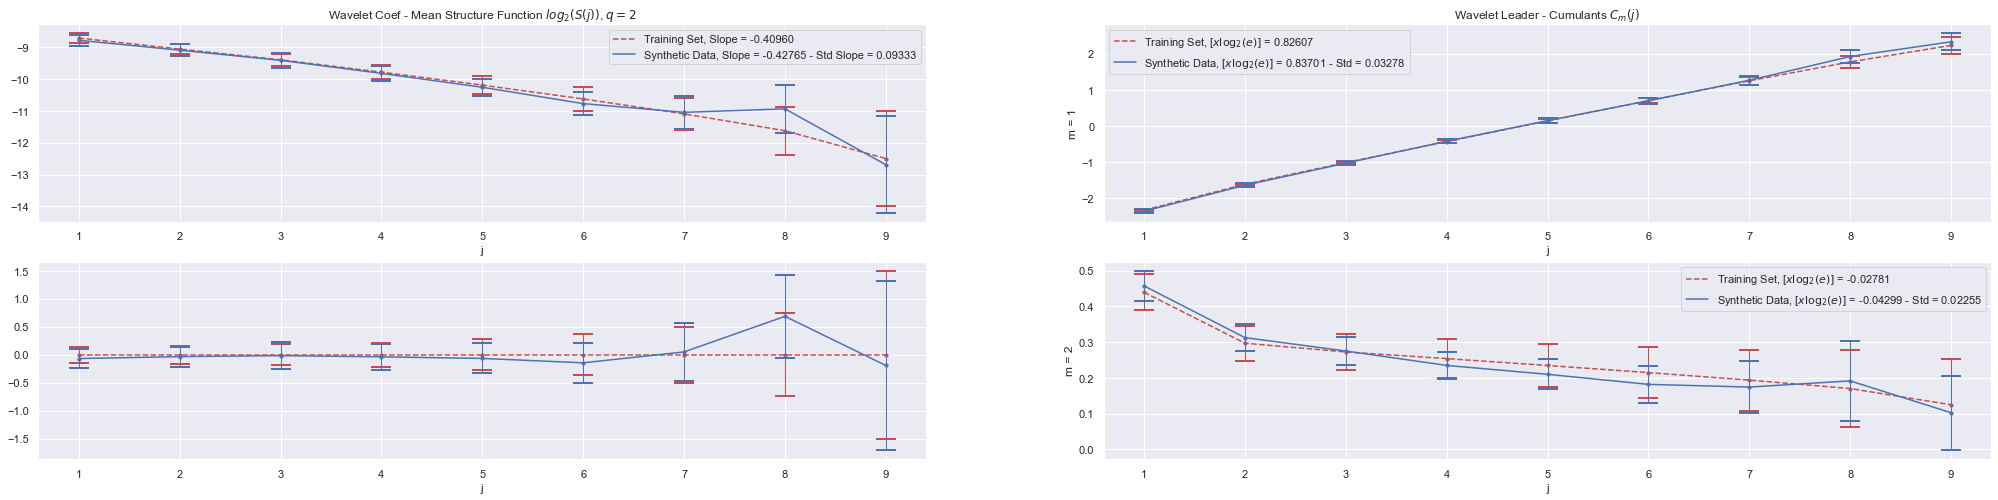

.....
New Training
.....


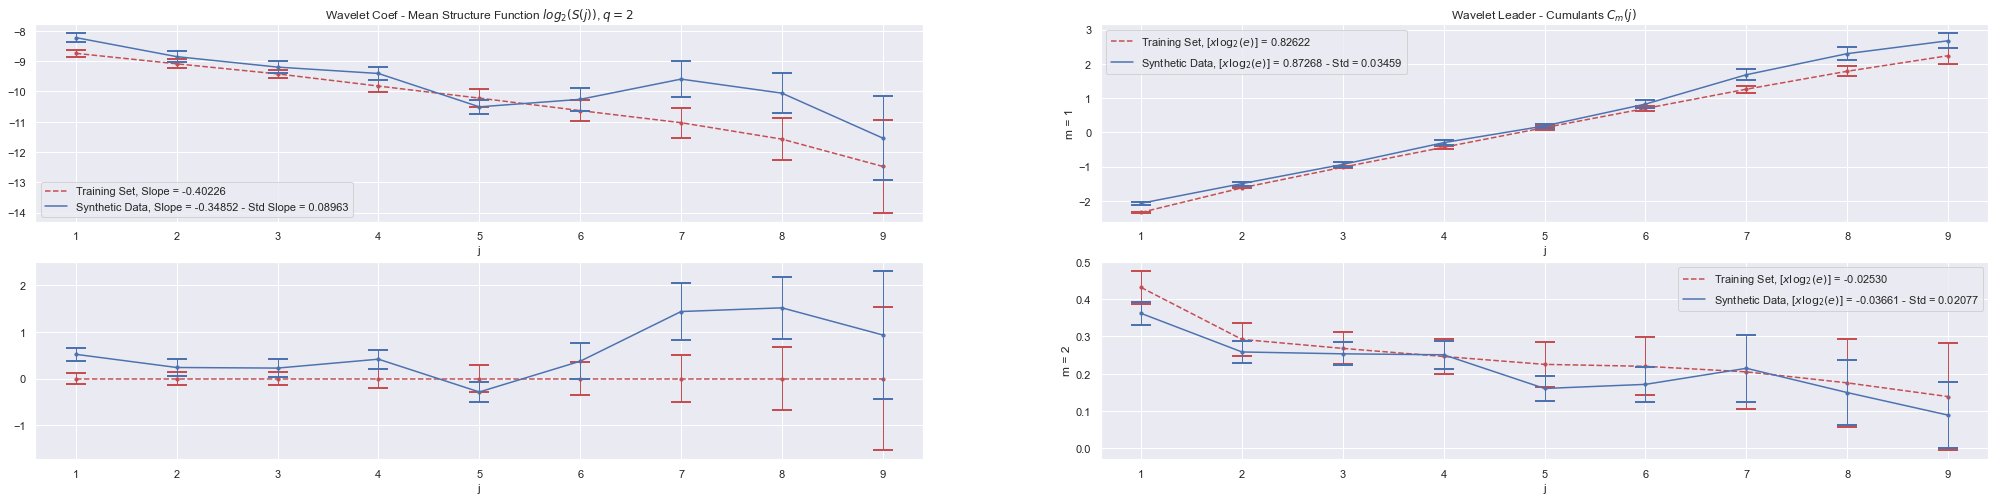

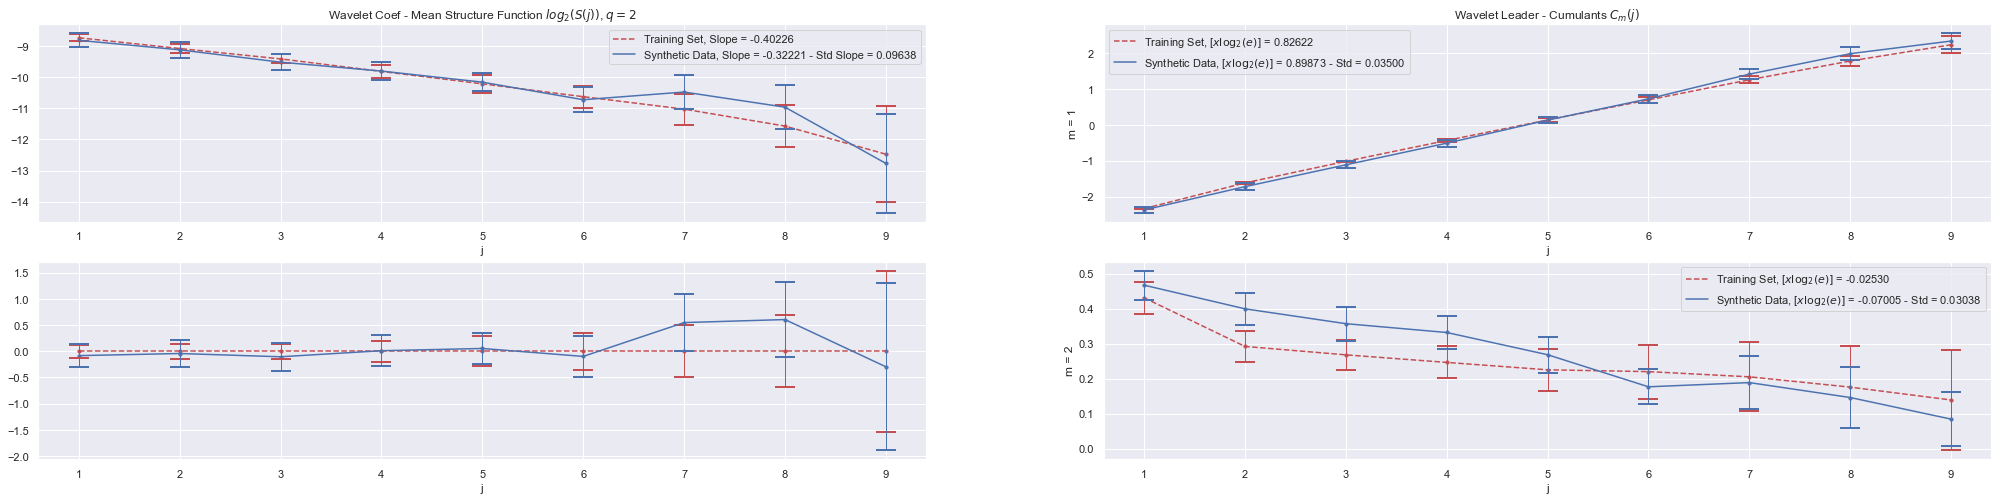

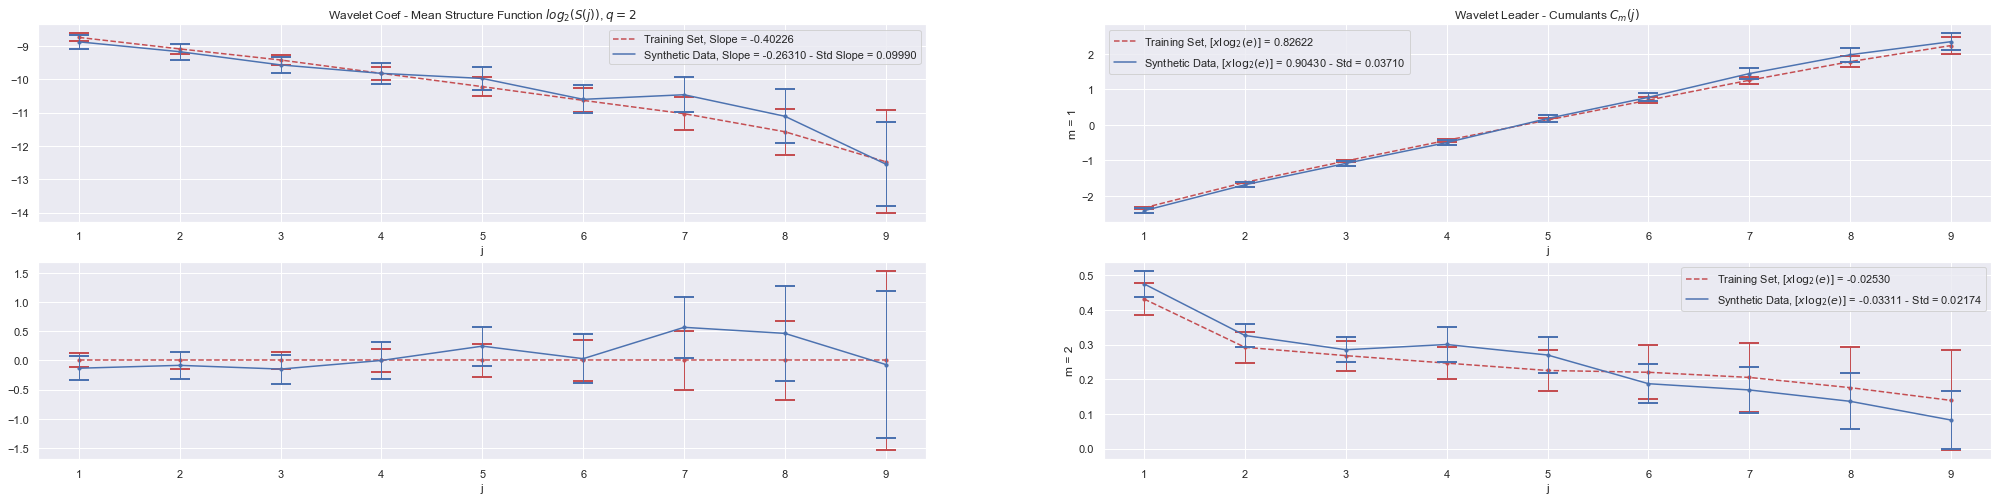

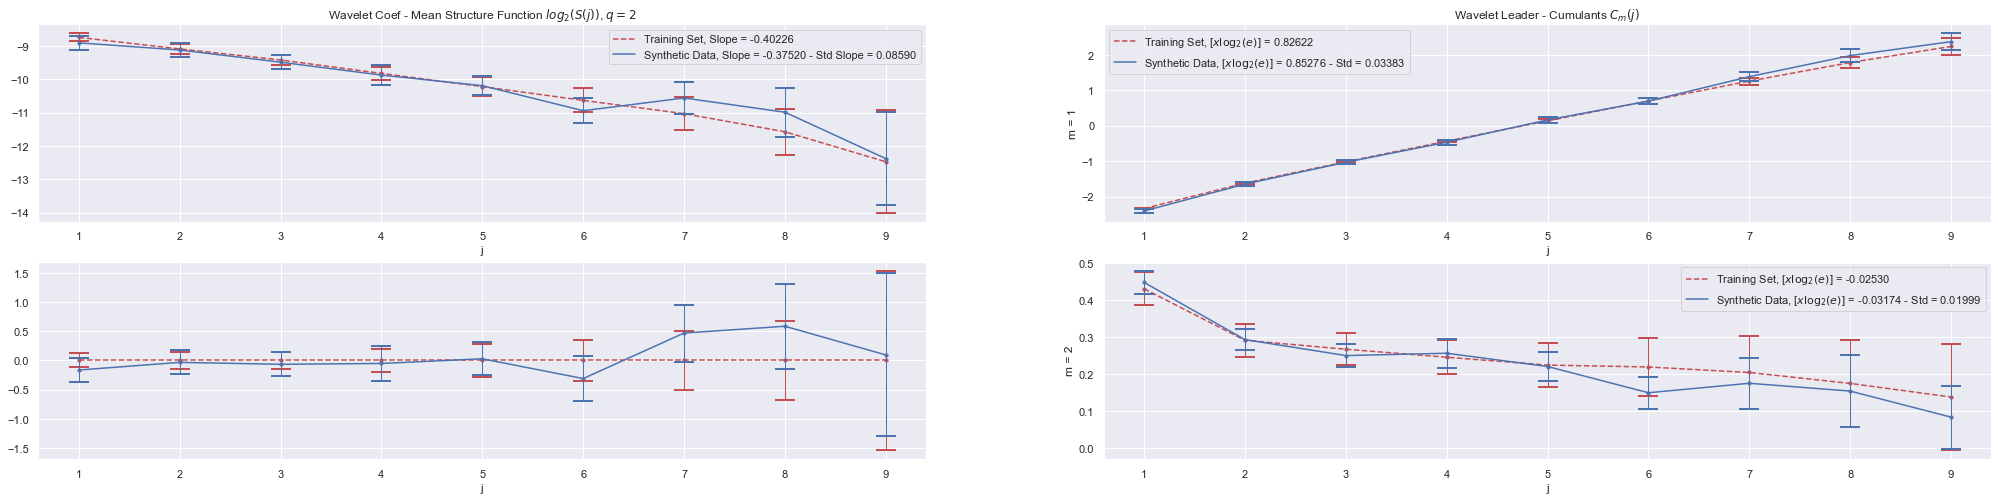

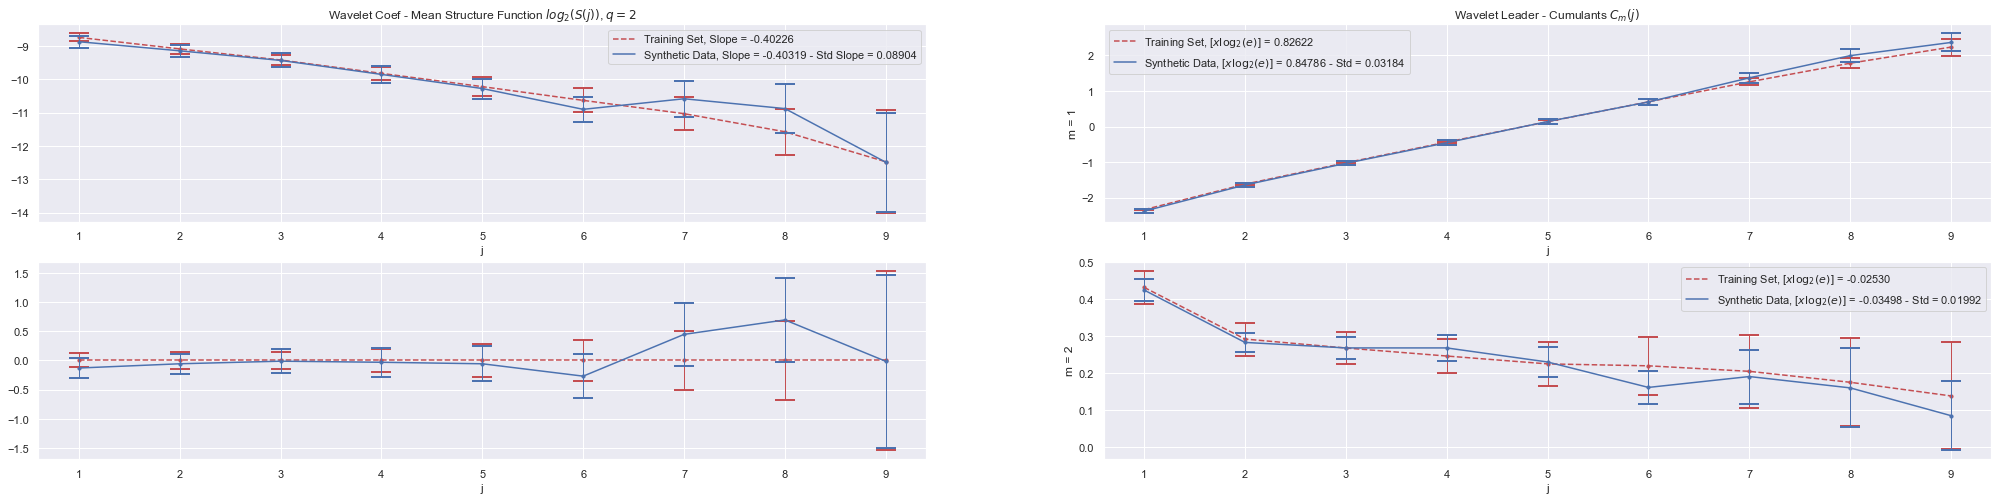

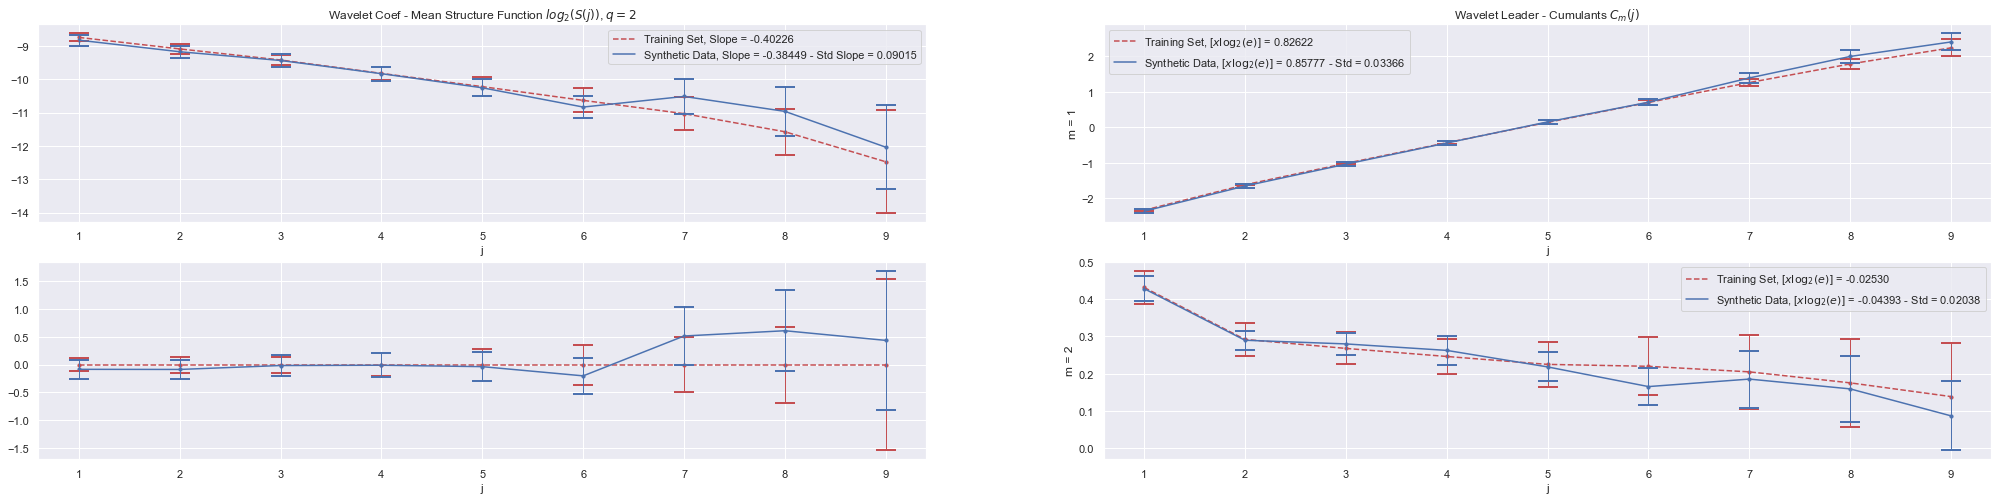

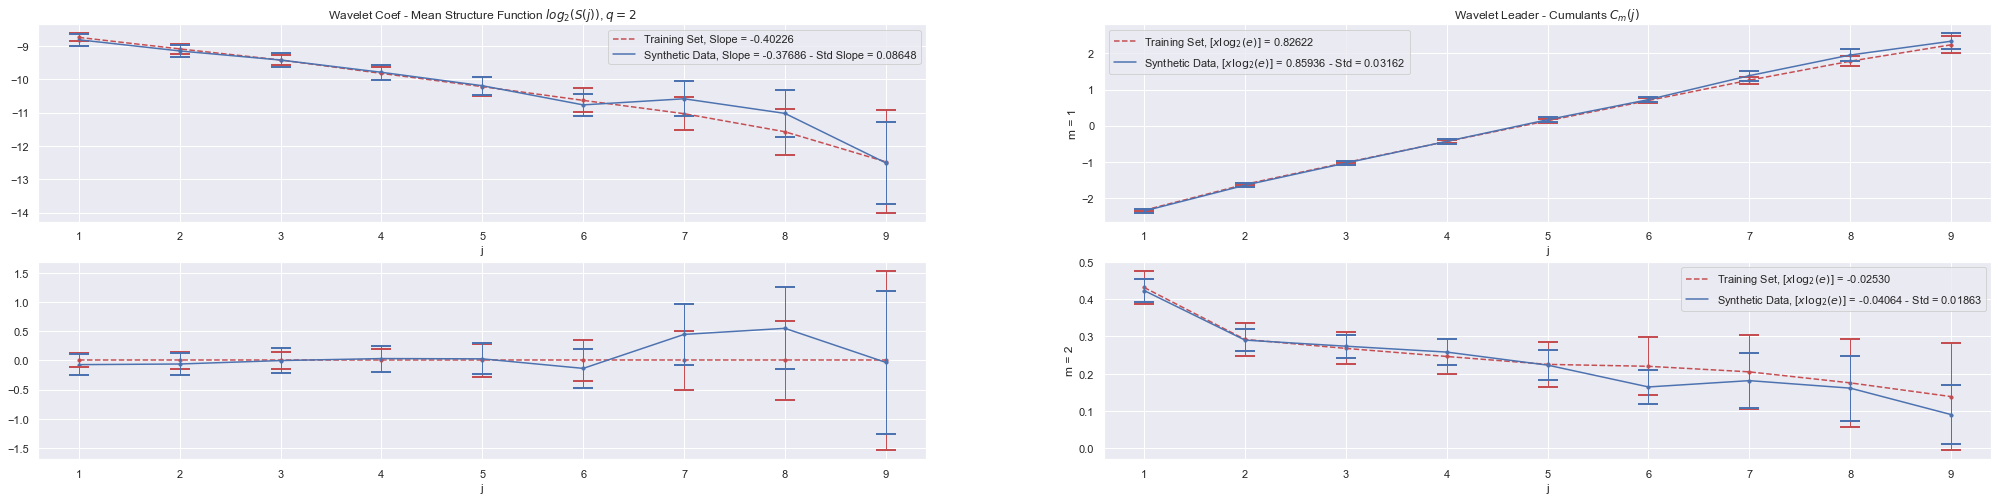

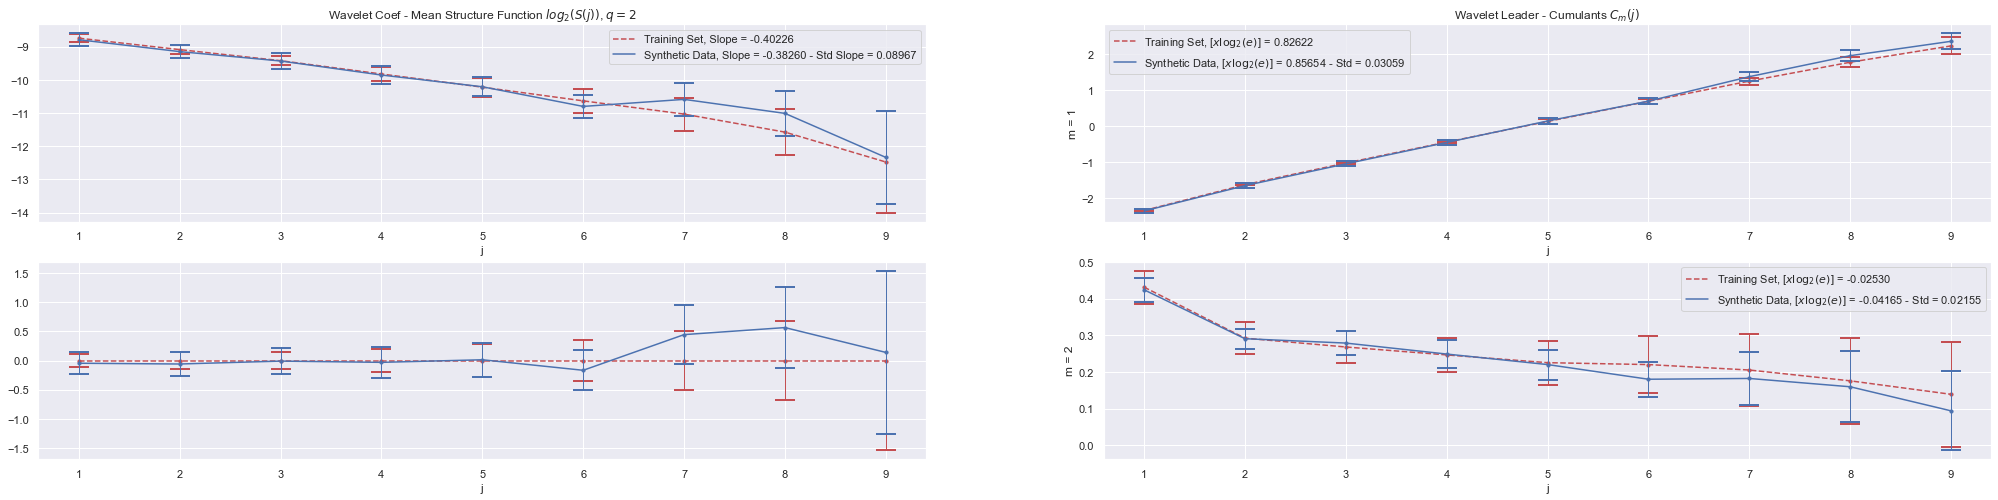

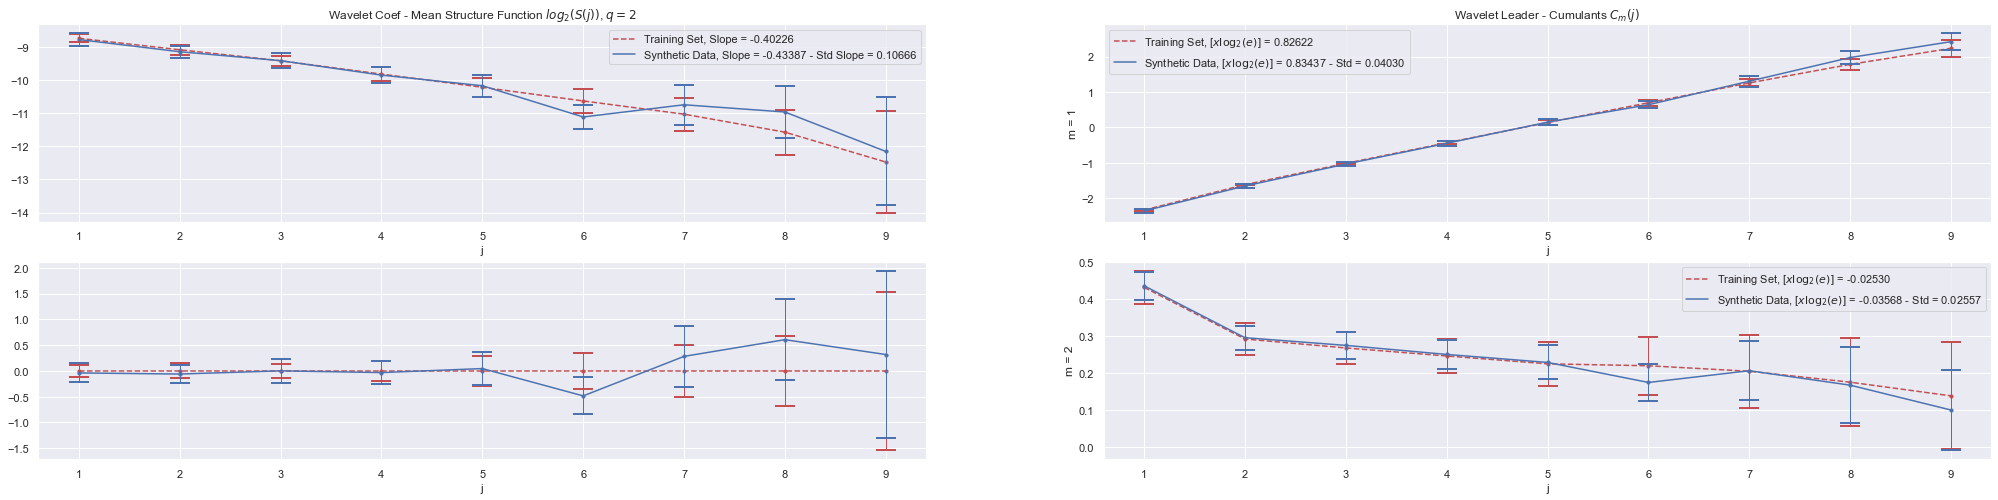

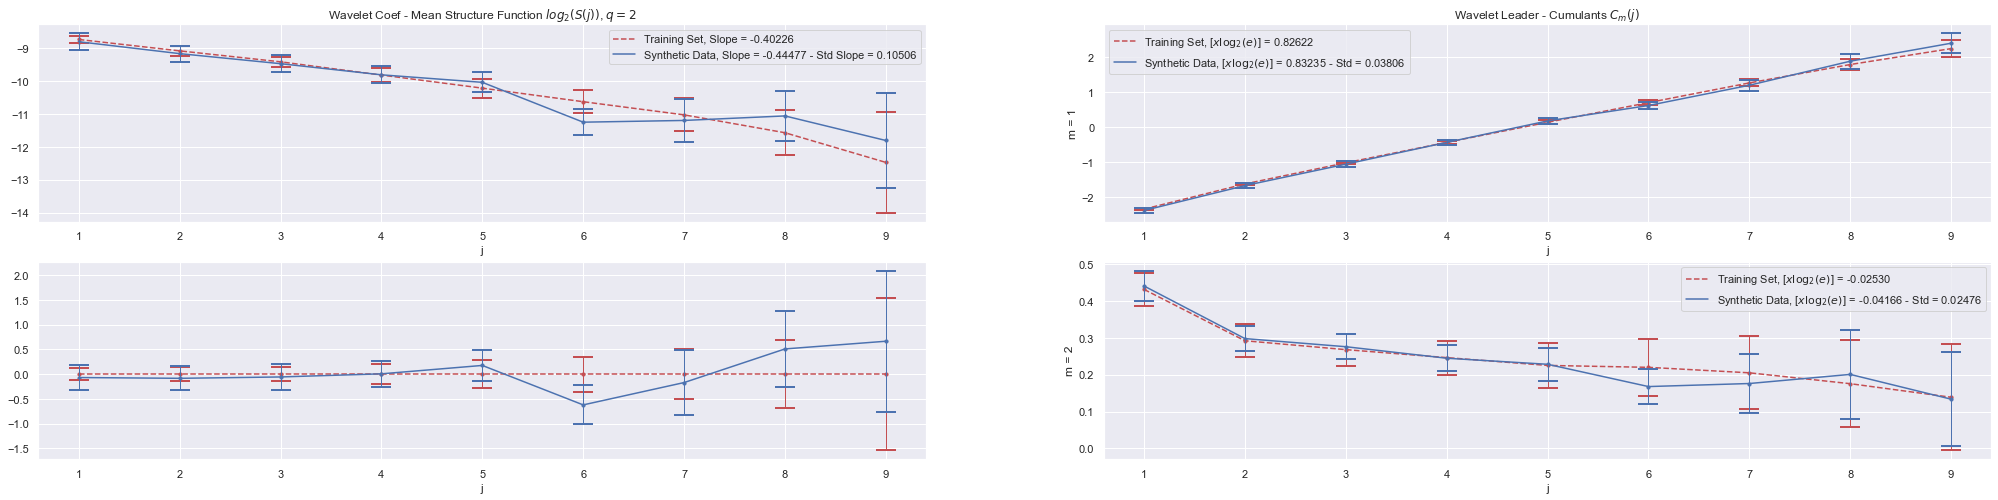

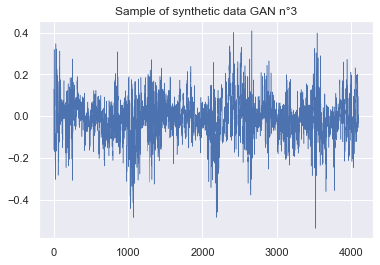

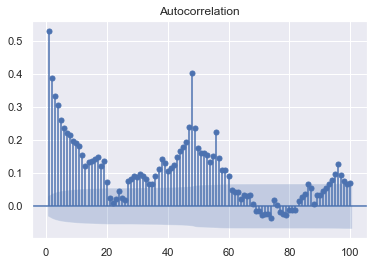

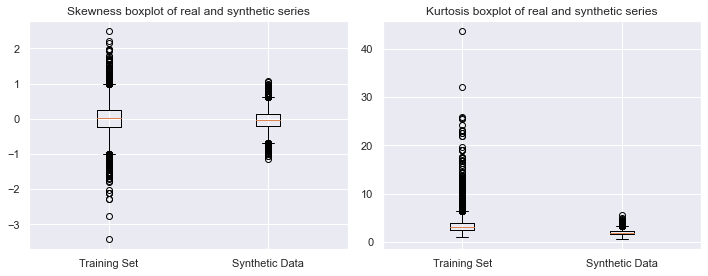

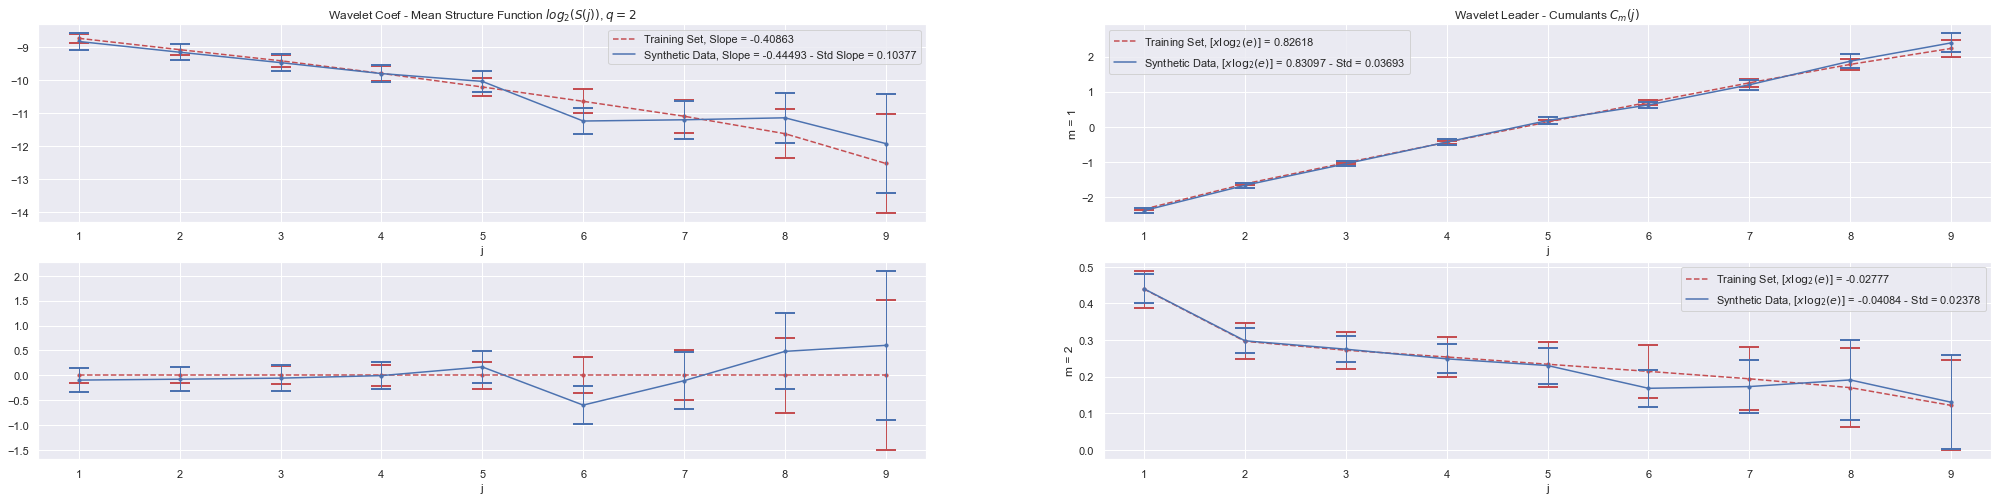

In [37]:
generatorsconv, discriminatorsconv, trainersconv, synthetic_datasconv, plot_result_sfconv, plot_result_mconv = complet_training(n, '2022-07-08_mrw_0.8_0.03_Layer0/conv', '\\training_set_mrw_0.8_0.03.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

In [39]:
data_train = torch.tensor(pd.read_csv(r'data_train\training_set_mrw_0.8_0.03.csv').to_numpy().astype('float32'))    
training_set = data_train[np.random.randint(low = 0, high = data_train.shape[0], size = 10000)]

In [85]:
def hist_comp(synthetic_datas, plot_result_sf, training_set, cmap):
    n = len(synthetic_datas)
    cmap = plt.get_cmap(cmap, 5*n)
    
    tab_H = {'' : ['Mean', 'Std'], 'Data Set' : []}
    tab_C1 = {'' : ['Mean', 'Std'], 'Data Set' : []}
    tab_C2 = {'' : ['Mean', 'Std'], 'Data Set' : []} 

    for i in range (n):
        tab_H.update({'Training ' + str(i+1) : []})
        tab_C1.update({'Training ' + str(i+1) : []})
        tab_C2.update({'Training ' + str(i+1) : []})
    
    #Histogram of H
    print('Histogram of H')
    print('.....')
    plt.figure(1, figsize = (6.1*2, 4*2))
    for i in range (n):
        slope = plot_result_sf[i].wavelet_coef_sync['slope']
        s = []
        for j in range(len(slope)):
            s.append(slope[j].item())
        s = np.array(s)
        mean = plot_result_sf[i].wavelet_slope_synthetic
        std = plot_result_sf[i].wavelet_std_slope_synthetic
        tab_H['Training ' + str(i+1)].extend([mean, std])
        plt.hist(s, bins = 40, density =True, alpha = 1-0.5*i/n, color = cmap(5*(n - i) +1))
        plt.axvline(x=mean, ymin=0, ymax=1, color = cmap(5*(n - i) +1), ls='--')
        print('Training {} - Slope : {} - Std : {}'.format(i+1, mean, std))
        
    slope = plot_result_sf[0].wavelet_coef_data['slope']
    s = []
    for i in range(len(slope)):
        s.append(slope[i].item())
    s = np.array(s)
    mean = plot_result_sf[0].wavelet_slope_data
    std = plot_result_sf[0].wavelet_std_slope_data
    tab_H['Data Set'].extend([mean, std])
    plt.hist(s, bins = 40, density =True, alpha = 0.3, color = 'r')
    plt.axvline(x=mean, ymin=0, ymax=1, color = 'r', ls='--')
    print('Data Set - Slope : {} - Std : {}'.format(mean, std))
    plt.title('Histogram of H', fontsize = 20)
    plt.xticks(fontsize =20)
    plt.yticks(fontsize =20)
    plt.show()
    print('------------------------------------------------------------------------------------------------------')
    
    
    #Histogram of C1
    print('Histogram of C1')
    print('.....')
    plt.figure(2, figsize = (6.1*2, 4*2))
    for i in range (n):
        slope = plot_result_sf[i].cumul_coef_sync['slope1']
        s = []
        for j in range(len(slope)):
            s.append(slope[j].item())
        s = np.array(s)
        mean = plot_result_sf[i].cumul_slope_synthetic[0]
        std = plot_result_sf[i].cumul_std_slope_synthetic[0]
        tab_C1['Training ' + str(i+1)].extend([mean, std])
        plt.hist(s, bins = 40, density =True, alpha = 1-0.5*i/n, color = cmap(5*(n - i) +1))
        plt.axvline(x=mean, ymin=0, ymax=1, color = cmap(5*(n - i) +1), ls='--')
        print('Training {} - Slope : {} - Std : {}'.format(i+1, mean, std))
        
    slope = plot_result_sf[0].cumul_coef_data['slope1']
    s = []
    for i in range(len(slope)):
        s.append(slope[i].item())
    s = np.array(s)
    mean = plot_result_sf[0].cumul_slope_data[0]
    std = plot_result_sf[0].cumul_std_slope_data[0]
    tab_C1['Data Set'].extend([mean, std])
    plt.hist(s, bins = 40, density =True, alpha = 0.3, color = 'r')
    plt.xticks(fontsize =20)
    plt.yticks(fontsize =20)
    plt.axvline(x=mean, ymin=0, ymax=1, color = 'r', ls='--')
    plt.title('Histogram of $C_1$ Coefficients', fontsize = 20)
    print('Data Set - Slope : {} - Std : {}'.format(mean, std))
    plt.show()
    
    print('------------------------------------------------------------------------------------------------------')
    
    
    #Histogram of C2
    print('Histogram of C2')
    print('.....')
    plt.figure(3, figsize = (6.1*2, 4*2))
    for i in range (n):
        slope = plot_result_sf[i].cumul_coef_sync['slope2']
        s = []
        for j in range(len(slope)):
            s.append(slope[j].item())
        s = np.array(s)
        mean = plot_result_sf[i].cumul_slope_synthetic[1]
        std = plot_result_sf[i].cumul_std_slope_synthetic[1]
        tab_C2['Training ' + str(i+1)].extend([mean, std])
        plt.hist(s, bins = 40, density =True, alpha = 1-0.5*i/n, color = cmap(5*(n - i) +1))
        plt.axvline(x=mean, ymin=0, ymax=1, color = cmap(5*(n - i) +1), ls='--')
        print('Training {} - Slope : {} - Std : {}'.format(i+1, mean, std))
        
    slope = plot_result_sf[0].cumul_coef_data['slope2']
    s = []
    for i in range(len(slope)):
        s.append(slope[i].item())
    s = np.array(s)
    mean = plot_result_sf[0].cumul_slope_data[1]
    std = plot_result_sf[0].cumul_std_slope_data[1]
    tab_C2['Data Set'].extend([mean, std])
    plt.hist(s, bins = 40, density =True, alpha = 0.3, color = 'r')
    plt.axvline(x=mean, ymin=0, ymax=1, color = 'r', ls='--')
    print('Data Set - Slope : {} - Std : {}'.format(mean, std))
    plt.title('Histogram of $C_2$ Coefficients', fontsize = 20)
    plt.xticks(fontsize =20)
    plt.yticks(fontsize =20)
    plt.show()
    print('------------------------------------------------------------------------------------------------------')
    
    tab_H = pd.DataFrame(tab_H)
    tab_C1 = pd.DataFrame(tab_C1)
    tab_C2 = pd.DataFrame(tab_C2)
    print(tab_H.to_latex(index=False))
    print('------------------------------------------------------------------------------------------------------')
    print(tab_C1.to_latex(index=False))
    print('------------------------------------------------------------------------------------------------------')
    print(tab_C2.to_latex(index=False))
    print('------------------------------------------------------------------------------------------------------')

In [86]:
def function_plot(plot_result_sf, cmap):
    n = len(plot_result_sf)
    cmap = plt.get_cmap(cmap, 5*n)
    
    j = plot_result_sf[0].j
    
    # Wavelet Coef - Comparison Synthetic Structure Function
    plt.figure(1, figsize = (6.1*2, 4*2))
    for i in range (n):
        plt.plot(j + 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], color = cmap(5*(n - i) +1))
        plt.scatter(j + 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], color = cmap(5*(n - i) +1),s=10)
        plt.errorbar(j+ 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], yerr = plot_result_sf[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5*(n - i) +1), elinewidth = 1, capthick = 2)
        
        print('Training {} - Slope : {} - Std : {}'.format(i+1, plot_result_sf[0].wavelet_slope_synthetic, plot_result_sf[0].wavelet_std_slope_synthetic))
        
    #trainsing set 
    plt.plot(j, plot_result_sf[0].wavelet_result_data[0], 'r--')
    plt.scatter(j, plot_result_sf[0].wavelet_result_data[0], color = 'r',s=10)
    plt.errorbar(j, plot_result_sf[0].wavelet_result_data[0], yerr = plot_result_sf[0].wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
    print('Data Set - Slope : {} - Std : {}'.format(plot_result_sf[0].wavelet_slope_data, plot_result_sf[0].wavelet_std_slope_data))
    plt.xlabel('j', fontsize = 20)
    plt.title('Wavelet Coef - Mean Structure Function $log_2(S(j))$, $q=2$', fontsize = 20)
    plt.xticks(fontsize =20)
    plt.yticks(fontsize =20)
    plt.show()
    print('------------------------------------------------------------------------------------------------------')
    
    
    # Wavelet Coef - Comparison Synthetic Structure Function
    plt.figure(2, figsize = (6.1*2, 4*2))
    for i in range (n):
        plt.plot(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], color = cmap(5*(n - i) +1))
        plt.scatter(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], color = cmap(5*(n - i) +1),s=10)
        plt.errorbar(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], yerr = plot_result_sf[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5*(n - i) +1), elinewidth = 1, capthick = 2)
        
        print('Training {} - Slope : {} - Std : {}'.format(i+1, plot_result_sf[i].cumul_slope_synthetic[1], plot_result_sf[i].cumul_std_slope_synthetic[1]))
        
    #trainsing set 
    plt.plot(j, plot_result_sf[0].cumul_result2_data[0], 'r--')
    plt.scatter(j, plot_result_sf[0].cumul_result2_data[0], color = 'r',s=10)
    plt.errorbar(j, plot_result_sf[0].cumul_result2_data[0], yerr = plot_result_sf[0].cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
    print('Data Set - Slope : {} - Std : {}'.format(plot_result_sf[0].cumul_slope_data[1], plot_result_sf[0].cumul_std_slope_data[1]))
    plt.xlabel('j', fontsize = 20)
    plt.title('Wavelet Leader - Cumulants $C_2 (j)$', fontsize = 20)
    plt.xticks(fontsize =20)
    plt.yticks(fontsize =20)
    plt.show()

    print('------------------------------------------------------------------------------------------------------')
    

Histogram of H
.....
Training 1 - Slope : -0.34647123891414544 - Std : 0.09497163707165583
Training 2 - Slope : -0.4276514984534658 - Std : 0.0933270894430033
Training 3 - Slope : -0.44493259783894684 - Std : 0.1037742143400694
Data Set - Slope : -0.410459227955361 - Std : 0.08473259211925672


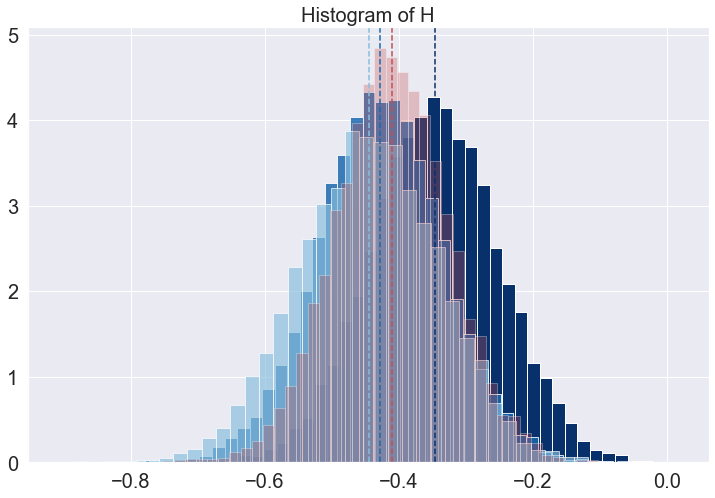

------------------------------------------------------------------------------------------------------
Histogram of C1
.....
Training 1 - Slope : 0.8562900328191777 - Std : 0.03534346899682125
Training 2 - Slope : 0.8370108247804199 - Std : 0.03277551305359715
Training 3 - Slope : 0.8309707407290329 - Std : 0.0369258921183826
Data Set - Slope : 0.825801805192812 - Std : 0.028783832607829456


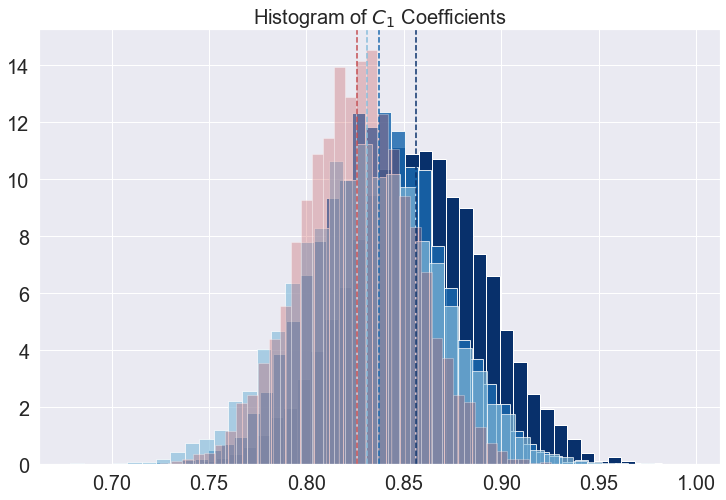

------------------------------------------------------------------------------------------------------
Histogram of C2
.....
Training 1 - Slope : -0.033108538695482415 - Std : 0.022899754156689045
Training 2 - Slope : -0.04298950724685376 - Std : 0.022554040700078385
Training 3 - Slope : -0.0408428828105888 - Std : 0.0237837628408404
Data Set - Slope : -0.027565706625483632 - Std : 0.022139523115095122


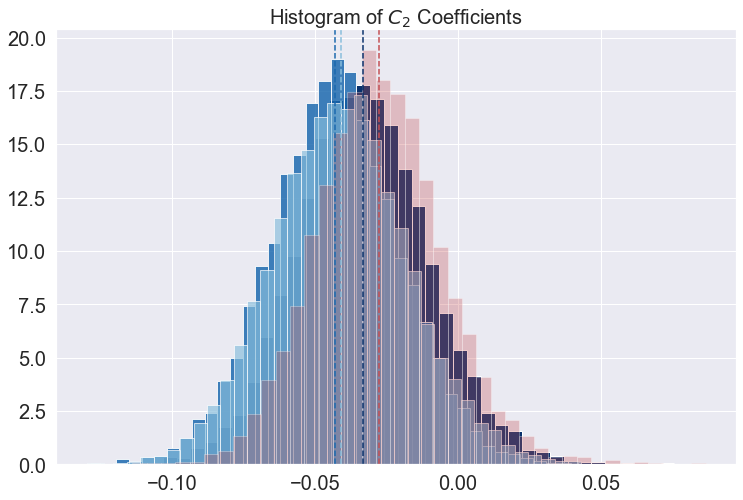

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean & -0.410459 &   -0.346471 &   -0.427651 &   -0.444933 \\
 Std &  0.084733 &    0.094972 &    0.093327 &    0.103774 \\
\bottomrule
\end{tabular}

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean &  0.825802 &    0.856290 &    0.837011 &    0.830971 \\
 Std &  0.028784 &    0.035343 &    0.032776 &    0.036926 \\
\bottomrule
\end{tabular}

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean & -0.027566 &   -0.033109 &   -0.042990 &   -0.040843 \\
 Std &  0.022140 &

In [87]:
hist_comp(synthetic_datasconv, plot_result_sfconv, training_set, 'Blues')

Training n°1 - Slope : -0.34647123891414544 - Std : 0.09497163707165583
Training n°2 - Slope : -0.34647123891414544 - Std : 0.09497163707165583
Training n°3 - Slope : -0.34647123891414544 - Std : 0.09497163707165583
Training Set - Slope : -0.410459227955361 - Std : 0.08473259211925672


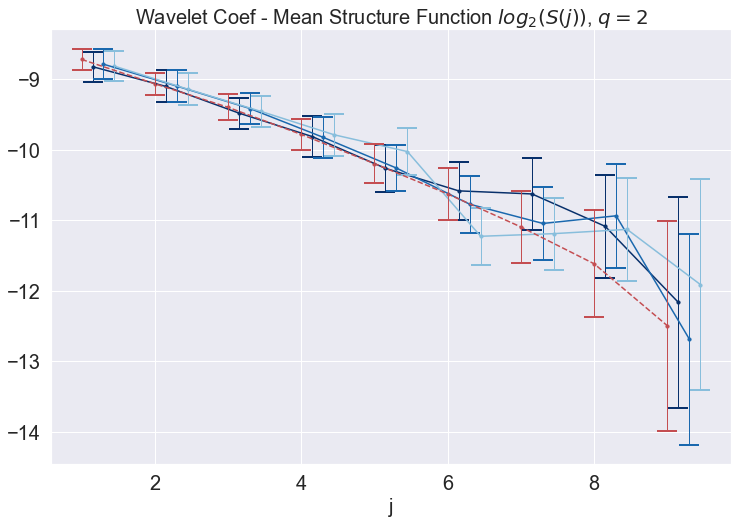

------------------------------------------------------------------------------------------------------
Training n°1 - Slope : -0.033108538695482415 - Std : 0.022899754156689045
Training n°2 - Slope : -0.04298950724685376 - Std : 0.022554040700078385
Training n°3 - Slope : -0.0408428828105888 - Std : 0.0237837628408404
Training Set - Slope : -0.027565706625483632 - Std : 0.022139523115095122


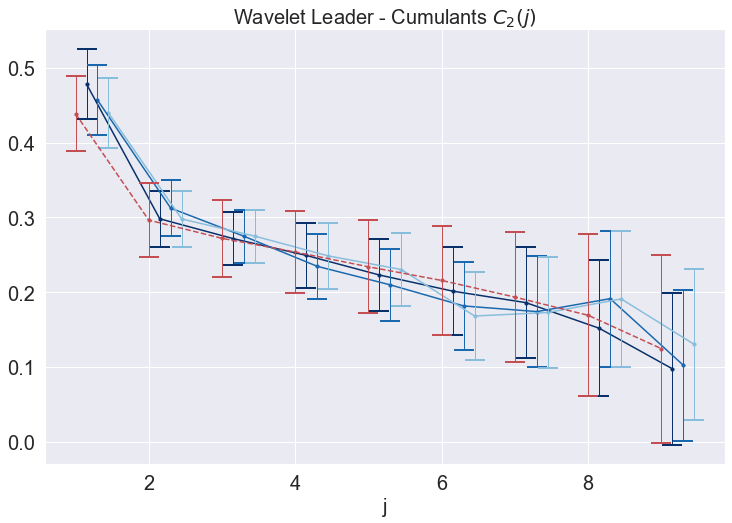

------------------------------------------------------------------------------------------------------


In [82]:
function_plot(plot_result_sfconv, 'Blues')

In [14]:
def plot_comp(plot_result_sf1, plot_result_sf2):
    n = len(plot_result_sf)
    cmap = plt.get_cmap(cmap, 5*n)
    j = plot_result_sf[0].j
    
    #compilation of the results 
    
    

    
    # Wavelet Coef - Comparison Synthetic Structure Function
    plt.figure(1)
    for i in range (n):
        plt.plot(j + 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], color = cmap(5*(n - i) +1))
        plt.scatter(j + 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], color = cmap(5*(n - i) +1),s=10)
        plt.errorbar(j+ 0.15*(i+1), plot_result_sf[i].wavelet_result_synthetic[0], yerr = plot_result_sf[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5*(n - i) +1), elinewidth = 1, capthick = 2)
        
        print('Training n°{} - Slope : {} - Std : {}'.format(i+1, plot_result_sf[0].wavelet_slope_synthetic, plot_result_sf[0].wavelet_std_slope_synthetic))
        
    #trainsing set 
    plt.plot(j, plot_result_sf[0].wavelet_result_data[0], 'r--')
    plt.scatter(j, plot_result_sf[0].wavelet_result_data[0], color = 'r',s=10)
    plt.errorbar(j, plot_result_sf[0].wavelet_result_data[0], yerr = plot_result_sf[0].wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
    print('Training Set - Slope : {} - Std : {}'.format(plot_result_sf[0].wavelet_slope_data, plot_result_sf[0].wavelet_std_slope_data))
    plt.xlabel('j')
    plt.title('Wavelet Coef - Mean Structure Function $log_2(S(j))$, $q=2$')
    plt.show()
    print('------------------------------------------------------------------------------------------------------')
    
    
    # Wavelet Coef - Comparison Synthetic Structure Function
    plt.figure(1)
    for i in range (n):
        plt.plot(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], color = cmap(5*(n - i) +1))
        plt.scatter(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], color = cmap(5*(n - i) +1),s=10)
        plt.errorbar(j + 0.15*(i+1), plot_result_sf[i].cumul_result2_synthetic[0], yerr = plot_result_sf[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5*(n - i) +1), elinewidth = 1, capthick = 2)
        
        print('Training n°{} - Slope : {} - Std : {}'.format(i+1, plot_result_sf[i].cumul_slope_synthetic[1], plot_result_sf[i].cumul_std_slope_synthetic[1]))
        
    #trainsing set 
    plt.plot(j, plot_result_sf[0].cumul_result2_data[0], 'r--')
    plt.scatter(j, plot_result_sf[0].cumul_result2_data[0], color = 'r',s=10)
    plt.errorbar(j, plot_result_sf[0].cumul_result2_data[0], yerr = plot_result_sf[0].cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
    print('Training Set - Slope : {} - Std : {}'.format(plot_result_sf[0].cumul_slope_data[1], plot_result_sf[0].cumul_std_slope_data[1]))
    plt.xlabel('j')
    plt.title('Wavelet Leader - Cumulants $C_2 (j)$')
    plt.show()

    print('------------------------------------------------------------------------------------------------------')

In [63]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.Layer0 = nn.Linear(self.latent_dim, self.latent_dim)
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        self.f = btanha()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.Layer0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], 8, x.shape[2]//8)

        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch3(self.conv3(x))
        x = x.squeeze()
        return self.f(x)

In [16]:
def complet_training2(n, savepath, namepath, latent_dim, ts_dim, epochs, device):
    generators = []
    discriminators = []
    trainers = []
    synthetic_datas = []
    plot_result_sf = []
    plot_result_m = []
    
    # Create Scorepath
    scorepath = os.path.join(r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output',savepath)
    if not os.path.exists(scorepath):
        os.makedirs(scorepath)
    
    # Init parameters
    lr_a = 1e-4
    lr_b = 1e-4
    
    # Exportation true data
    true_data = torch.tensor(pd.read_csv('data_train' + namepath).to_numpy().astype('float32')).to(device)
    
    for i in range (n):
        
        print('.....')
        print('New Training')
        print('.....')
        
        data_train = true_data[np.random.randint(low = 0, high = true_data.cpu().shape[0], size = 10000)]
        
        generator = Generator(latent_dim).to(device)
        discriminator = Discriminator(ts_dim = ts_dim).to(device)
        
        # Init optimizers
        G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
        D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

        # Training
        path = os.path.join(scorepath, 'Training n° ' + str(i+1)) 
        if not os.path.exists(path):
            os.makedirs(path)
        train = Trainer(generator, discriminator, G_opt, D_opt, batch_size, latent_dim, ts_dim, data_train, device, path)
        train.train(epochs=epochs)
        
        # Save models
        noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim)).to(device)
        synthetic_data = generator(noise).cpu()
        with torch.no_grad():
            x = synthetic_data[np.random.randint(low = 0, high = 10000)]
            plt.plot(x, linewidth = 0.5)
            plt.title('Sample of synthetic data GAN n°' + str(i+1))
            plt.show()
            sm.graphics.tsa.plot_acf(x.detach().numpy(), lags=100, zero = False)
            plt.show()
 
        plot_analysis_m = Analysis_m(data_train, synthetic_data, path)
        plot_analysis_sf = Analysis_sf(data_train, synthetic_data, path)
        plot_analysis_m.dataFrame()
        plot_analysis_m.boxplot()
        plot_analysis_sf.plot()
        df_data, df_synthetic = plot_analysis_sf.dataFrame()
        
        generators.append(generator.cpu())
        discriminators.append(discriminator.cpu())
        trainers.append(train)
        synthetic_datas.append(synthetic_data.cpu())
        plot_result_sf.append(plot_analysis_sf)
        plot_result_m.append(plot_analysis_m)
        
    return generators, discriminators, trainers, synthetic_datas, plot_result_sf, plot_result_m

.....
New Training
.....


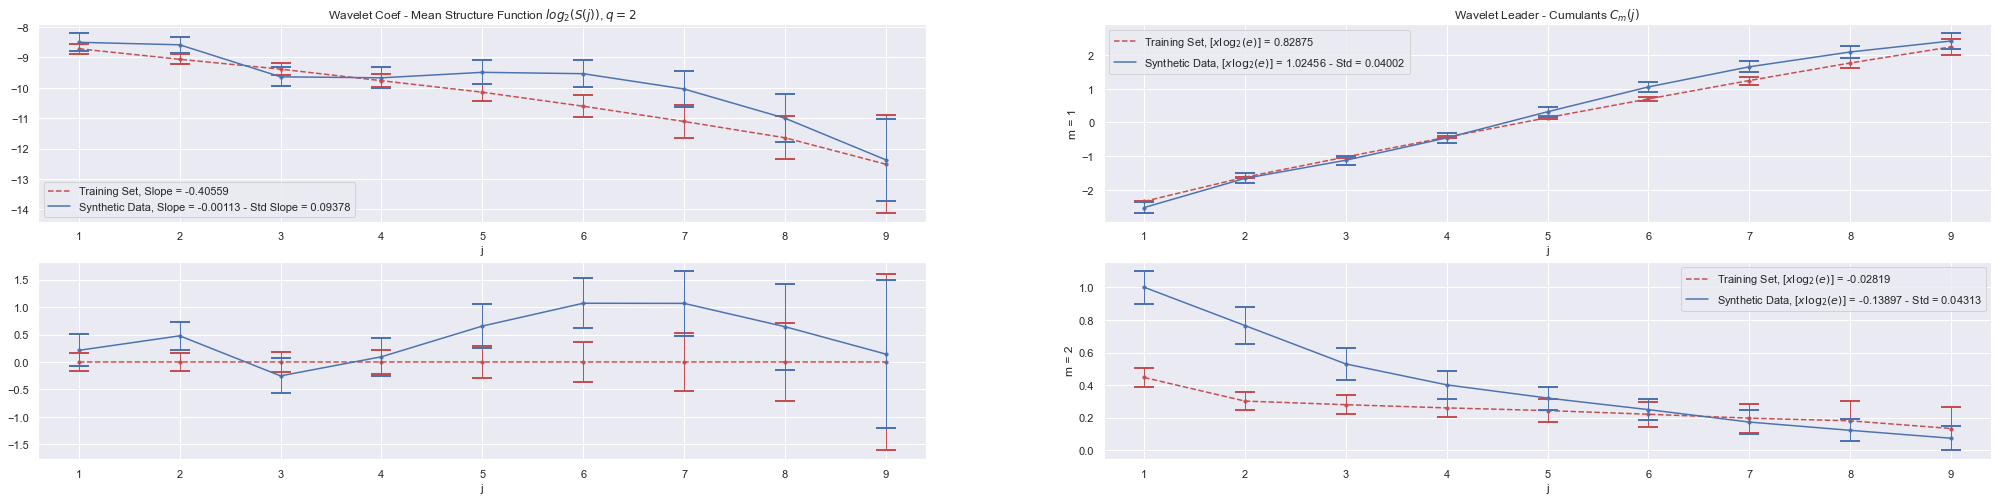

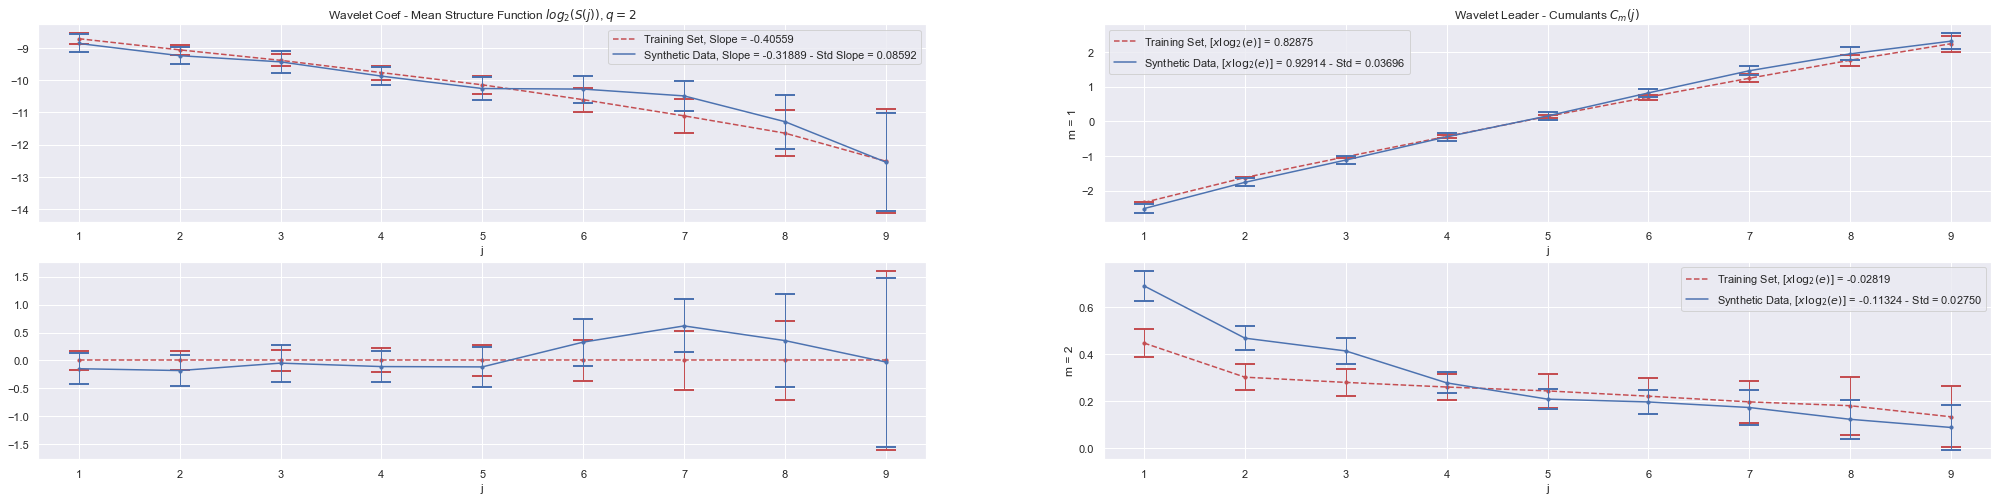

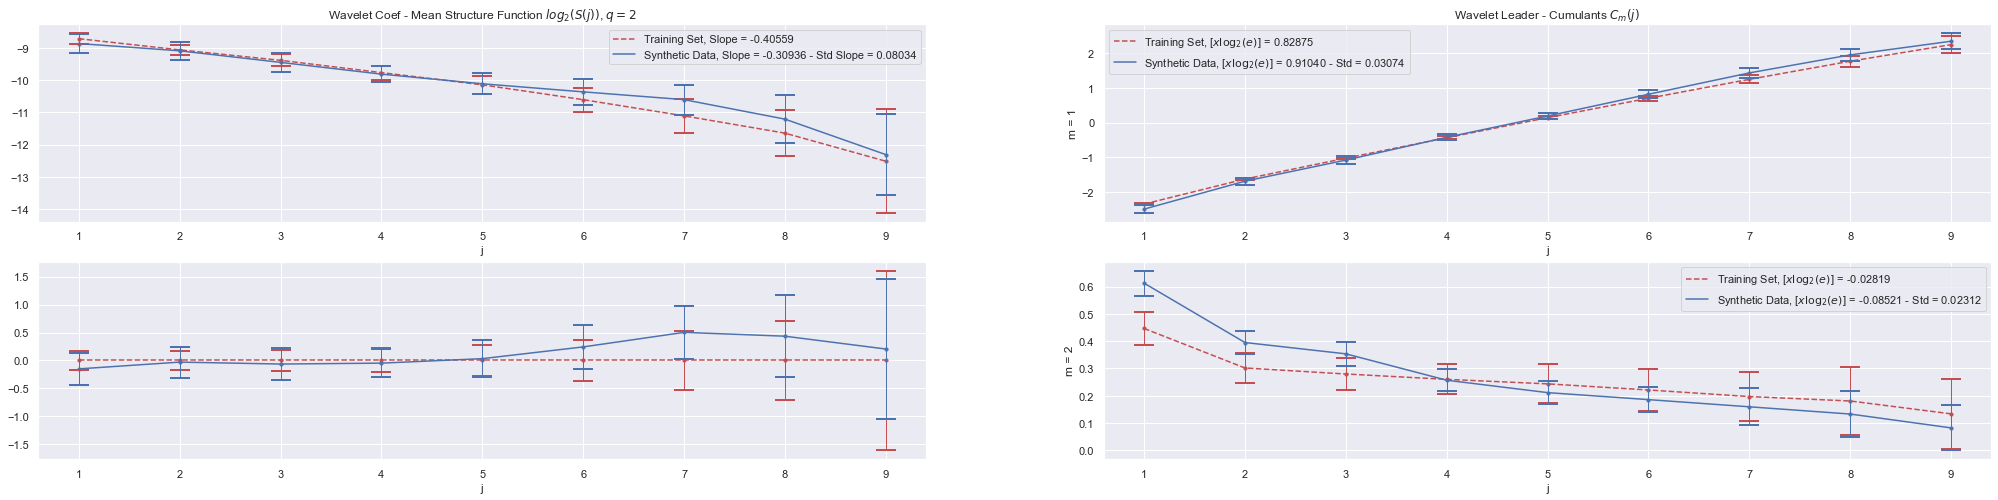

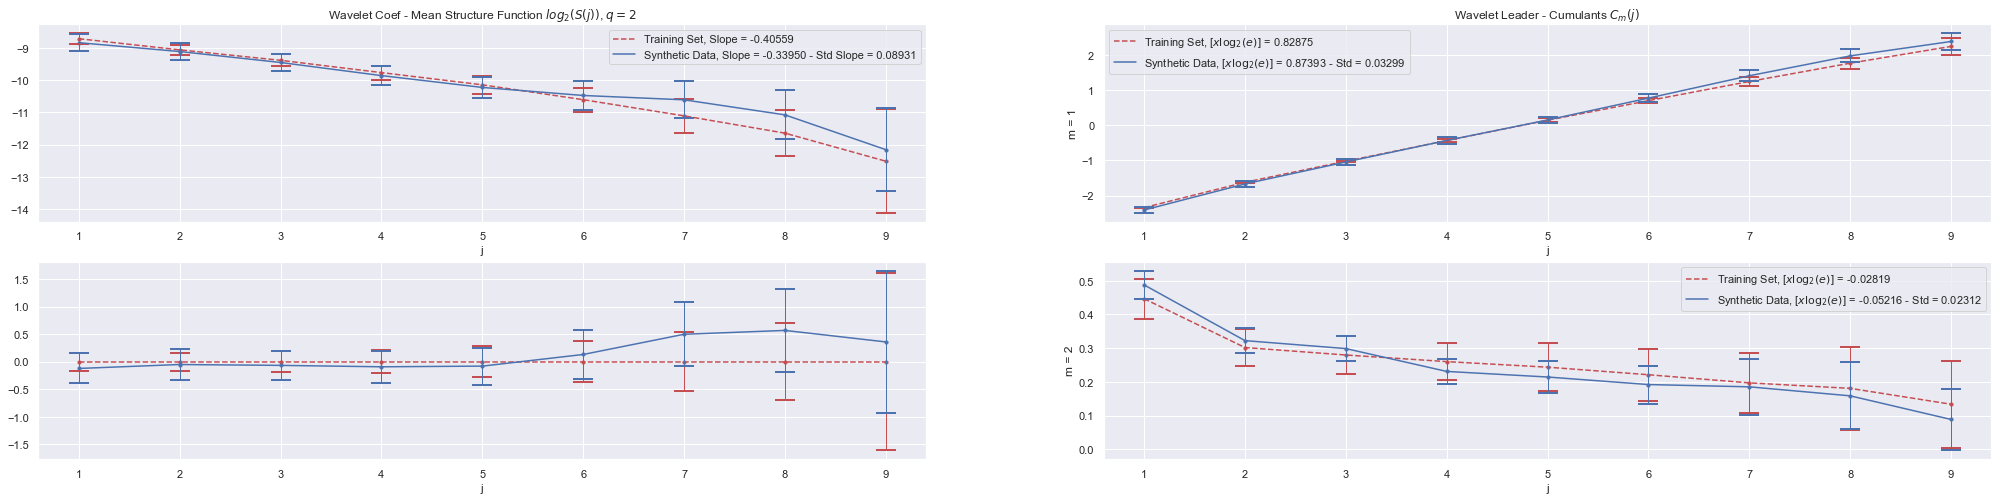

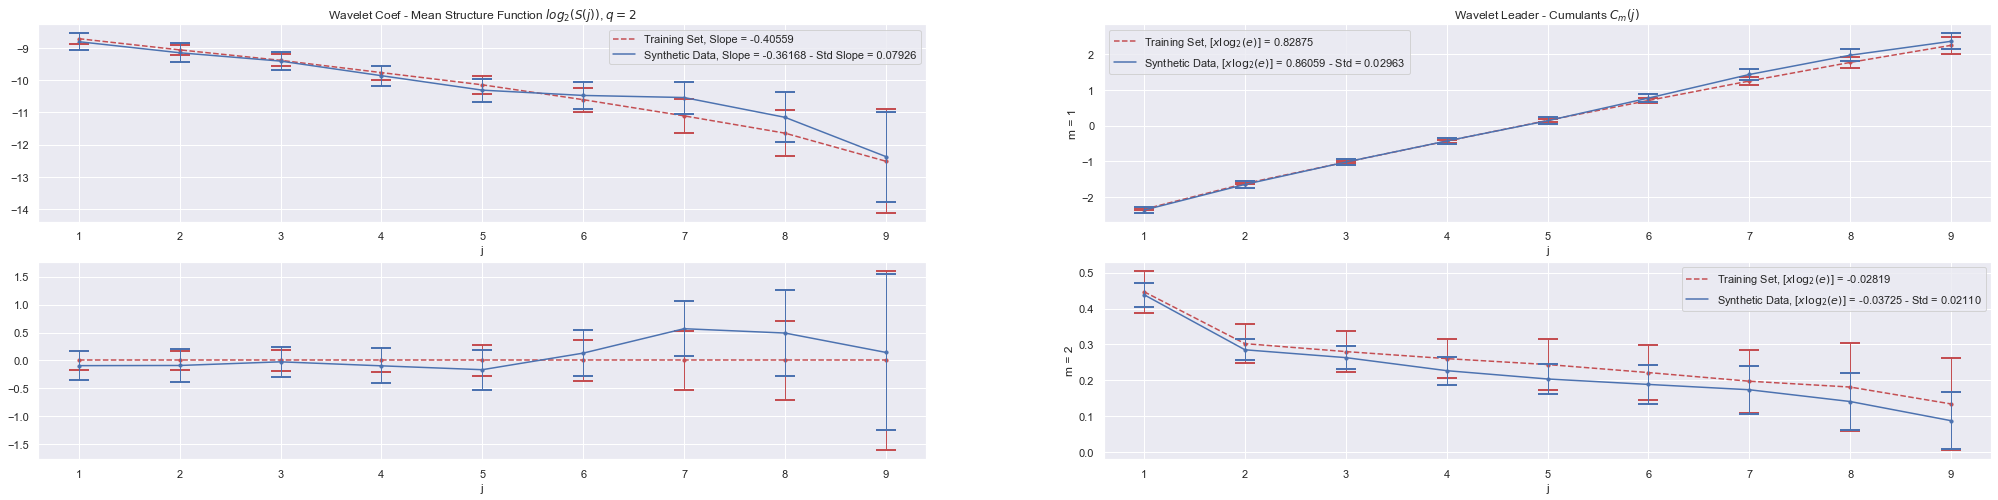

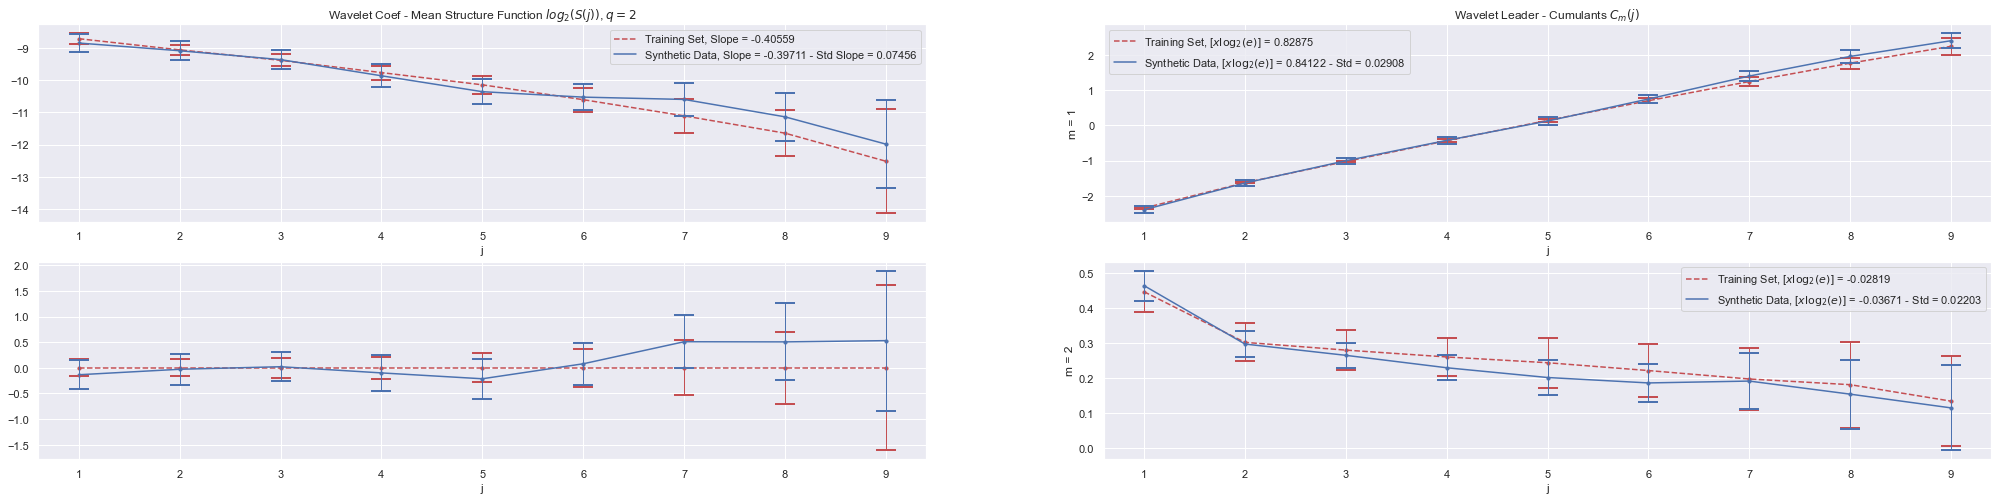

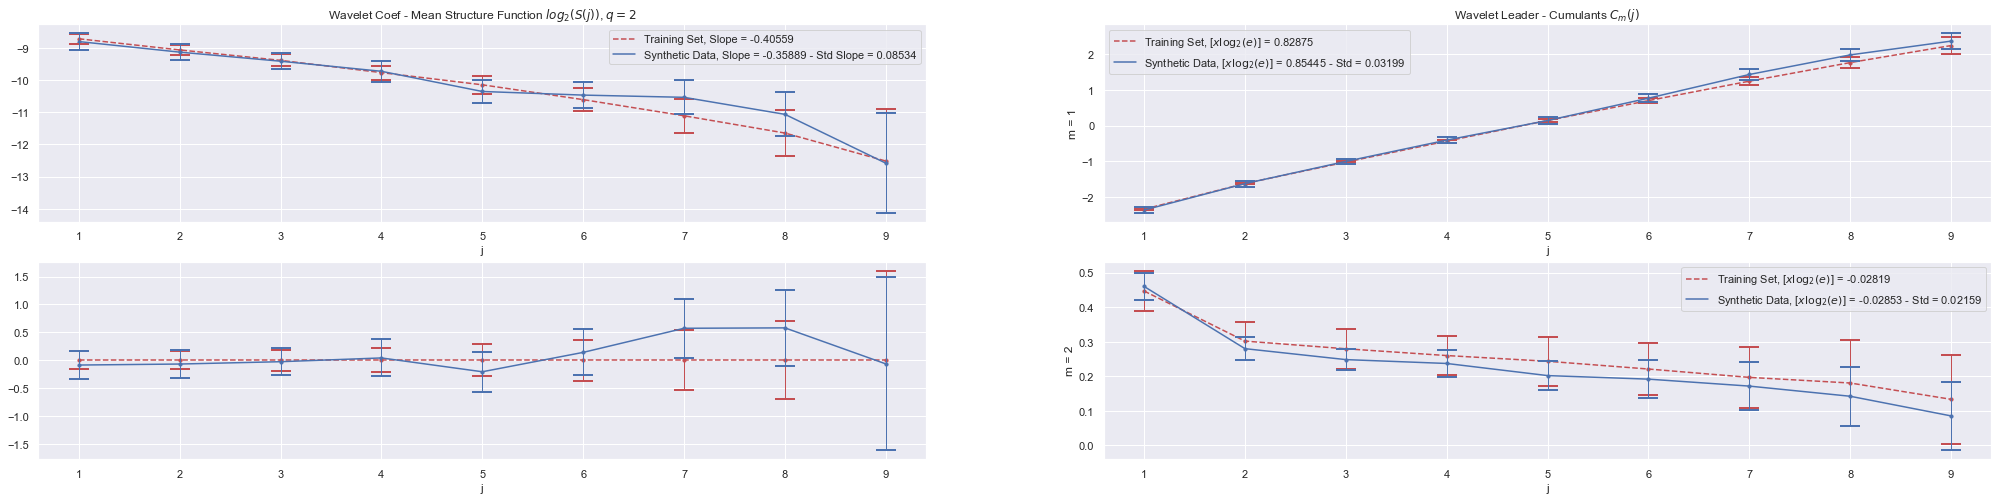

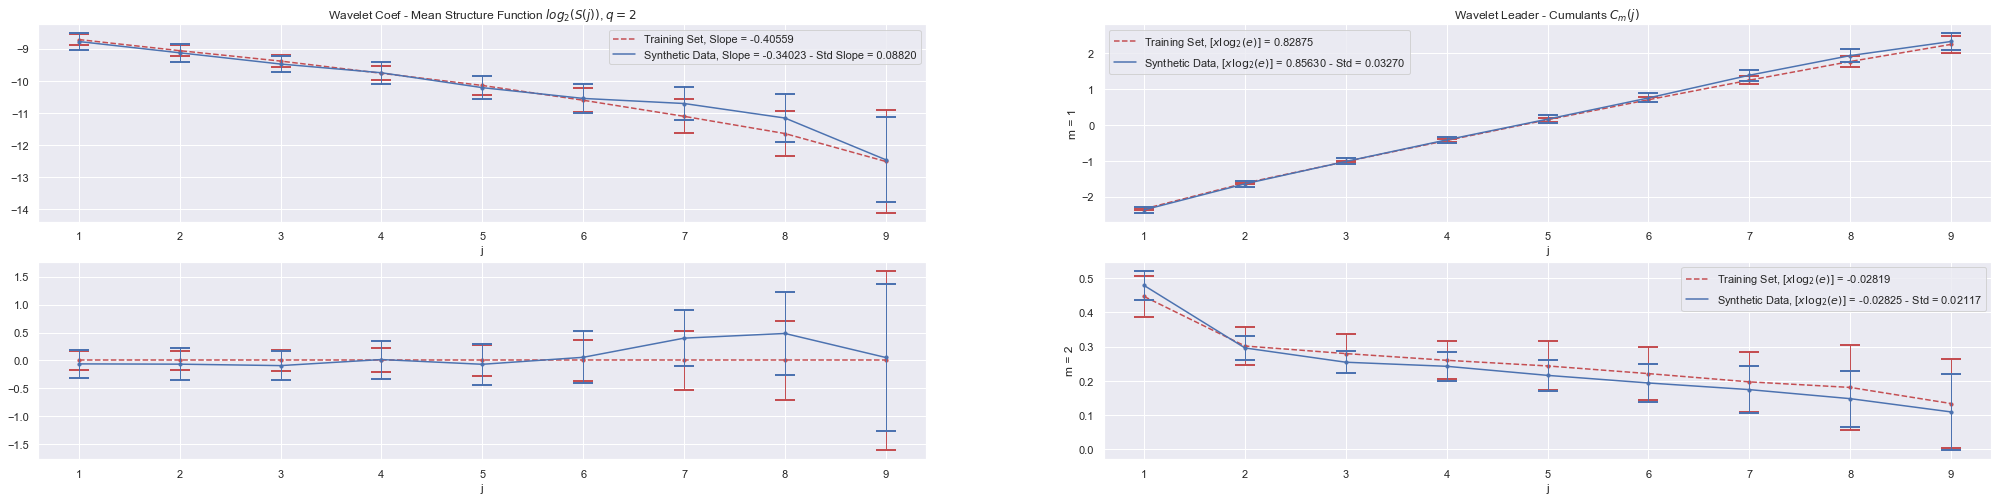

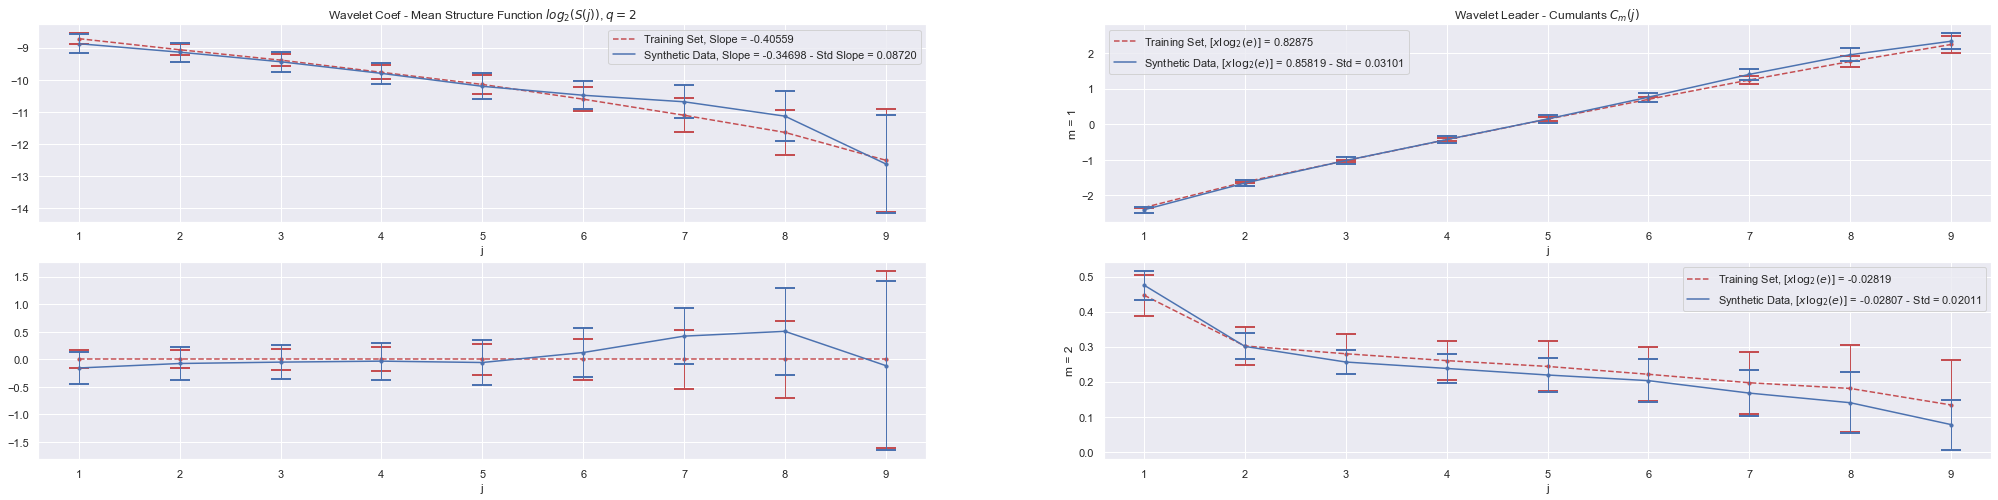

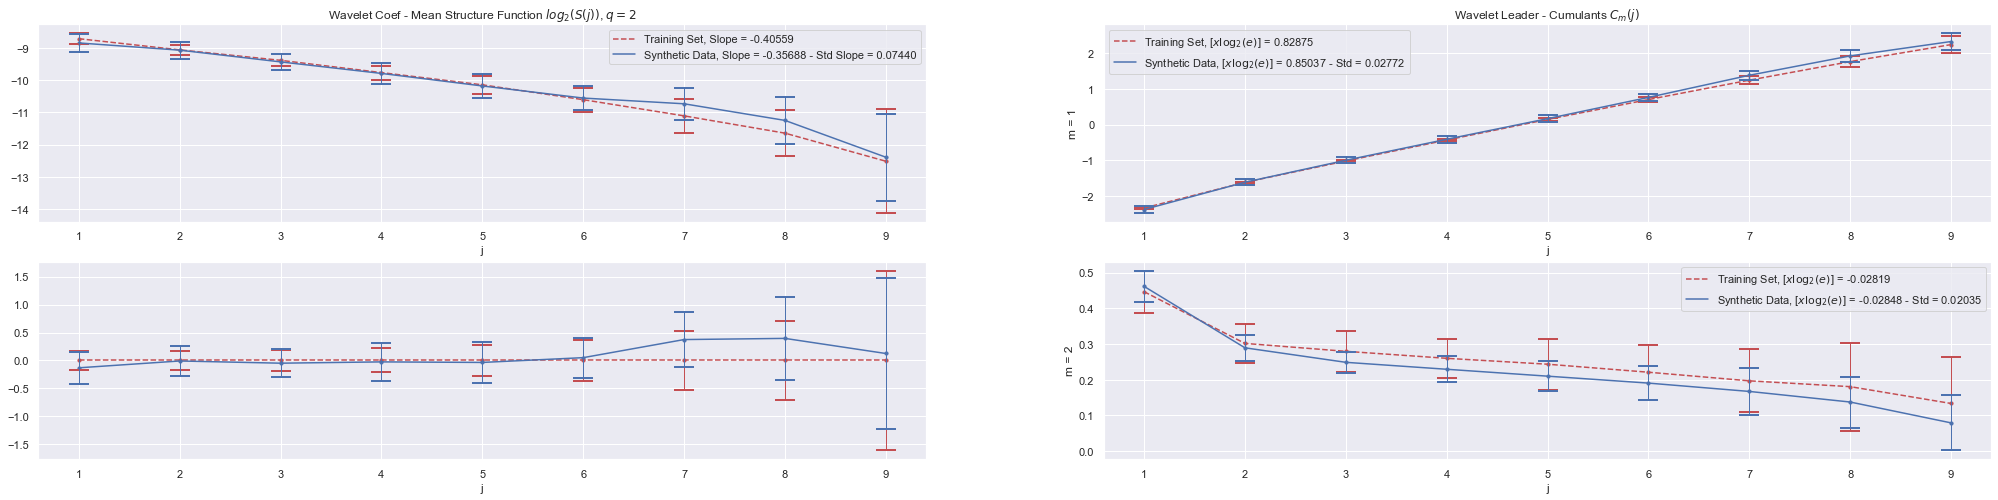

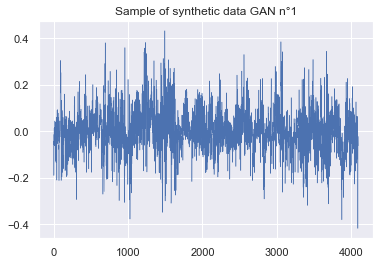

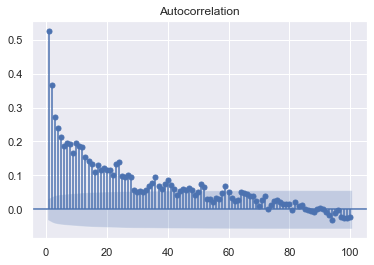

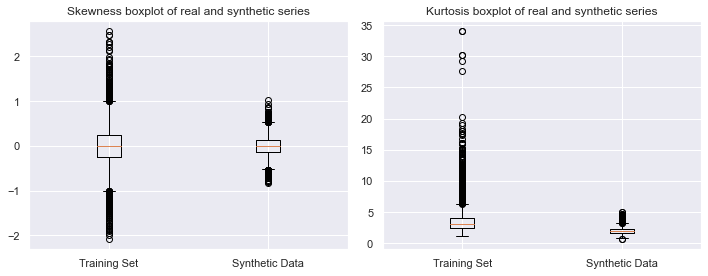

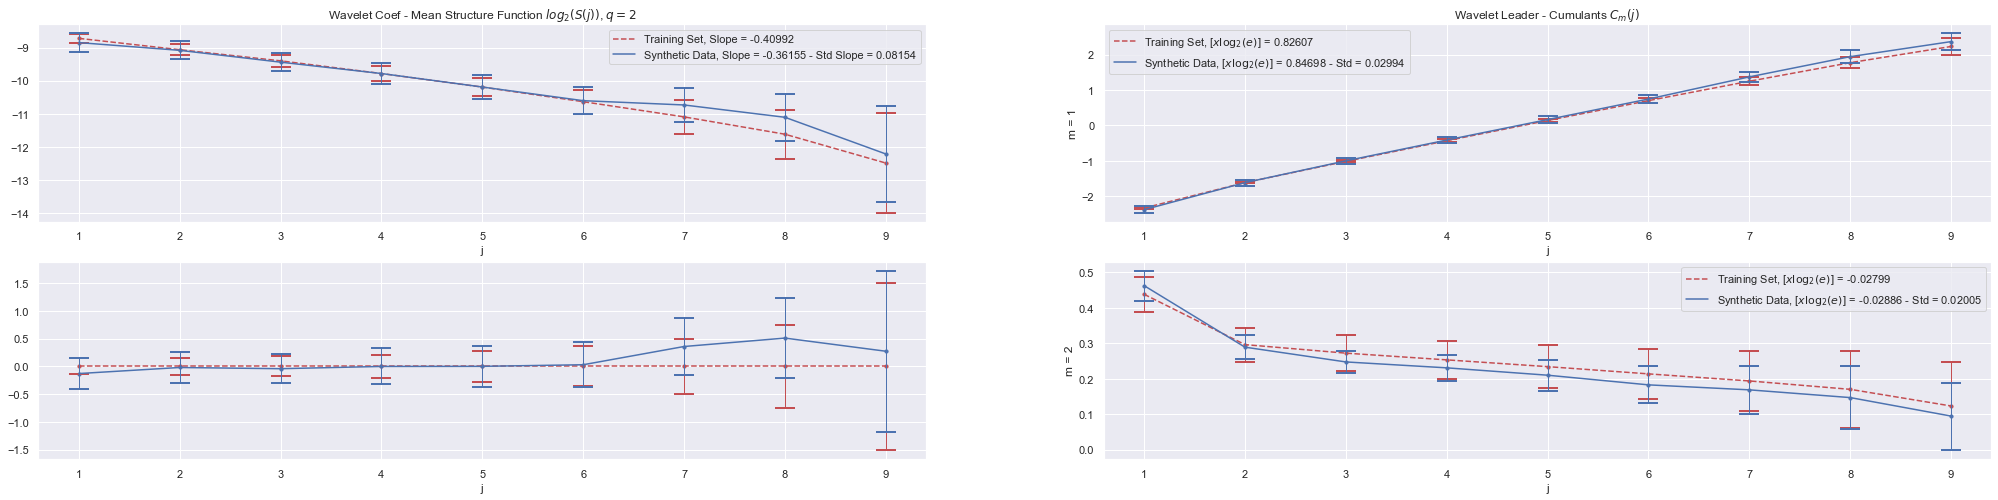

.....
New Training
.....


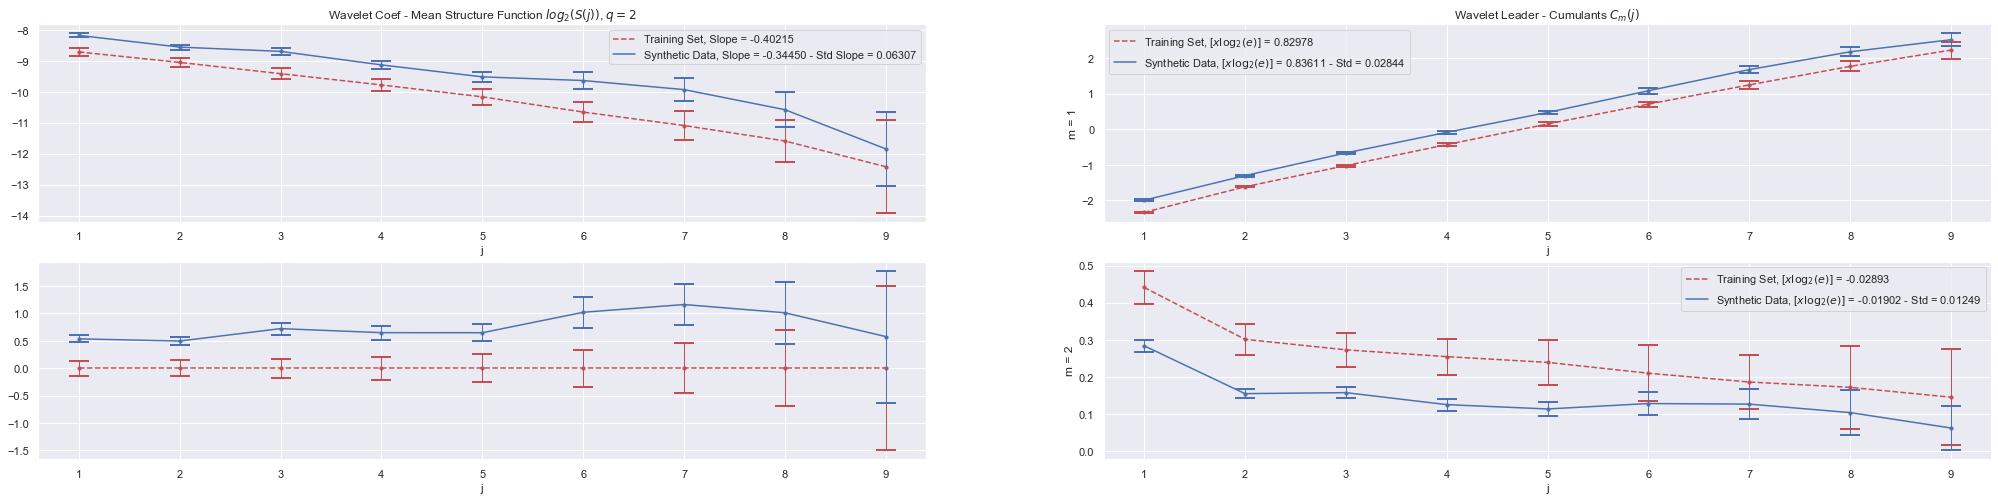

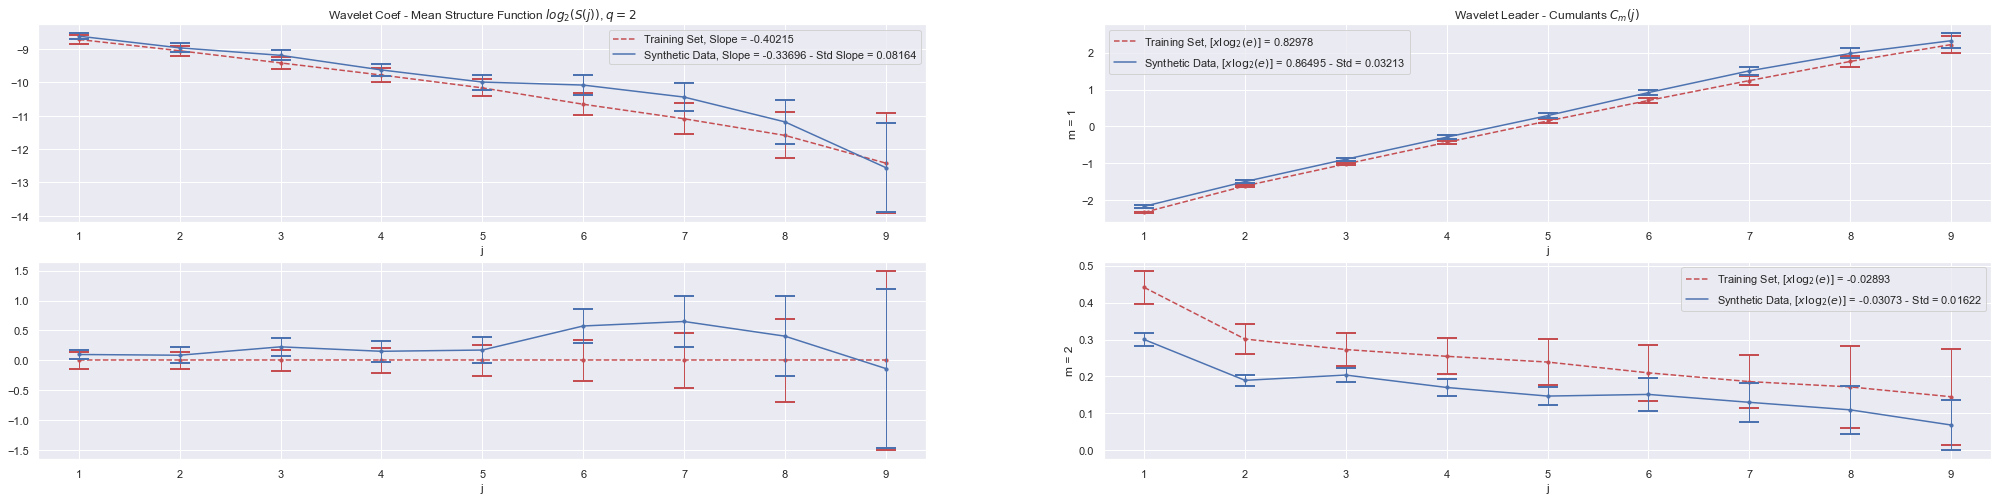

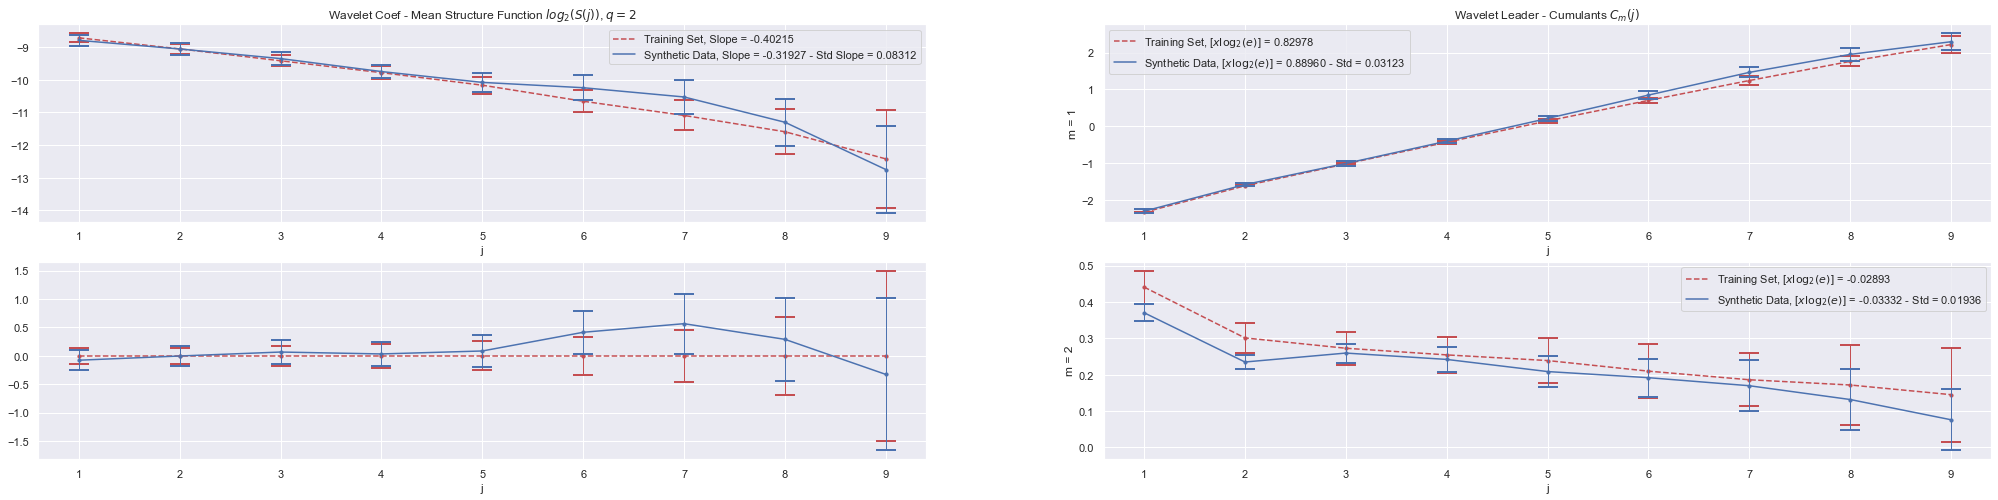

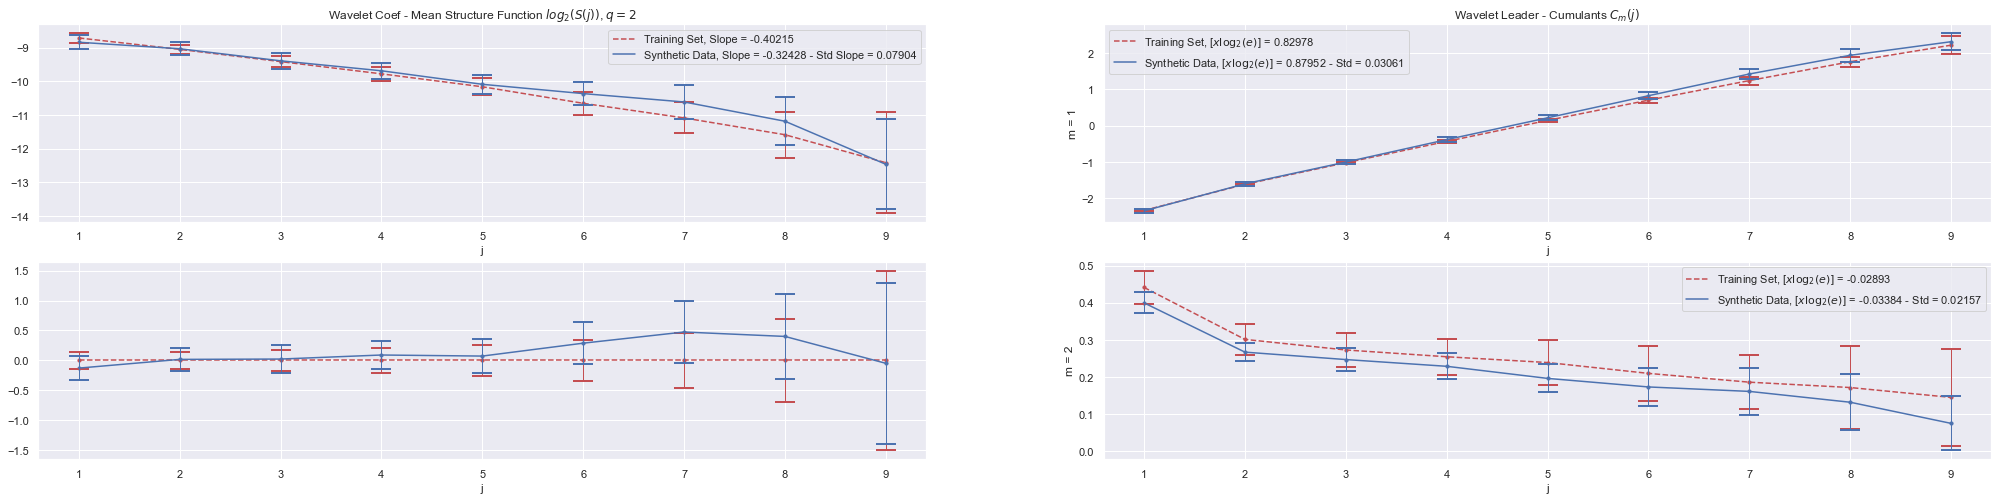

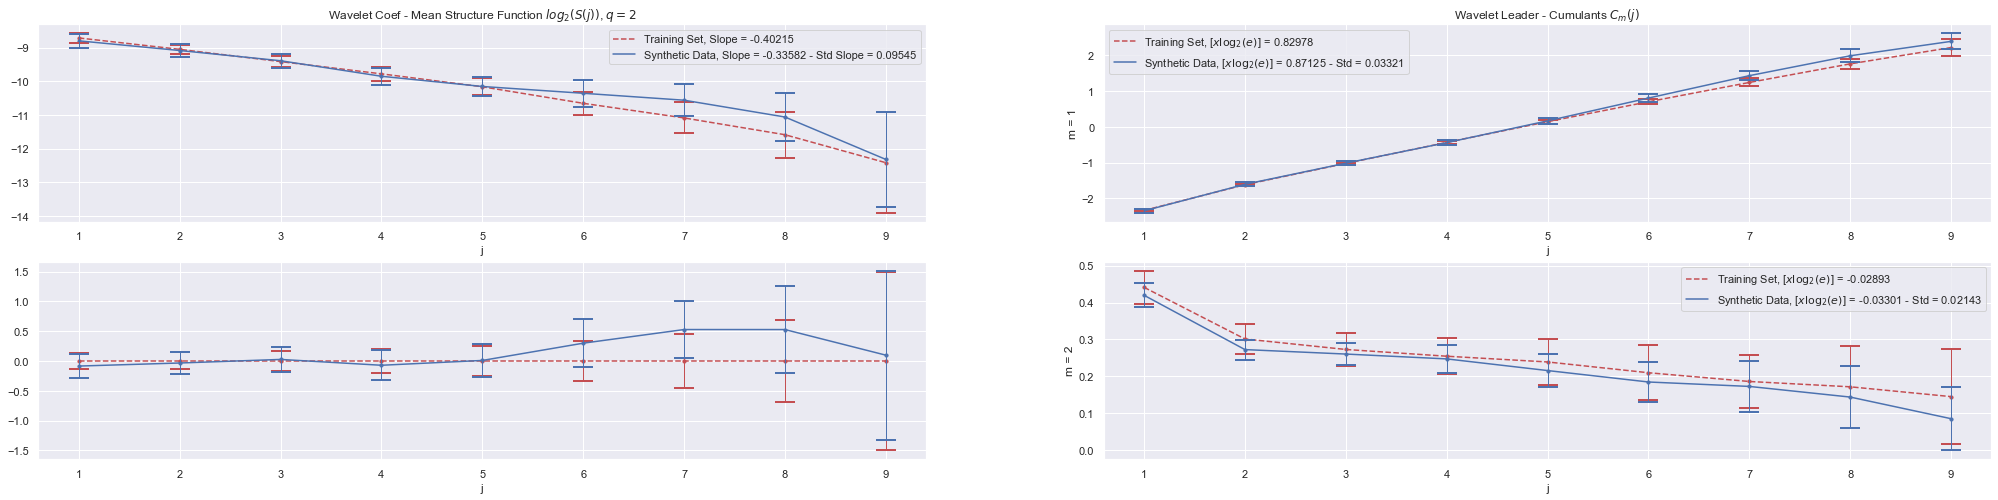

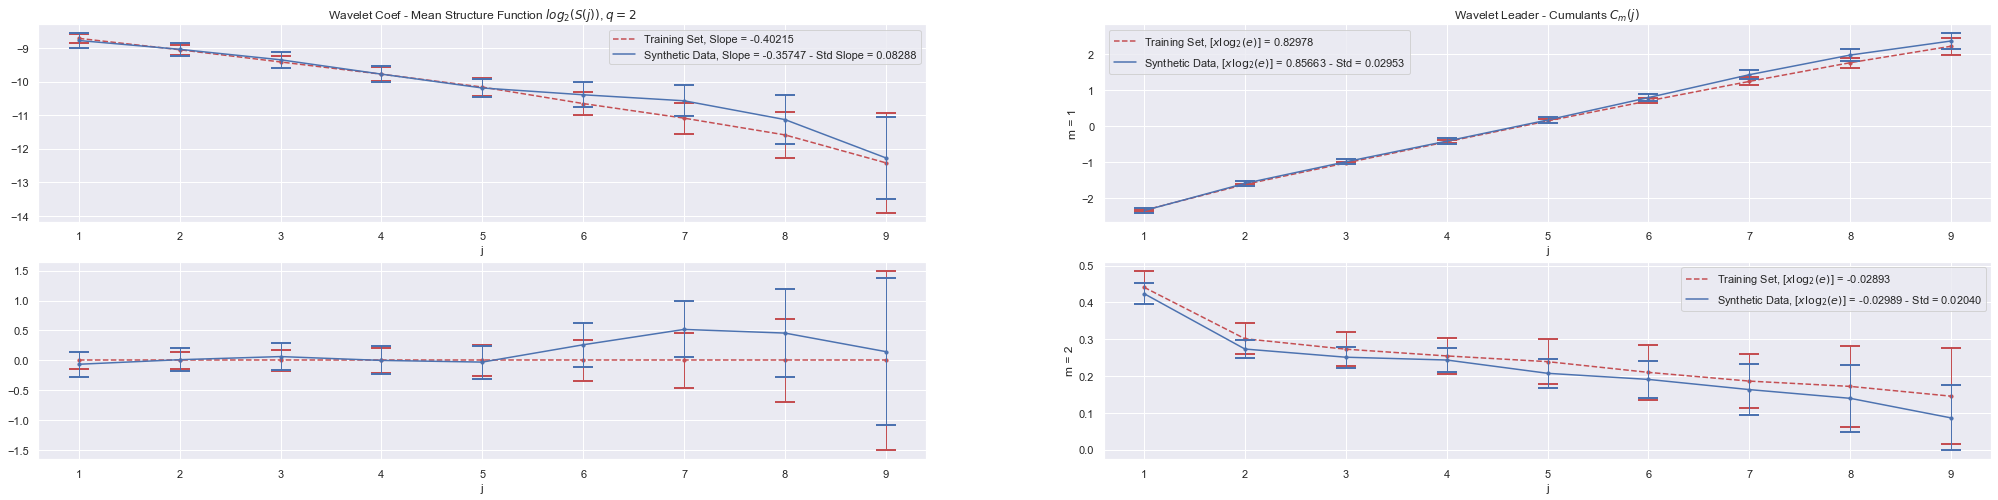

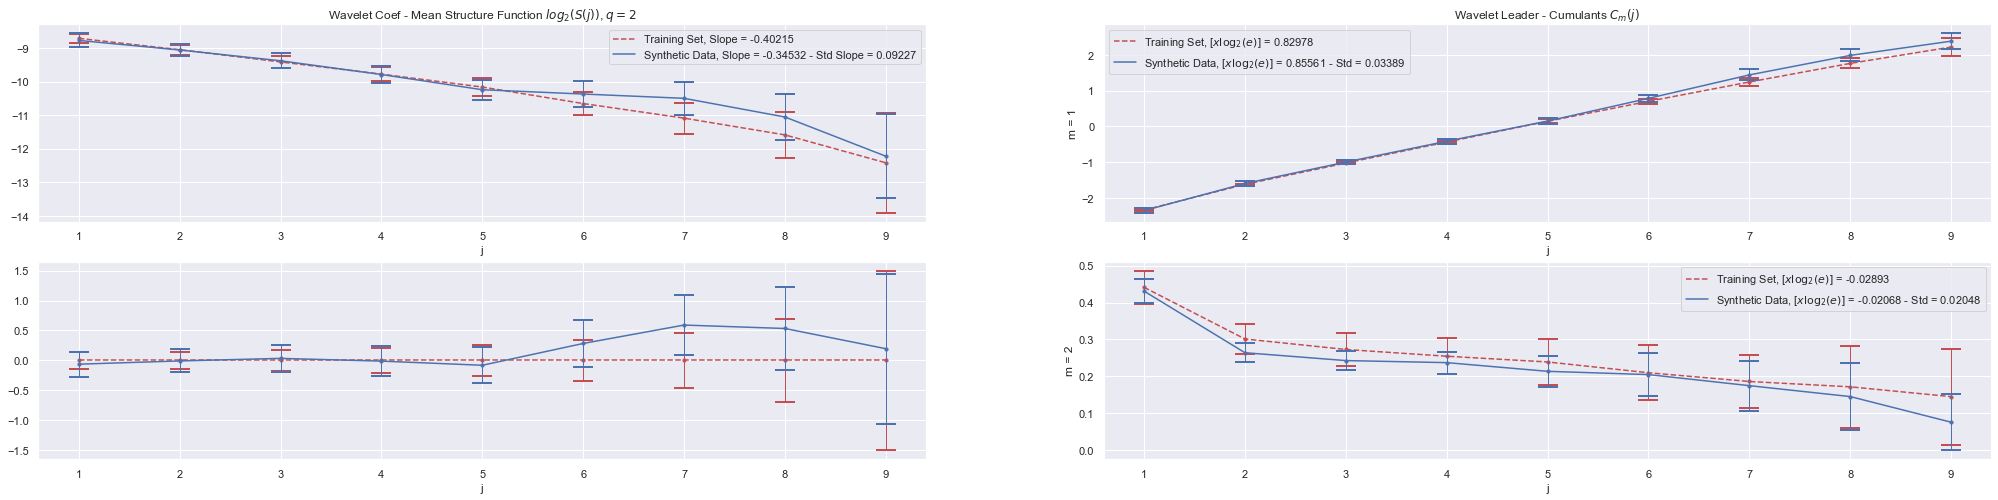

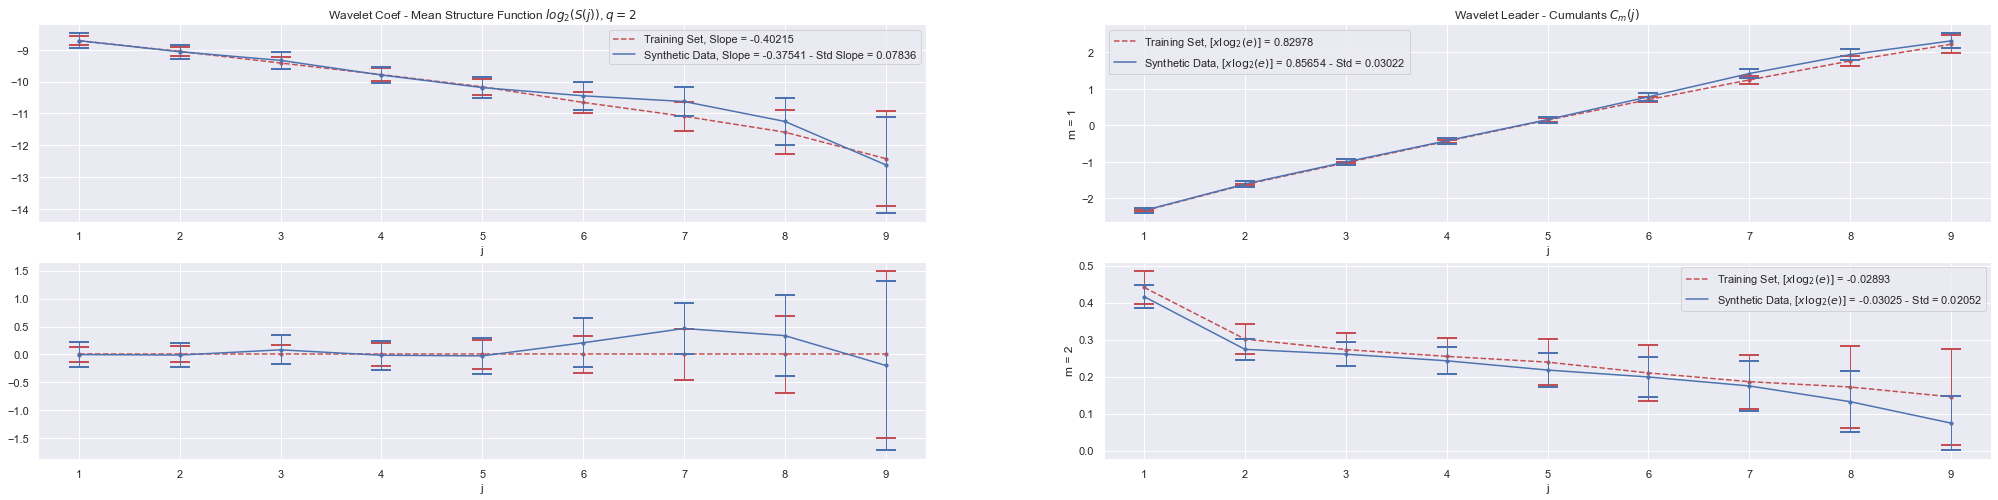

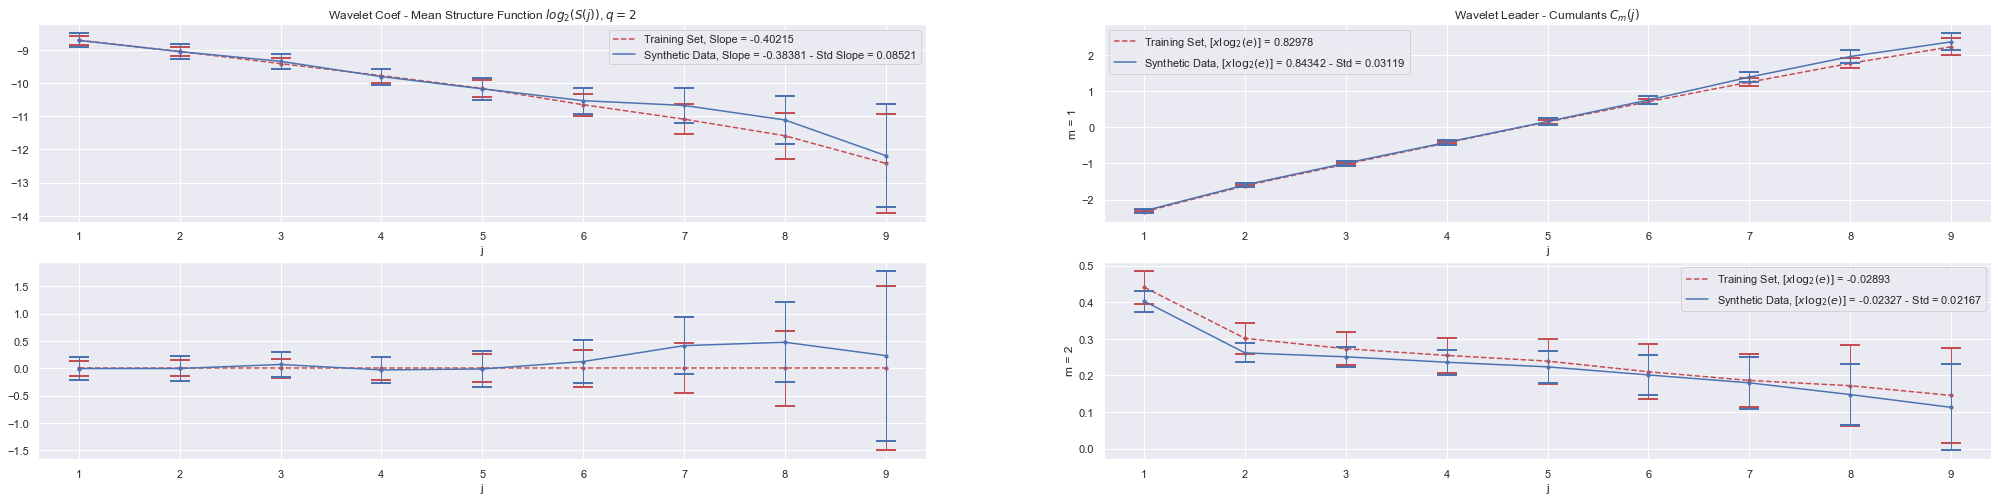

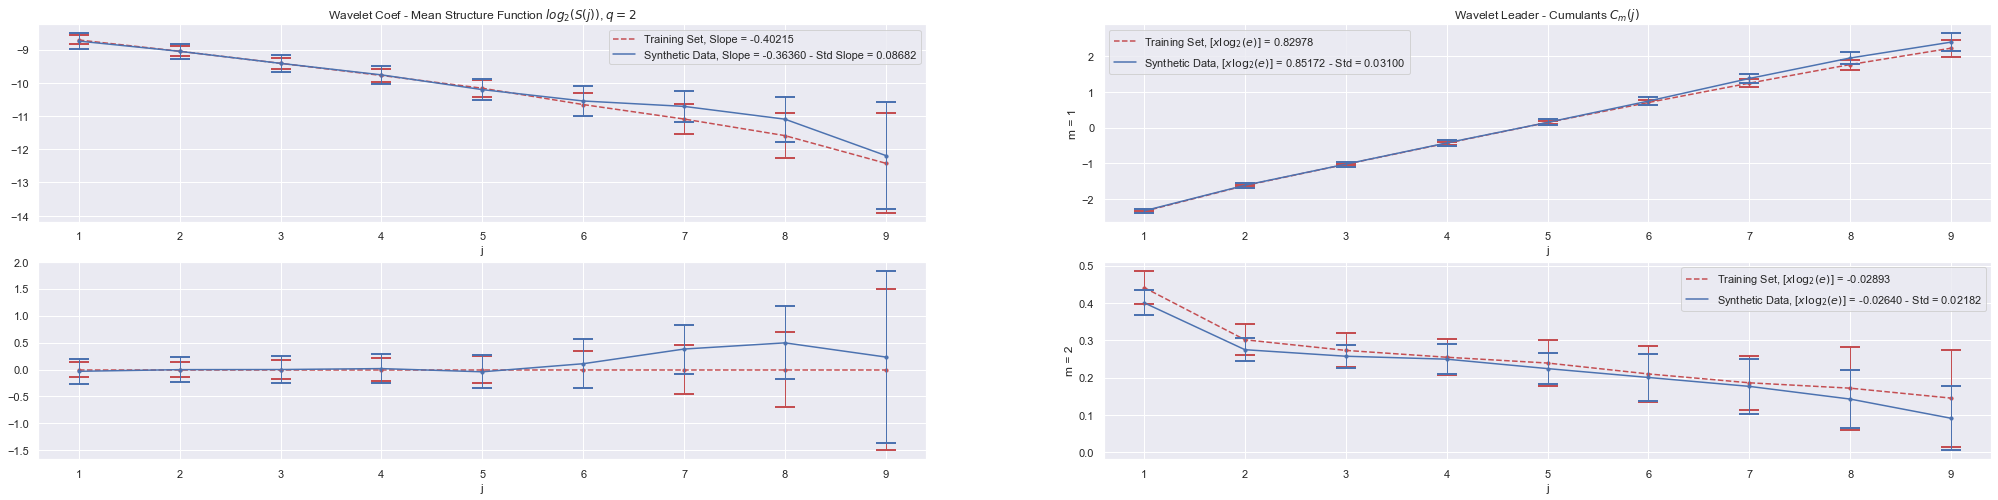

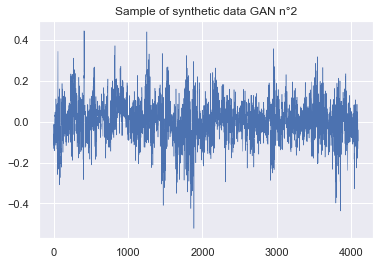

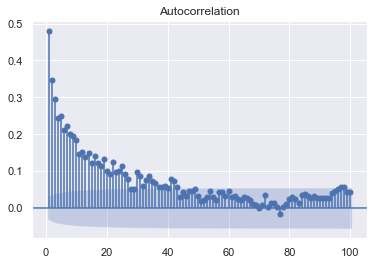

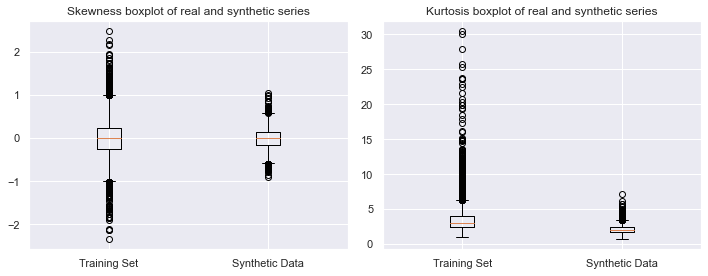

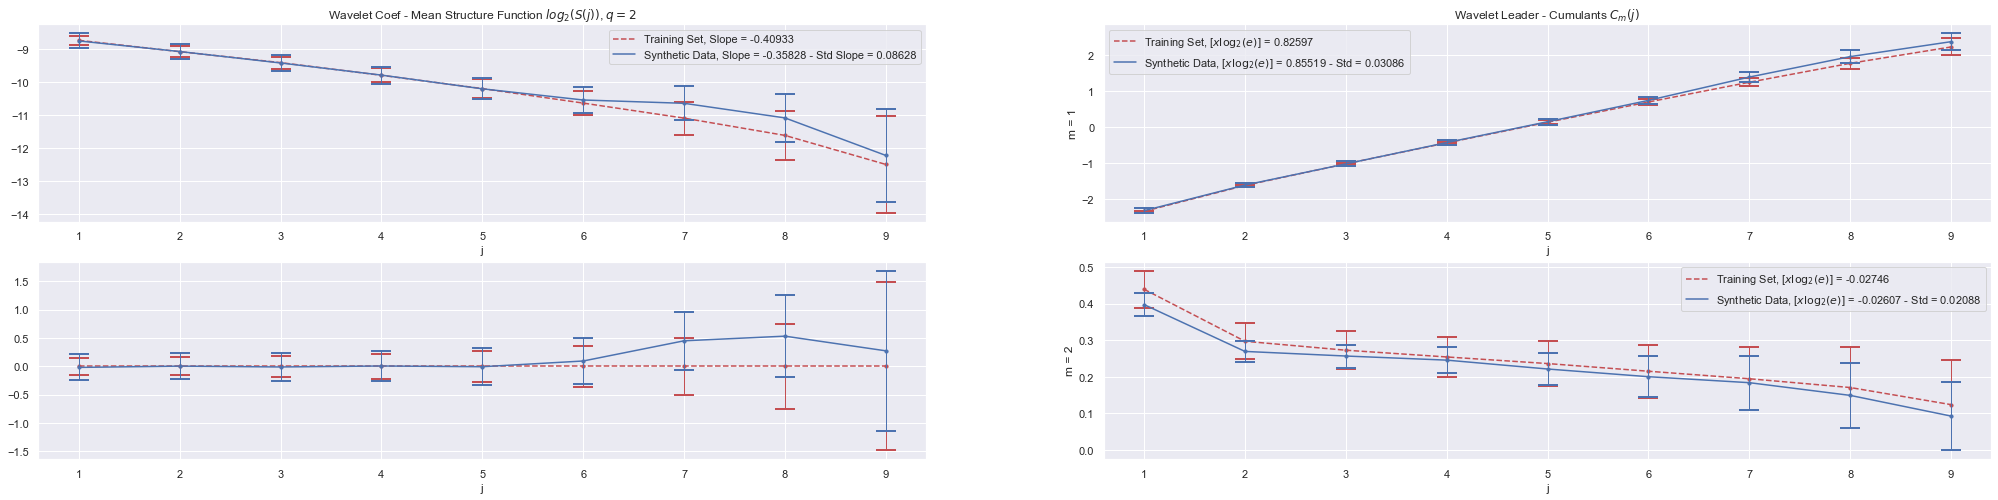

.....
New Training
.....


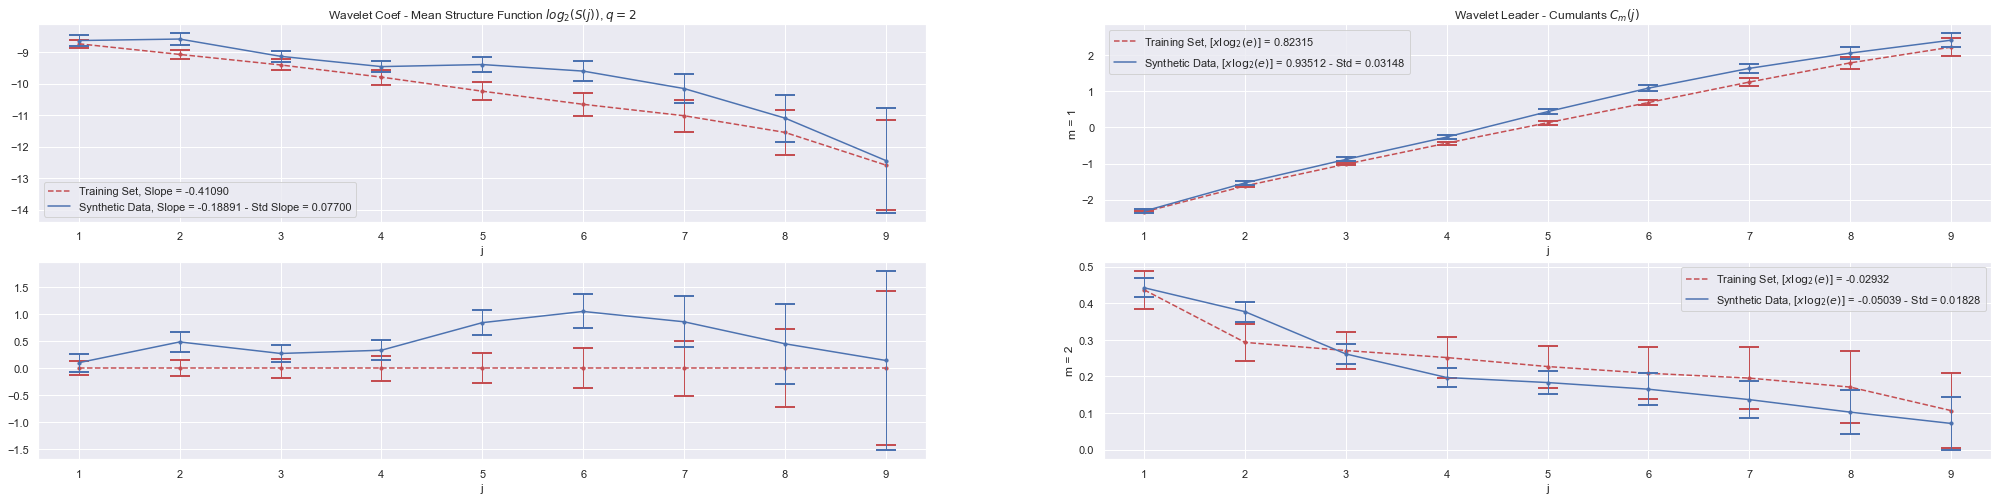

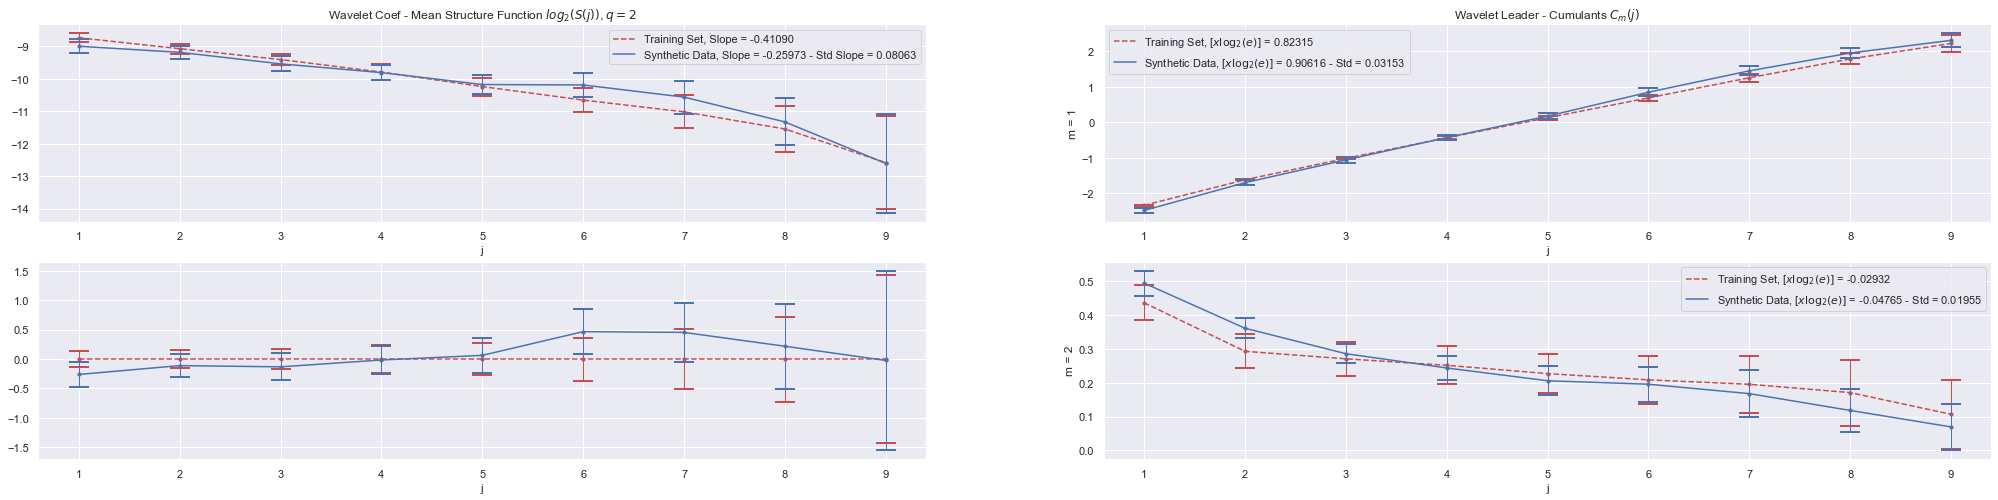

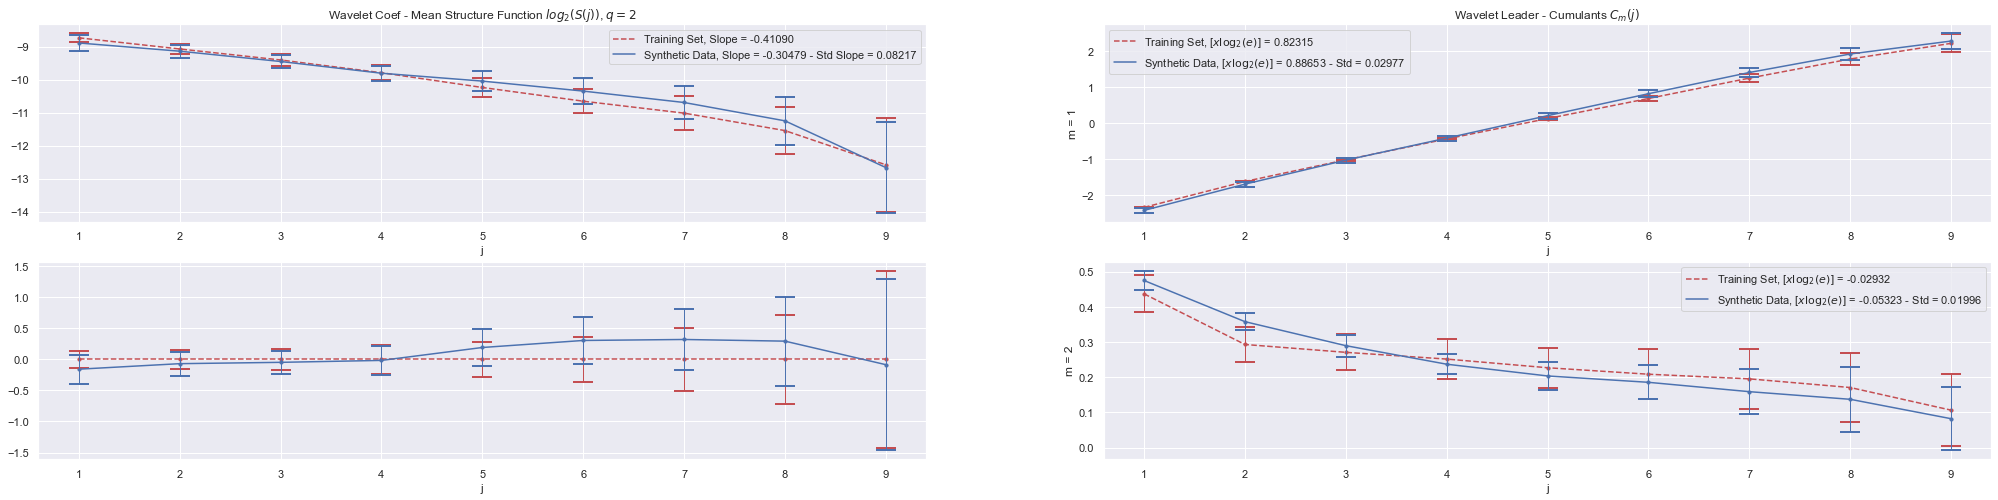

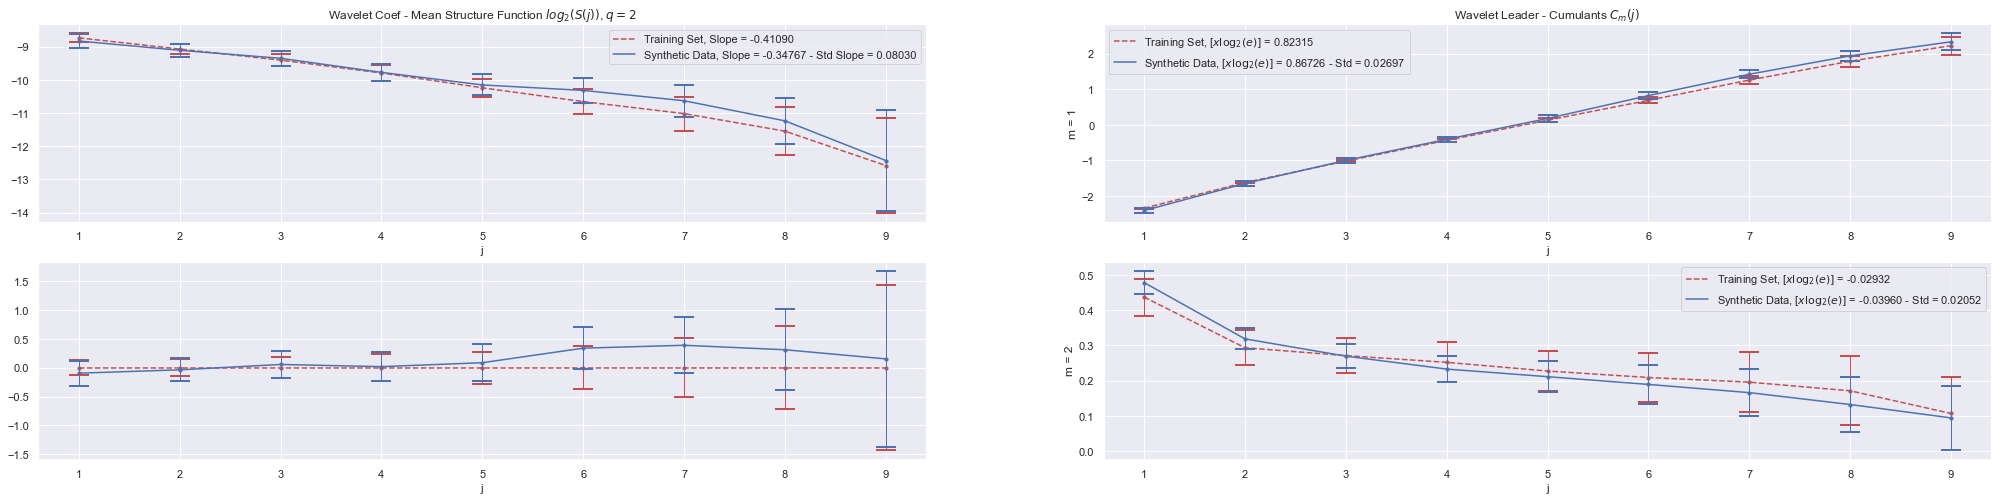

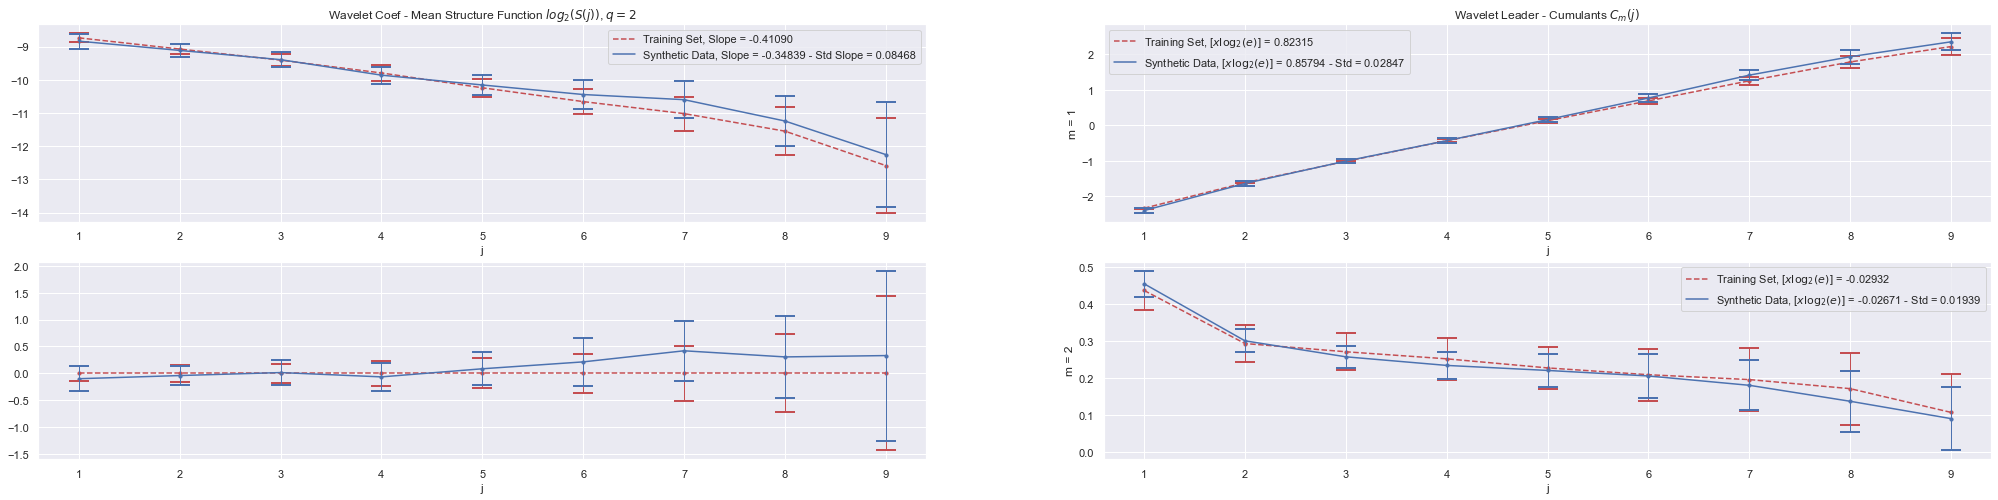

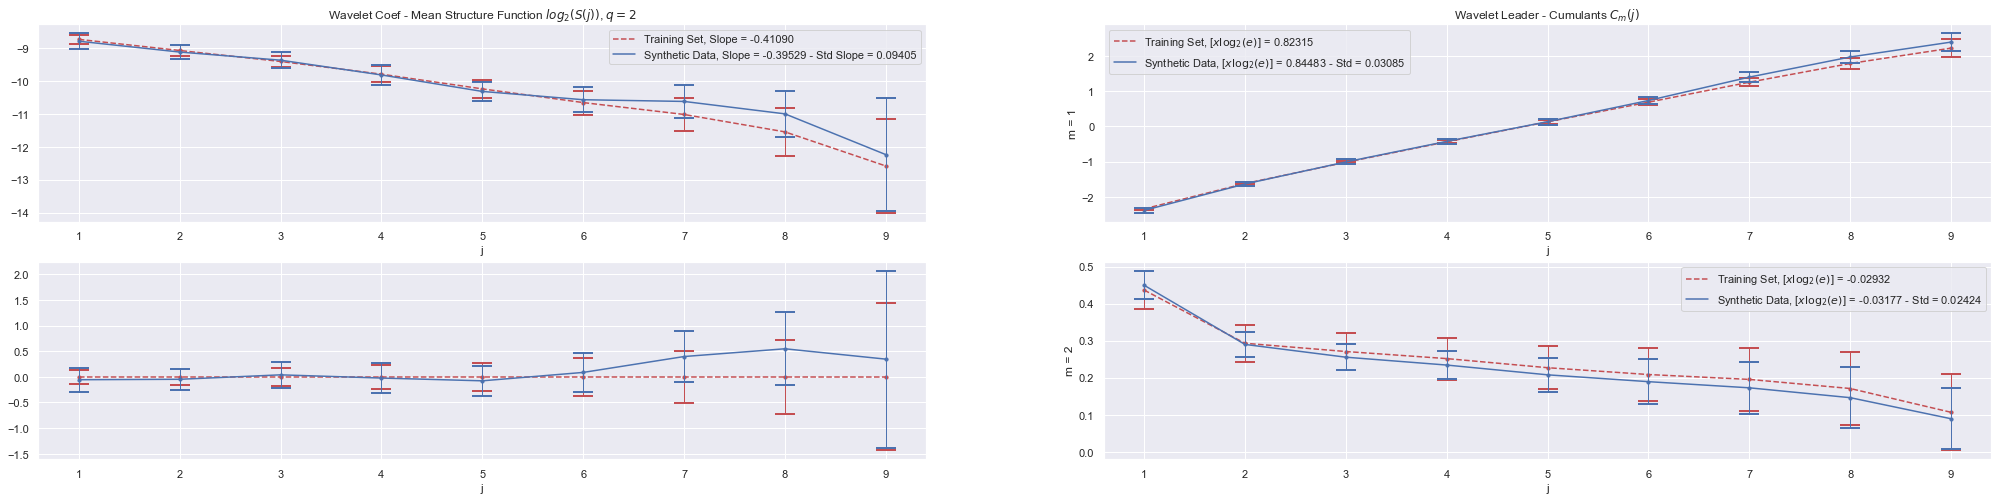

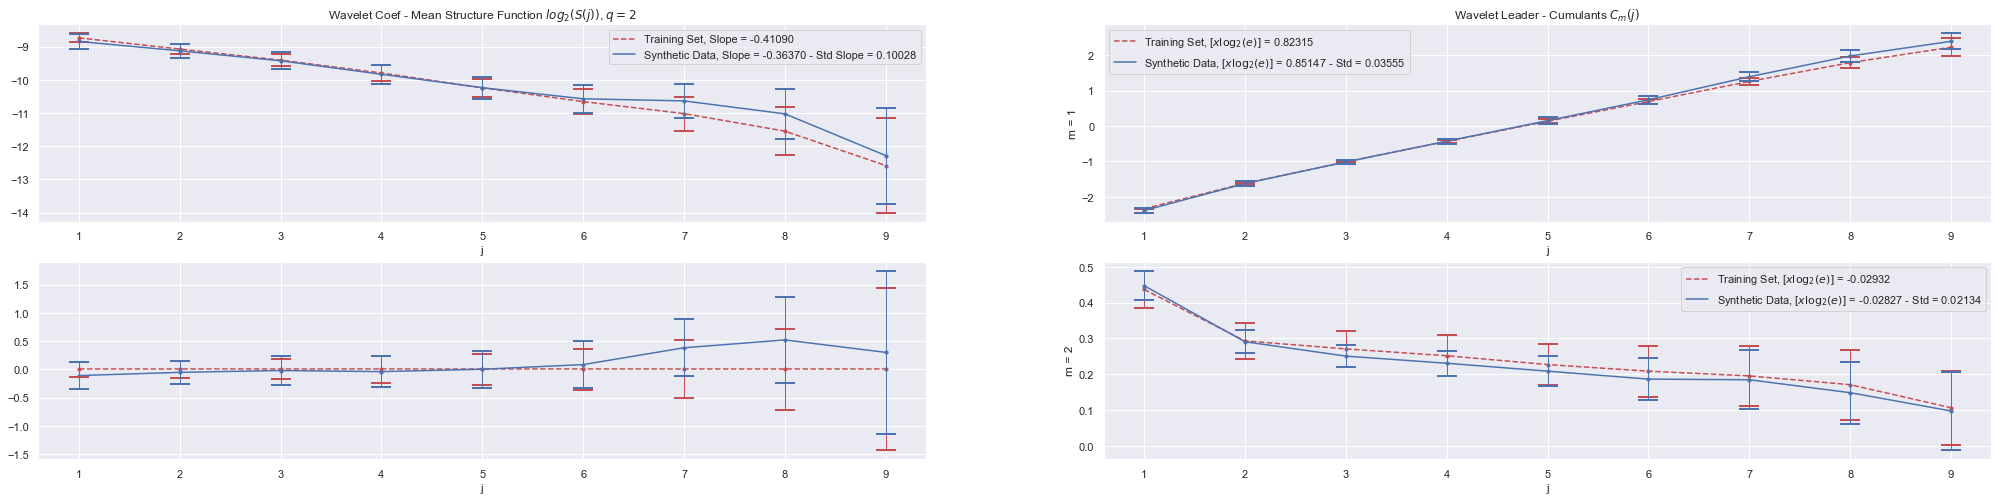

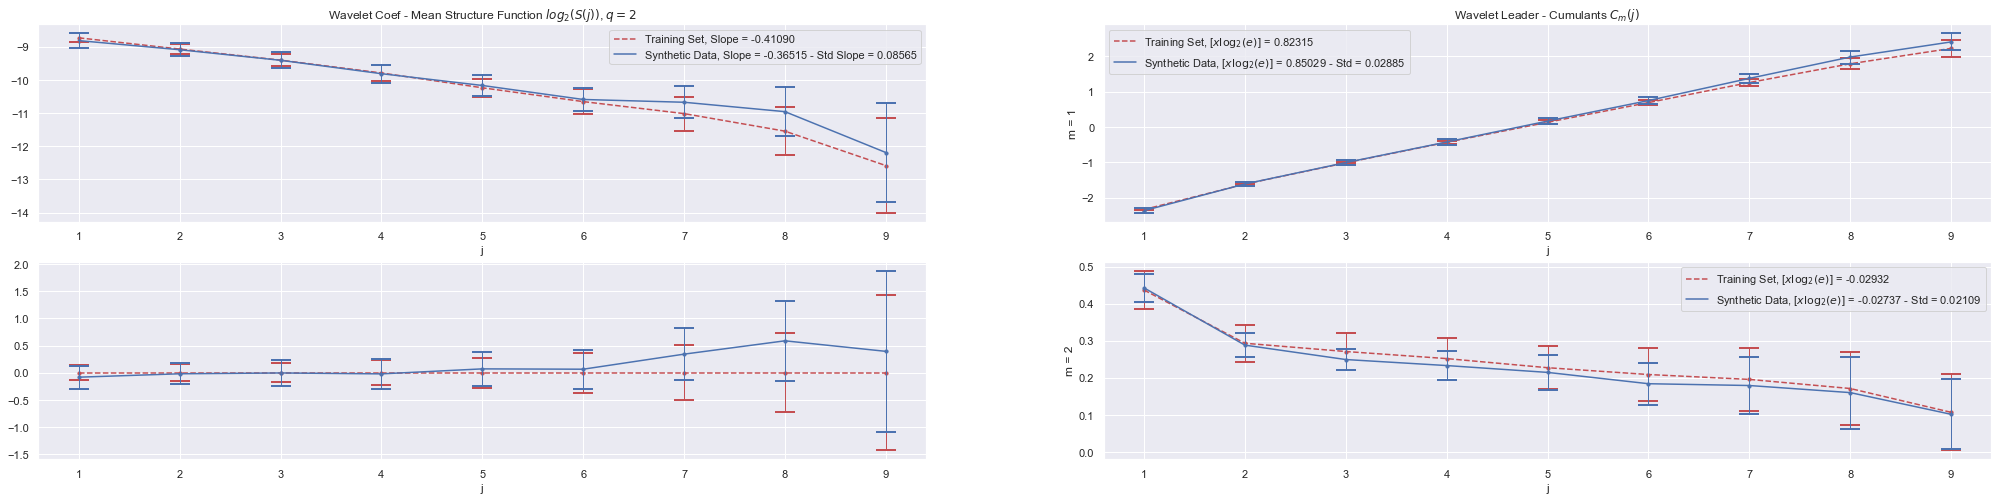

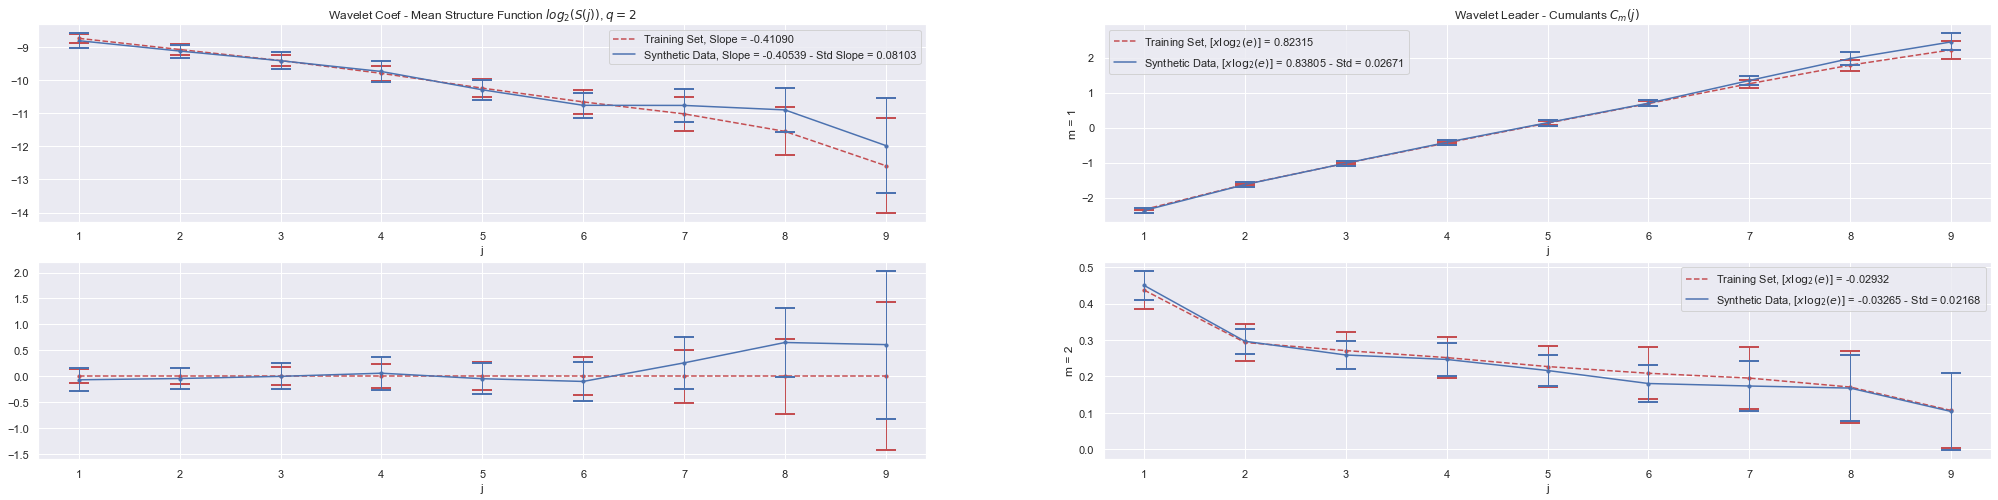

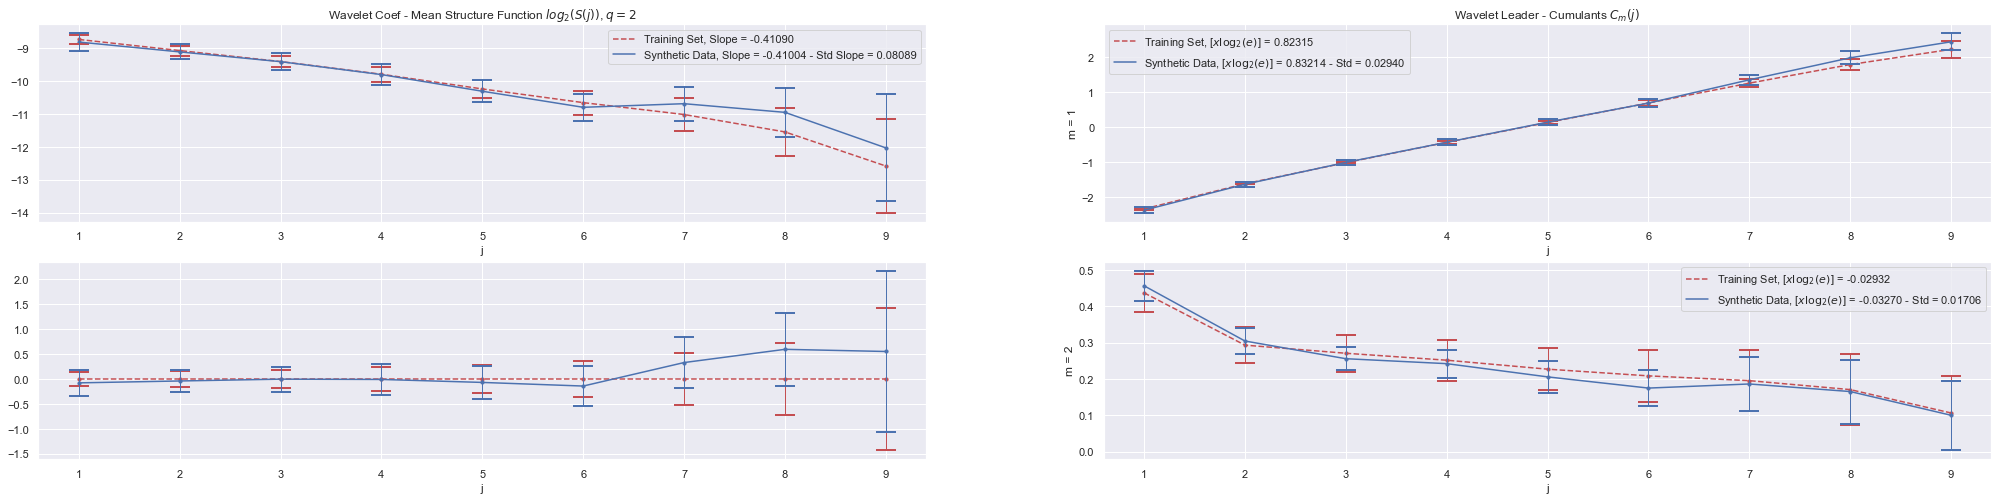

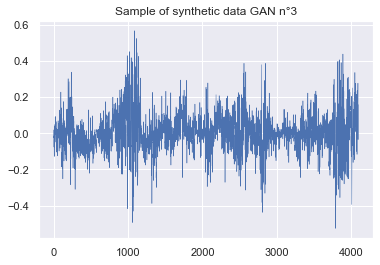

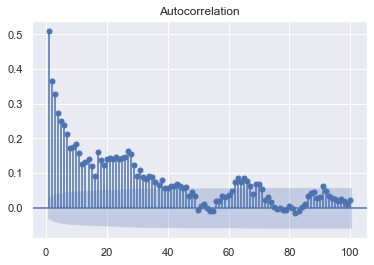

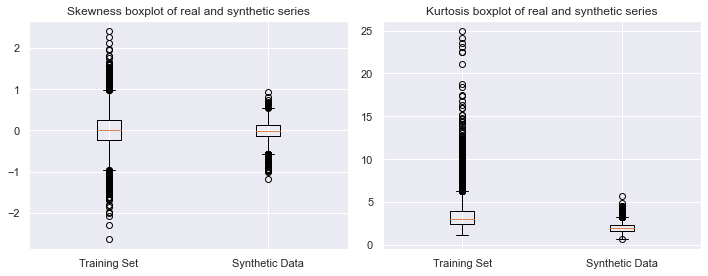

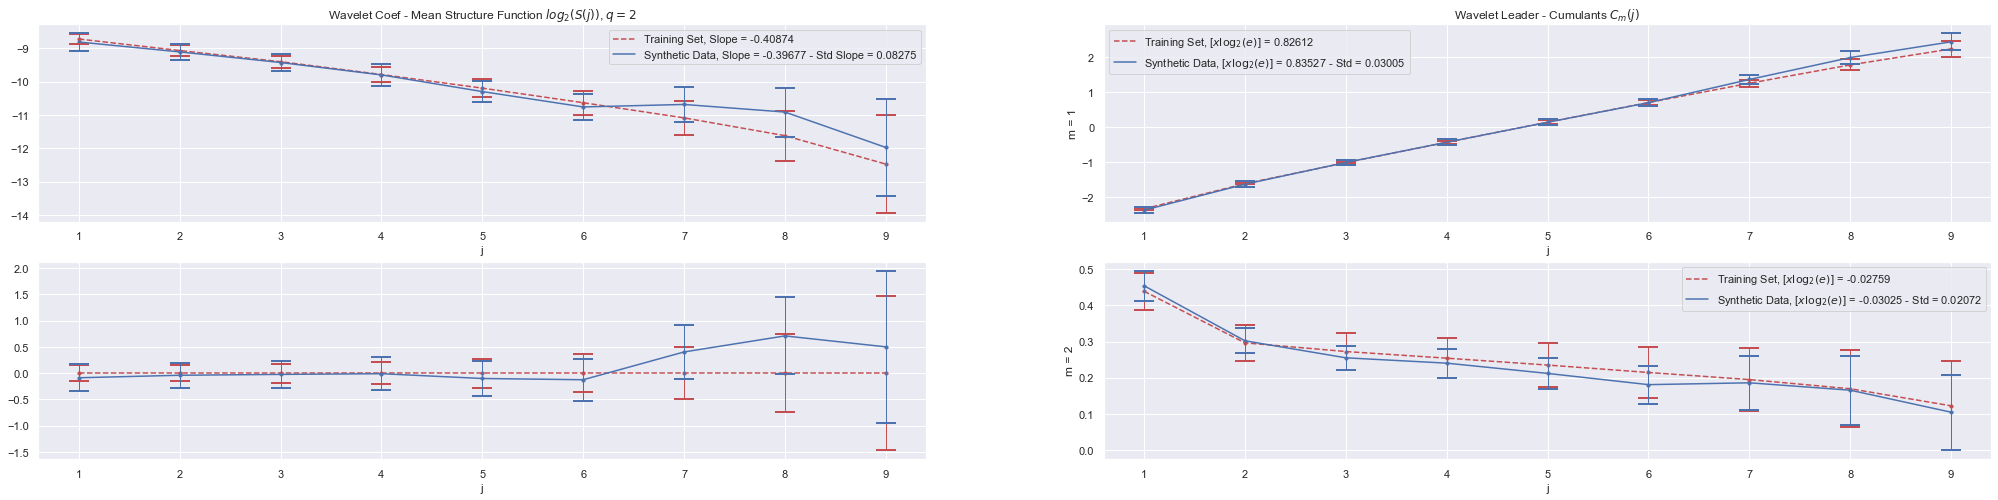

In [17]:
generatorsdense, discriminatorsdense, trainersdense, synthetic_datasdense, plot_result_sfdense, plot_result_mdense = complet_training2(n, '2022-07-08_mrw_0.8_0.03_Layer0/dense', '\\training_set_mrw_0.8_0.03.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

In [98]:
plot_m = []
plot_sf = []
synthetic_datasdense = []
tab_m = {'' : ['Mean', 'Std', 'Skweness', 'Kurtosis'], 'Data Set' : []}
for i in range (1,4):
    tab_m.update({'Training ' + str(i) : []})
    generator = Generator(latent_dim)
    generator.load_state_dict(torch.load(r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-07-08_mrw_0.8_0.03_Layer0\dense\Training n° {}\10000\generator10000 epochs.pth'.format(i)))
    
    noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim))
    synthetic_data = generator(noise)
    synthetic_datasdense.append(synthetic_data)
    plot_analysis_m = Analysis_m(training_set, synthetic_data, r'C:\Users\Stage\Desktop\WGAN_times_series')
    plot_analysis_sf = Analysis_sf(training_set, synthetic_data, r'C:\Users\Stage\Desktop\WGAN_times_series')
    plot_m.append(plot_analysis_m)
    plot_sf.append(plot_analysis_sf)
    tab_m['Training ' + str(i)].append(np.array(plot_analysis_m.moment_synthetic_data['mean']).mean())
    tab_m['Training ' + str(i)].append(np.array(plot_analysis_m.moment_synthetic_data['std']).mean())
    tab_m['Training ' + str(i)].append(np.array(plot_analysis_m.moment_synthetic_data['skew']).mean())
    tab_m['Training ' + str(i)].append(np.array(plot_analysis_m.moment_synthetic_data['kurtosis']).mean())

tab_m['Data Set'].append(np.array(plot_m[0].moment_data_train['mean']).mean())
tab_m['Data Set'].append(np.array(plot_m[0].moment_data_train['std']).mean())
tab_m['Data Set'].append(np.array(plot_m[0].moment_data_train['skew']).mean())
tab_m['Data Set'].append(np.array(plot_m[0].moment_data_train['kurtosis']).mean())

Histogram of H
.....
Training 1 - Slope : -0.36286088593543253 - Std : 0.08137359175251759
Training 2 - Slope : -0.3569688823711278 - Std : 0.08563722891569275
Training 3 - Slope : -0.3968944990835616 - Std : 0.08323613816675365
Data Set - Slope : -0.4102286677472159 - Std : 0.08463976010355413


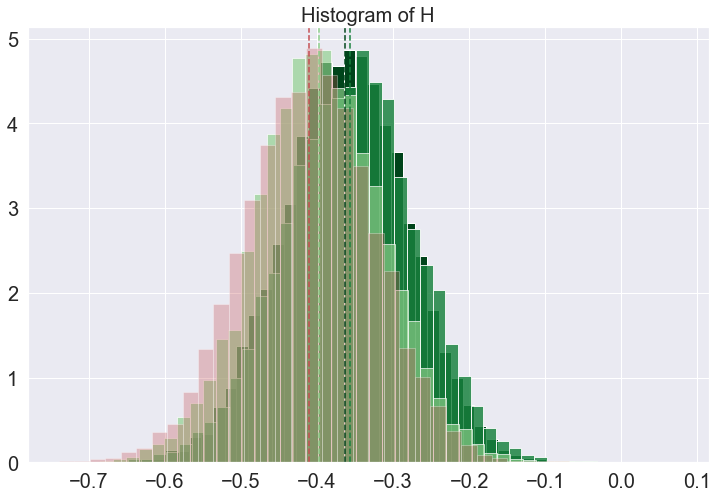

------------------------------------------------------------------------------------------------------
Histogram of C1
.....
Training 1 - Slope : 0.8465460792741305 - Std : 0.029997041232922666
Training 2 - Slope : 0.8551926385178938 - Std : 0.03013476379729046
Training 3 - Slope : 0.8353778514486421 - Std : 0.030098132598631623
Data Set - Slope : 0.8260430132882353 - Std : 0.029176076223291932


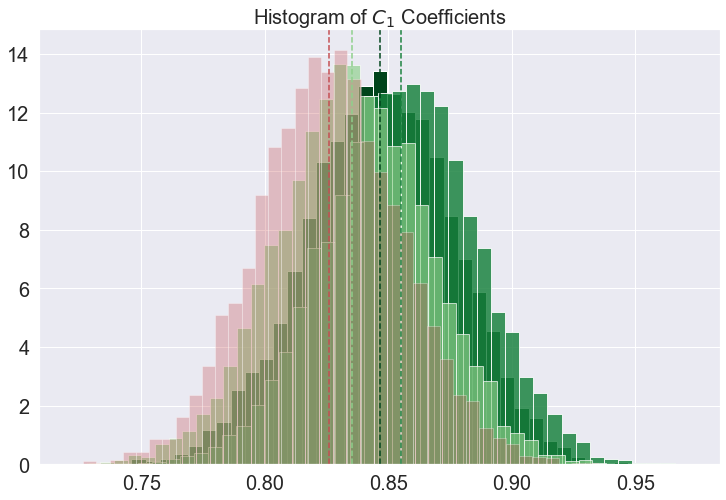

------------------------------------------------------------------------------------------------------
Histogram of C2
.....
Training 1 - Slope : -0.02922413714369532 - Std : 0.020057086059693016
Training 2 - Slope : -0.0254634798664102 - Std : 0.020724401353058582
Training 3 - Slope : -0.03049769308774049 - Std : 0.02086170278701078
Data Set - Slope : -0.028032292804944563 - Std : 0.021642960088618515


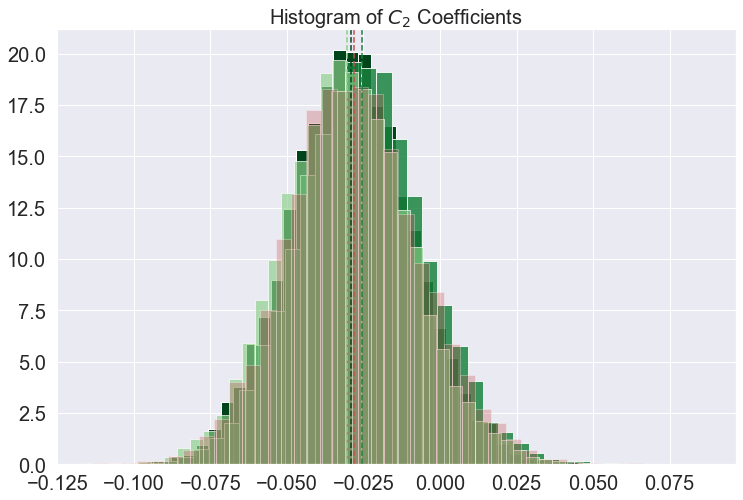

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean & -0.410229 &   -0.362861 &   -0.356969 &   -0.396894 \\
 Std &  0.084640 &    0.081374 &    0.085637 &    0.083236 \\
\bottomrule
\end{tabular}

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean &  0.826043 &    0.846546 &    0.855193 &    0.835378 \\
 Std &  0.029176 &    0.029997 &    0.030135 &    0.030098 \\
\bottomrule
\end{tabular}

------------------------------------------------------------------------------------------------------
\begin{tabular}{lrrrr}
\toprule
     &  Data Set &  Training 1 &  Training 2 &  Training 3 \\
\midrule
Mean & -0.028032 &   -0.029224 &   -0.025463 &   -0.030498 \\
 Std &  0.021643 &

In [88]:
hist_comp(synthetic_datasdense, plot_sf, training_set, 'Greens')

Training 1 - Slope : -0.36286088593543253 - Std : 0.08137359175251759
Training 2 - Slope : -0.36286088593543253 - Std : 0.08137359175251759
Training 3 - Slope : -0.36286088593543253 - Std : 0.08137359175251759
Data Set - Slope : -0.4102286677472159 - Std : 0.08463976010355413


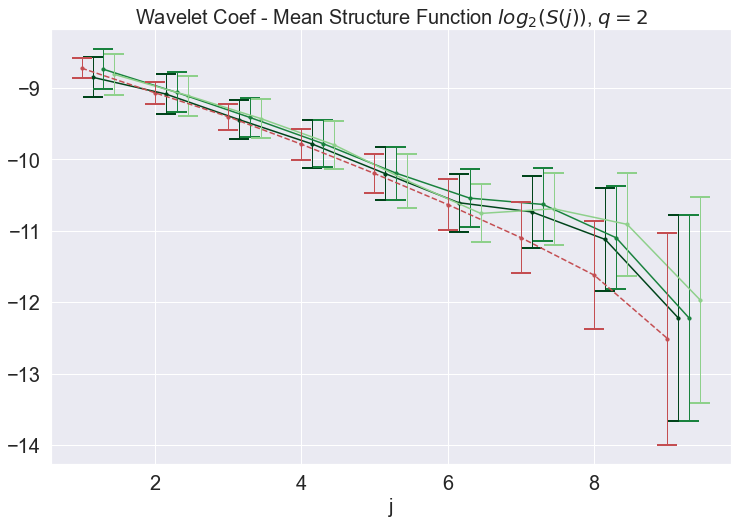

------------------------------------------------------------------------------------------------------
Training 1 - Slope : -0.02922413714369532 - Std : 0.020057086059693016
Training 2 - Slope : -0.0254634798664102 - Std : 0.020724401353058582
Training 3 - Slope : -0.03049769308774049 - Std : 0.02086170278701078
Data Set - Slope : -0.028032292804944563 - Std : 0.021642960088618515


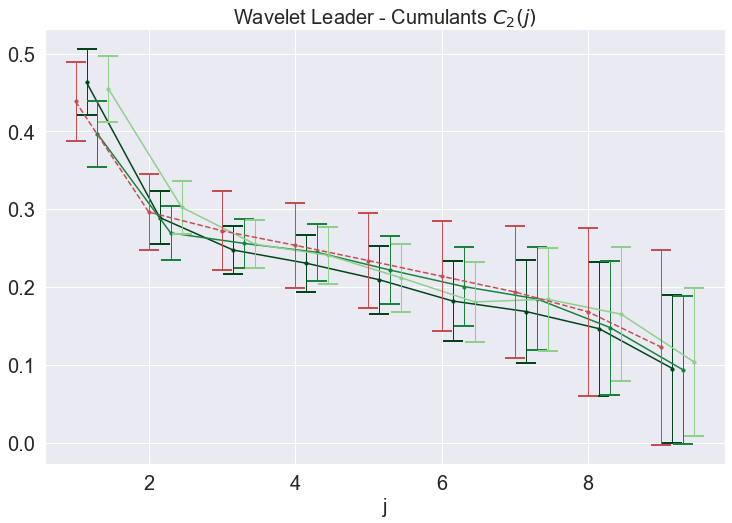

------------------------------------------------------------------------------------------------------


In [89]:
function_plot(plot_sf, 'Greens')

In [95]:
def create_real_data(latent_dim, dim, H, device):
    data = []
    ecart = []
    for _ in range (dim):
        x = mrw(latent_dim+1, H, np.sqrt(0.03), latent_dim+1)
        x = np.diff(x)
                
        data.append(x)
        ecart.append(np.array(x).std())
            
    ecart = np.array(ecart)
    sigma = ecart.mean()
    data = np.array(data) / sigma * 0.1
    data = data.astype('float32')
        
    data = torch.tensor(data)
        
    return data.to(device)

In [96]:
noise = torch.normal(mean = 0, std = 0.3, size =(10000, 2**14))
synthetic_data_14 = generatorsconv[0](noise)

true_data = create_real_data(2**14, 10000, 0.8, 'cpu')
analysis14 = Analysis_sf(true_data, synthetic_data_14, r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-06-30_mrw_0.8_0.03_Layer0')

noise = torch.normal(mean = 0, std = 0.3, size =(10000, 2**15))
synthetic_data_15 = generatorsconv[0](noise)

true_data = create_real_data(2**15, 10000, 0.8, 'cpu')
analysis15 = Analysis_sf(true_data, synthetic_data_15, r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-06-30_mrw_0.8_0.03_Layer0')

noise = torch.normal(mean = 0, std = 0.3, size =(10000, 2**16))
synthetic_data_16 = generatorsconv[0](noise)

true_data = create_real_data(2**16, 10000, 0.8, 'cpu')
analysis16 = Analysis_sf(true_data, synthetic_data_16, r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-06-30_mrw_0.8_0.03_Layer0')


noise = torch.normal(mean = 0, std = 0.3, size =(10000, 2**18))
synthetic_data_18 = generatorsconv[0](noise)

true_data = create_real_data(2**18, 10000, 0.8, 'cpu')
analysis18 = Analysis_sf(true_data, synthetic_data_18, r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-06-30_mrw_0.8_0.03_Layer0')

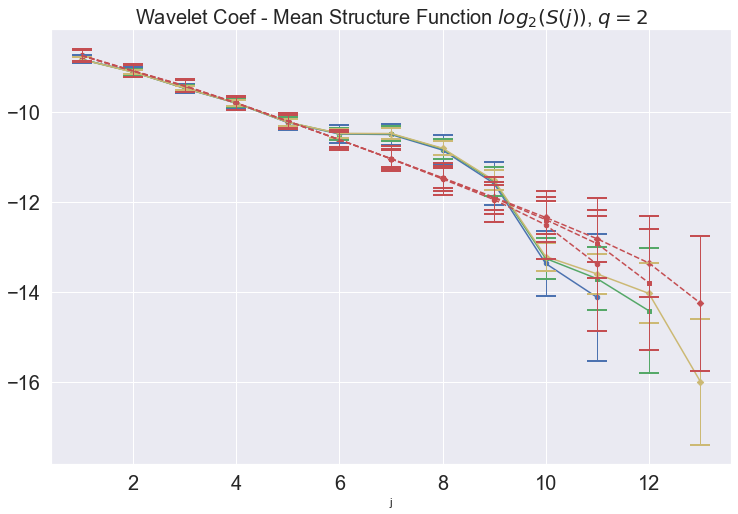

In [101]:
plt.figure(1, figsize = (6.1*2, 4*2))

plt.plot(analysis14.j, analysis14.wavelet_result_synthetic[0], 'b')
plt.scatter(analysis14.j, analysis14.wavelet_result_synthetic[0], color = 'b',s=20)
plt.errorbar(analysis14.j, analysis14.wavelet_result_synthetic[0], yerr = analysis14.wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'b', elinewidth = 1, capthick = 2)

plt.plot(analysis15.j, analysis15.wavelet_result_synthetic[0], 'g')
plt.scatter(analysis15.j, analysis15.wavelet_result_synthetic[0], color = 'g',s=20, marker = 's')
plt.errorbar(analysis15.j, analysis15.wavelet_result_synthetic[0], yerr = analysis15.wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'g', elinewidth = 1, capthick = 2)

plt.plot(analysis16.j, analysis16.wavelet_result_synthetic[0], 'y')
plt.scatter(analysis16.j, analysis16.wavelet_result_synthetic[0], color = 'y',s=20, marker = "D")
plt.errorbar(analysis16.j, analysis16.wavelet_result_synthetic[0], yerr = analysis16.wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'y', elinewidth = 1, capthick = 2)
plt.xlabel('j')


plt.plot(analysis14.j, analysis14.wavelet_result_data[0], 'r--')
plt.scatter(analysis14.j, analysis14.wavelet_result_data[0], color = 'r',s=20)
plt.errorbar(analysis14.j, analysis14.wavelet_result_data[0], yerr = analysis14.wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analysis15.j, analysis15.wavelet_result_data[0], 'r--')
plt.scatter(analysis15.j, analysis15.wavelet_result_data[0], color = 'r',s=20, marker = 's')
plt.errorbar(analysis15.j, analysis15.wavelet_result_data[0], yerr = analysis15.wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analysis16.j, analysis16.wavelet_result_data[0], 'r--')
plt.scatter(analysis16.j, analysis16.wavelet_result_data[0], color = 'r',s=20, marker = "D")
plt.errorbar(analysis16.j, analysis16.wavelet_result_data[0], yerr = analysis16.wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
plt.xlabel('j')
plt.title('Wavelet Coef - Mean Structure Function $log_2(S(j))$, $q=2$', fontsize = 20)
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

#plt.ylim(-16, -8)
plt.show()

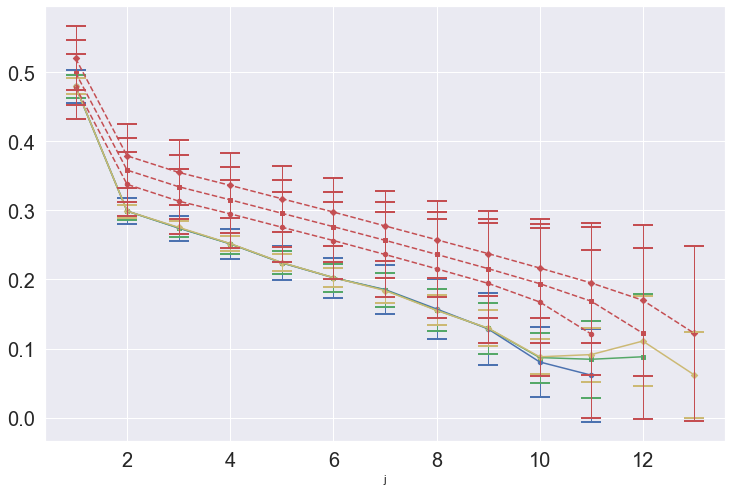

In [106]:
plt.figure(1, figsize = (6.1*2, 4*2))

plt.plot(analysis14.j, analysis14.cumul_result2_synthetic[0], 'b')
plt.scatter(analysis14.j, analysis14.cumul_result2_synthetic[0], color = 'b',s=20)
plt.errorbar(analysis14.j, analysis14.cumul_result2_synthetic[0], yerr = analysis14.cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'b', elinewidth = 1, capthick = 2)

plt.plot(analysis15.j, analysis15.cumul_result2_synthetic[0], 'g')
plt.scatter(analysis15.j, analysis15.cumul_result2_synthetic[0], color = 'g',s=20, marker = 's')
plt.errorbar(analysis15.j, analysis15.cumul_result2_synthetic[0], yerr = analysis15.cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'g', elinewidth = 1, capthick = 2)

plt.plot(analysis16.j, analysis16.cumul_result2_synthetic[0], 'y')
plt.scatter(analysis16.j, analysis16.cumul_result2_synthetic[0], color = 'y',s=20, marker = "D")
plt.errorbar(analysis16.j, analysis16.cumul_result2_synthetic[0], yerr = analysis16.cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'y', elinewidth = 1, capthick = 2)
plt.xlabel('j')


plt.plot(analysis14.j, analysis14.cumul_result2_data[0], 'r--')
plt.scatter(analysis14.j, analysis14.cumul_result2_data[0], color = 'r',s=20)
plt.errorbar(analysis14.j, analysis14.cumul_result2_data[0], yerr = analysis14.cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analysis15.j, analysis15.cumul_result2_data[0], 'r--')
plt.scatter(analysis15.j, analysis15.cumul_result2_data[0], color = 'r',s=20, marker = 's')
plt.errorbar(analysis15.j, analysis15.cumul_result2_data[0], yerr = analysis15.cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analysis16.j, analysis16.cumul_result2_data[0], 'r--')
plt.scatter(analysis16.j, analysis16.cumul_result2_data[0], color = 'r',s=20, marker = "D")
plt.errorbar(analysis16.j, analysis16.cumul_result2_data[0], yerr = analysis16.cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)
plt.xlabel('j')
plt.title('', fontsize = 20)
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

#plt.ylim(-16, -8)
plt.show()

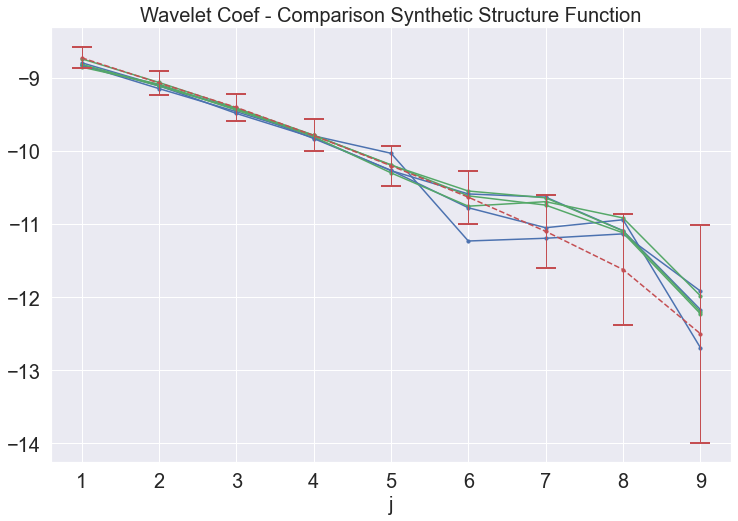

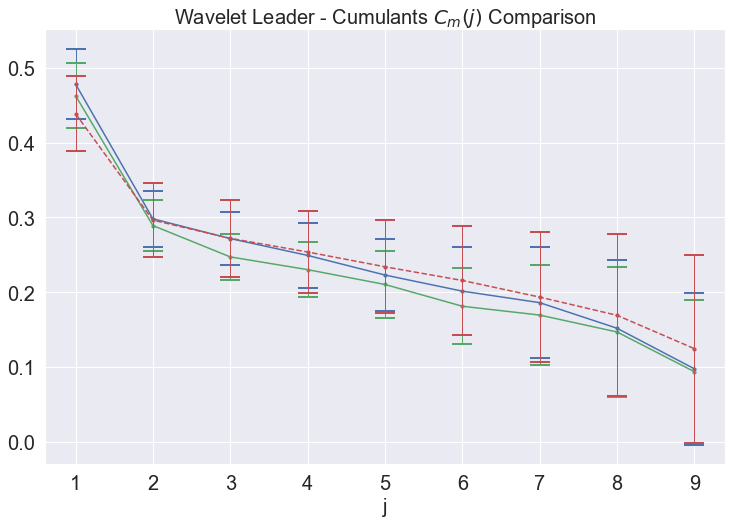

In [107]:
j = plot_result_sfconv[0].j

plt.figure(1, figsize=(6.1*2, 4*2)) 

#Convolution
plt.plot(j, plot_result_sfconv[0].wavelet_result_synthetic[0], color = 'b')
plt.scatter(j, plot_result_sfconv[0].wavelet_result_synthetic[0], color = 'b',s=10)
#plt.errorbar(j, plot_result_sfconv[0].wavelet_result_synthetic[0], yerr = plot_result_sfconv[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'b', elinewidth = 1, capthick = 2)

plt.plot(j, plot_result_sfconv[1].wavelet_result_synthetic[0], color = 'b')
plt.scatter(j, plot_result_sfconv[1].wavelet_result_synthetic[0], color = 'b',s=10)

plt.plot(j, plot_result_sfconv[2].wavelet_result_synthetic[0], color = 'b')
plt.scatter(j, plot_result_sfconv[2].wavelet_result_synthetic[0], color = 'b',s=10)


#Dense
plt.plot(j, plot_sf[0].wavelet_result_synthetic[0], color = 'g')
plt.scatter(j, plot_sf[0].wavelet_result_synthetic[0], color = 'g',s=10)
#plt.errorbar(j, plot_sf[0].wavelet_result_synthetic[0], yerr = plot_sf[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'g', elinewidth = 1, capthick = 2)

plt.plot(j, plot_sf[1].wavelet_result_synthetic[0], color = 'g')
plt.scatter(j, plot_sf[1].wavelet_result_synthetic[0], color = 'g',s=10)

plt.plot(j, plot_sf[2].wavelet_result_synthetic[0], color = 'g')
plt.scatter(j, plot_sf[2].wavelet_result_synthetic[0], color = 'g',s=10)
#data set 
plt.plot(j, plot_result_sfconv[0].wavelet_result_data[0], 'r--')
plt.scatter(j, plot_result_sfconv[0].wavelet_result_data[0], color = 'r',s=10)
plt.errorbar(j, plot_result_sfconv[0].wavelet_result_data[0], yerr = plot_result_sfconv[0].wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.xlabel('j', fontsize = 20)
plt.title('Wavelet Coef - Comparison Synthetic Structure Function', fontsize = 20)
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)


plt.figure(2, figsize=(6.1*2, 4*2)) 
#Convolution
plt.plot(j, plot_result_sfconv[0].cumul_result2_synthetic[0], color = 'b')
plt.scatter(j, plot_result_sfconv[0].cumul_result2_synthetic[0], color = 'b',s=10)
plt.errorbar(j, plot_result_sfconv[0].cumul_result2_synthetic[0], yerr = plot_result_sfconv[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor ='b', elinewidth = 1, capthick = 2)

#Dense
plt.plot(j, plot_sf[0].cumul_result2_synthetic[0], color = 'g')
plt.scatter(j, plot_sf[0].cumul_result2_synthetic[0], color = 'g',s=10)
plt.errorbar(j, plot_sf[0].cumul_result2_synthetic[0], yerr = plot_sf[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = 'g', elinewidth = 1, capthick = 2)

#Data set 
plt.plot(j, plot_result_sfconv[0].cumul_result2_data[0], 'r--')
plt.scatter(j, plot_result_sfconv[0].cumul_result2_data[0], color = 'r',s=10)
plt.errorbar(j, plot_result_sfconv[0].cumul_result2_data[0], yerr = plot_result_sfconv[0].cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.xlabel('j', fontsize = 20)
plt.title('Wavelet Leader - Cumulants $C_m (j)$ Comparison', fontsize = 20)
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()